In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import optax
# from parent_dir import *
from reupload_ff_circuit.data_gen import data_generator


import os
import ipynbname  

from reupload_ff_circuit.util import *
from reupload_ff_circuit.q_functions import *
from reupload_ff_circuit.q_circuits import *

In [2]:
# Added to silence some warnings.
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
jax.config.update('jax_platform_name', 'cpu')

In [3]:
# nb_fname = ipynbname.name()
# ver = nb_fname[nb_fname.index('v'):nb_fname.index('_')] if 'v' in nb_fname else nb_fname
date, day = time.strftime("%Y%m%d-%H%M"), time.strftime("%Y%m%d-%H")
cwd = os.getcwd()

In [4]:
ver = 'Demo_v1.0'
problem = 'breast_cancer' #'3 circles'#'moon'#
shape =  "tetrahedron"#"binary" #"bitwise" #"square plane"#
rot = 'zyz' #'yzy' #'xzx' #
num_training = 400
num_test = 100

enc_dim = 3
num_qubits = 5
num_layers = 1
num_reupload = 1
num_rot = 1

max_n_converge = 10
thres_converge = 0.0001

seed_num = data_seed_num= 40#

In [5]:
training_noise =  False  #True#,
test_noise = False  #True#,
# jtest =  test if training_noise else jax.jit(test, static_argnames = ('*args','**kwargs'))#static_argnums=(3,4))

In [6]:

# service = QiskitRuntimeService()
# backend = service.backend("ibm_brisbane")  # ibm_strasbourg # 
# print('backend:', backend.name)

In [7]:
configs = {'noise': False,  #####
           'fake_backend': False,    #True#,
           'real_device':  False,    #True#
           'preprocess' : "scaling",  #None #  "normalization"# "standardization" #
           # 'backend' : backend,
           'backend_name' : None, #'ibm_brisbane', # 'ibm_strasbourg', # '''None means least_busy backend'''
           'rot' : rot, 
           'shape' : shape,
          }

In [8]:
import random
num_cvs = 5
num_seeds = 10
random.seed(seed_num)
seeds = [random.randint(0, int(1e5)) for _ in range(num_seeds)]
seeds

[60110, 75954, 68678, 4174, 32150, 37018, 87104, 83505, 87073, 27044]

In [9]:
# set range of aubits and rotations
num_settings = 1, 5, 1, 1, 1 # r_enc, r_q ,r_f, r_r, r_rot ## run the setting with n values
start_values = 5, 1, 1, 1, 3 # e0, q0, f0, r0, rot0 

settings = setting_generator(num_settings,start_values)
settings#=settings[:3]


[[5, 1, 1, 1, 3],
 [5, 2, 1, 1, 3],
 [5, 3, 1, 1, 3],
 [5, 4, 1, 1, 3],
 [5, 5, 1, 1, 3]]

In [10]:
h_params= {'lr':[[0.15,0.05,0.01],[0.15,0.05,0.01,0.001,0.0001]],  #
           'max_epoch':[60],#3200
           'batch_size':[50,100,300],
           'dynamic_size':[50],
           'thres':[[0.05,0.03,0.01]]}#]}#[0.05],
h_pms = [(tuple(i),j,k,l,tuple(m)) for i in h_params['lr'] for j in h_params['max_epoch'] for k in h_params['batch_size'] for l in h_params['dynamic_size'] for m in h_params['thres']]
h_pms

[((0.15, 0.05, 0.01), 60, 50, 50, (0.05, 0.03, 0.01)),
 ((0.15, 0.05, 0.01), 60, 100, 50, (0.05, 0.03, 0.01)),
 ((0.15, 0.05, 0.01), 60, 300, 50, (0.05, 0.03, 0.01)),
 ((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 50, 50, (0.05, 0.03, 0.01)),
 ((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 100, 50, (0.05, 0.03, 0.01)),
 ((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 300, 50, (0.05, 0.03, 0.01))]

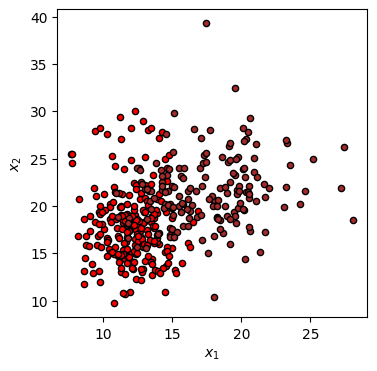

In [11]:
Xdata, ydata = data_gen(problem,num_training)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


theta = [0.         1.91063324 1.91063324 1.91063324] 
phi = [0.         2.0943951  4.1887902  6.28318531]
c_states= [[[ 1.        +0.00000000e+00j]
  [ 0.        +0.00000000e+00j]]

 [[ 0.57735027+0.00000000e+00j]
  [-0.40824829+7.07106781e-01j]]

 [[ 0.57735027+0.00000000e+00j]
  [-0.40824829-7.07106781e-01j]]

 [[ 0.57735027+0.00000000e+00j]
  [ 0.81649658-1.99983985e-16j]]] 
shape: (4, 2, 1)


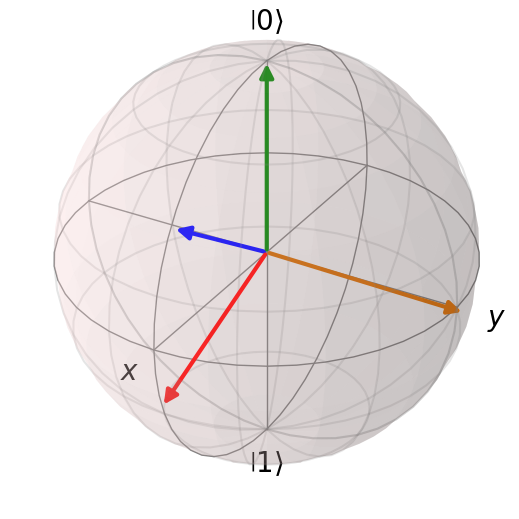

In [12]:
# Define output labels as quantum state vectors
num_class = np.unique(data_gen(problem)[1]).max()
c_states, dm_labels, Yc = predefined_states_dm(shape,num_qubits)
configs['dm_labels'] = dm_labels
configs['num_class_1q'] = len(c_states)
configs['Yc'] = totuple(Yc)

In [13]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation,
        opt_state,x,y,*args,x_valid=None,y_valid=None,**kwargs) -> optax.Params:
  #opt_state = optimizer.init(params)
  # for k, v in kwargs.items():
  #   if 'noise' in k:
  #       noise = v
  def step(params, opt_state,x,y):
    loss_batches = jnp.array([])
    predicted_train = jnp.array([])
    iter_batch = iterate_minibatches(x, y, batch_size=batch_size)
    for x_batch, y_batch in iter_batch:
        predicted_batch, loss_batch , grads = jtest(params, x_batch, y_batch,*args,**kwargs)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss_batches = jax.numpy.append(loss_batches,loss_batch)
        predicted_train = jax.numpy.append(predicted_train, predicted_batch)
    loss_value = jnp.average(loss_batches)
    return params, opt_state, loss_value, predicted_train
  n_converge = 0
  
  learning_rate,max_epoch,batch_size,dynamic_size,threshold = kwargs['_h_pm']
  iter_lr = kwargs['iter_lr']
  iter_thres = kwargs['iter_thres']
  lr = kwargs['lr']
  thres_n = kwargs['thres_n']
  

  #loss_history = []
  params_history = []
  state_history = []
  valid_accuracy_history=[]
  ave_loss = 1
  l_r = lr
  thres = thres_n
  for i  in range(max_epoch):
    i=i+1
    state_history.append(opt_state) #save value advance otherwise it saves the updated one
    params_history.append(params)
    
    params, opt_state, loss_value , predicted_train= step(params, opt_state, x, y)
    accuracy_train = accuracy_score(y, predicted_train)
    
    print(f'step {i}, accuracy_train:{accuracy_train}, loss: {loss_value}')
    if x_valid is not None and y_valid is not None:
        accuracy_valid, loss_valid = scores(params, x_valid, y_valid, *args, **kwargs)
        valid_loss_history.append(float(loss_valid))
        valid_accuracy_history.append(float(accuracy_valid))
    loss_history.append(float(loss_value))    
    accuracy_history.append(float(accuracy_train))
    
    if i%dynamic_size==0:
        c_ave = sum(loss_history[-dynamic_size:])/dynamic_size #current loss average
        now_thres = abs(c_ave-ave_loss)/ave_loss
        print(now_thres)
        if  now_thres<=thres:
            try:
                l_r=next(iter_lr)#learning_rate
                #loc_best_accuracy = np.argmax(accuracy_history[-dynamic_size:])-dynamic_size
                loc_best_loss = np.argmin(loss_history[-dynamic_size:])-dynamic_size
                params = params_history[loc_best_loss]
                #print('best known accuracy:', accuracy_history[loc_best_accuracy]) #update lr based on accuracy
                print('accuracy of best loss :', accuracy_history[loc_best_loss]) #update lr based on loss
                
                opt_state.hyperparams['learning_rate'] = l_r
                #print('lr:', l_r, opt_state.hyperparams['learning_rate'])
                try:
                    thres = next(iter_thres)
                except StopIteration:
                    print(thres)
            except StopIteration:
                pass
        print('lr:', l_r, opt_state.hyperparams['learning_rate'])
        print(i)
        n_converge  = n_converge+1 if now_thres<thres_converge else 0
        ave_loss = c_ave
        
    if i==max_epoch or n_converge==max_n_converge:
        n_converge = 1 if n_converge==0 else n_converge 
        #loc_best_accuracy = np.argmax(accuracy_history[-dynamic_size*10:])-dynamic_size*10
        candidate_history = loss_history if x_valid is None else valid_loss_history
        loc_best_loss = np.argmin(candidate_history[-dynamic_size*n_converge:])-dynamic_size*n_converge
        params = params_history[loc_best_loss]
        opt_state = state_history[loc_best_loss]
        num_epoch = i
        print('lr:', l_r, opt_state.hyperparams['learning_rate'])
        print('accuracy of best loss:',accuracy_history[loc_best_loss],loc_best_loss)
        #print('best known accuracy:',accuracy_history[loc_best_loss],loc_best_loss)
        break
  return params, l_r, opt_state, num_epoch

In [14]:
if 'lay' not in ver:
    ver = ver+f'_lay{num_layers}'
    ver = ver+'_'+configs['backend_name']+'_'+date if configs['noise'] else ver+'_'+date
#print(os.getcwd())
filename = ver[:ver.index('_')]
os.chdir(cwd)
if not os.path.exists('Figures/'+filename+'/'+day):
    if not os.path.exists('Figures/'):
        os.mkdir('Figures/')
    try:
        os.mkdir('Figures/'+filename)
        os.mkdir('Figures/'+filename+'/'+day)
        os.chdir('Figures/'+filename+'/'+day)
    except FileExistsError:
        os.mkdir('Figures/'+filename+'/'+day)
        os.chdir('Figures/'+filename+'/'+day)
    except Exception as e:
        print(e)
else: os.chdir('Figures/'+filename+'/'+day)
print(os.getcwd())

/mnt/c/Users/paes20705/OneDrive/桌面/Main Programs/Python/Jupyter/Re-upload and feed-forward circuits/Figures/Demo/20241212-17


In [15]:
def n_cv(n_fold, x, y, setting, *var, seed_num=42, **kwargs):
    from sklearn.utils import shuffle
    from sklearn.model_selection import StratifiedKFold
    global loss_history,valid_loss_history, accuracy_history, loss_history_cvs 
    global iter_lr, iter_thres, lr, thres_n
    
    skf = StratifiedKFold(n_splits=5)
    enc_dim,num_qubits,num_layers,num_reupload,num_rot = setting 
    start = time.process_time()
    cv_rsts= []
    # kwargs['qc'] = qcircuit(*setting, **kwargs)
    
    for index_tr, index_te in skf.split(x, y):
        cv_xtr, cv_ytr = x[index_tr], y[index_tr]
        cv_xte, cv_yte = x[index_te], y[index_te]
        
        kwargs['iter_lr'] = iter(learning_rate)
        kwargs['iter_thres'] = iter(list(threshold))
        kwargs['lr'] = next(kwargs['iter_lr'])
        kwargs['thres_n'] = next(kwargs['iter_thres'])
        
        # initialize random weights
        params = initialize_params(enc_dim, num_qubits, num_layers, num_reupload, num_rot, num_class, seed_num)
        optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=kwargs['lr'])#optax.adam(learning_rate=0.05)
        opt_state = optimizer.init(params)

        loss_history = []
        valid_loss_history = []
        accuracy_history = []

        params, lr, opt_state, num_epoch = fit(params, optimizer, opt_state, cv_xtr, cv_ytr, x_valid=cv_xte, y_valid=cv_yte,*setting,**kwargs)
        accuracy_train, loss, accuracy_test, loss_test = scores(params, cv_xtr, cv_ytr,*setting, 
                                                                x_te=cv_xte, y_te=cv_yte, **kwargs)
        loss_history_cvs.append([loss_history,valid_loss_history])
        print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_test))
        print(f"(n_dim, n_q, n_f, n_r, n_rot) = {enc_dim, num_qubits, num_layers, num_reupload, num_rot}")
        cv_rsts.append([accuracy_test, loss])
        plot_loss_history(loss_history, valid_loss_history, setting=setting, fig_name=None)
        
    end = time.process_time()
    print("cv_time ：%f s" % (end - start))
    return sum(np.array(cv_rsts)[:,0])/n_fold, sum(np.array(cv_rsts)[:,1])/n_fold

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.3625, loss: 0.2729045606157341
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 2, accuracy_train:0.609375, loss: 0.16478452828493406
step 3, accuracy_train:0.721875, loss: 0.16517886844838647
step 4, accuracy_train:0.778125, loss: 0.10417404073383049
step 5, accuracy_train:0.803125, loss: 0.08455728643215173
step 6, accuracy_train:0.853125, loss: 0.07944652589678186
step 7, accuracy_train:0.865625, loss: 0.07281630755699903
step 8, accuracy_train:0.846875, loss: 0.07379023425711986
step 9, accuracy_train:0.853125, loss: 0.06570998599724022
step 10, accuracy_train:0.88125, loss: 0.0623276295007137
step 11, accuracy_train:0.8875, loss: 0.061115320605870355
step 12, accuracy_train:0.903125, loss: 0.05761224315515854
step 13, accuracy_train:0.88437

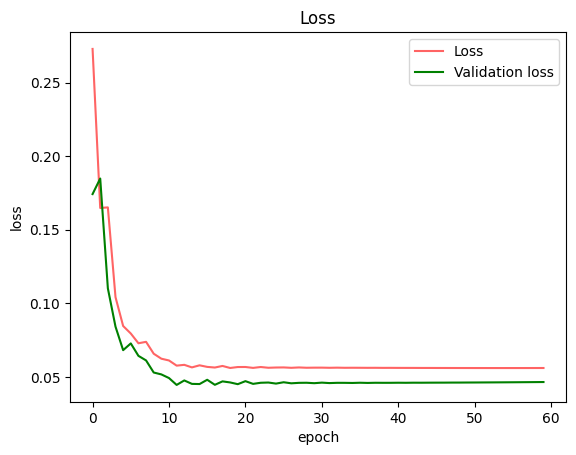

step 1, accuracy_train:0.378125, loss: 0.2572729914032406
step 2, accuracy_train:0.584375, loss: 0.16958010556308908
step 3, accuracy_train:0.75625, loss: 0.11813771227129585
step 4, accuracy_train:0.803125, loss: 0.09599139309627419
step 5, accuracy_train:0.834375, loss: 0.08434566701534421
step 6, accuracy_train:0.859375, loss: 0.07106221284305006
step 7, accuracy_train:0.8625, loss: 0.07137239683093553
step 8, accuracy_train:0.86875, loss: 0.06326344882705509
step 9, accuracy_train:0.859375, loss: 0.06434957842160578
step 10, accuracy_train:0.85625, loss: 0.06513152720326178
step 11, accuracy_train:0.8875, loss: 0.05777137981884724
step 12, accuracy_train:0.890625, loss: 0.05568030295263456
step 13, accuracy_train:0.878125, loss: 0.059515241213189185
step 14, accuracy_train:0.8875, loss: 0.05637041115121624
step 15, accuracy_train:0.884375, loss: 0.054489866600960085
step 16, accuracy_train:0.875, loss: 0.0576394342383416
step 17, accuracy_train:0.89375, loss: 0.053670403595363805
s

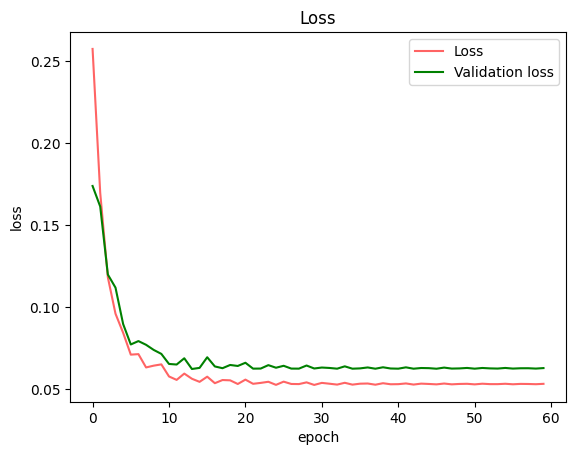

step 1, accuracy_train:0.446875, loss: 0.22622131630850273
step 2, accuracy_train:0.70625, loss: 0.12908023099421329
step 3, accuracy_train:0.771875, loss: 0.1084856382354869
step 4, accuracy_train:0.7875, loss: 0.09676175058430828
step 5, accuracy_train:0.846875, loss: 0.08252867578768479
step 6, accuracy_train:0.865625, loss: 0.07247931379490158
step 7, accuracy_train:0.846875, loss: 0.07070857178551633
step 8, accuracy_train:0.859375, loss: 0.07035066358425981
step 9, accuracy_train:0.878125, loss: 0.06868186044775666
step 10, accuracy_train:0.853125, loss: 0.07015854368376517
step 11, accuracy_train:0.859375, loss: 0.06897854525306035
step 12, accuracy_train:0.871875, loss: 0.06547851208760243
step 13, accuracy_train:0.88125, loss: 0.06442851558779071
step 14, accuracy_train:0.86875, loss: 0.06585797630406459
step 15, accuracy_train:0.859375, loss: 0.06473977722882648
step 16, accuracy_train:0.884375, loss: 0.05901291653770972
step 17, accuracy_train:0.88125, loss: 0.05735916340331

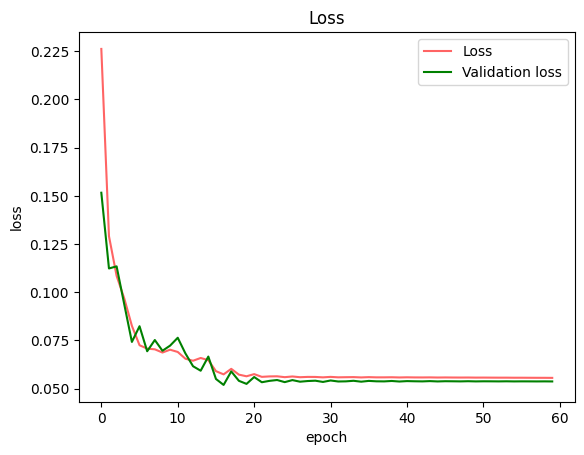

step 1, accuracy_train:0.44375, loss: 0.23334569827078058
step 2, accuracy_train:0.7125, loss: 0.13161546627561058
step 3, accuracy_train:0.753125, loss: 0.11295889713579756
step 4, accuracy_train:0.7875, loss: 0.09556267490408263
step 5, accuracy_train:0.8375, loss: 0.08622522485907338
step 6, accuracy_train:0.846875, loss: 0.07604058609554892
step 7, accuracy_train:0.85625, loss: 0.07066106557241479
step 8, accuracy_train:0.8625, loss: 0.06852475360082844
step 9, accuracy_train:0.875, loss: 0.07321894586133841
step 10, accuracy_train:0.85, loss: 0.07029602976041116
step 11, accuracy_train:0.86875, loss: 0.06750677397578586
step 12, accuracy_train:0.859375, loss: 0.06852873161456925
step 13, accuracy_train:0.853125, loss: 0.0691846006855295
step 14, accuracy_train:0.86875, loss: 0.06702760874100154
step 15, accuracy_train:0.884375, loss: 0.06320973742484169
step 16, accuracy_train:0.890625, loss: 0.06069760197976648
step 17, accuracy_train:0.890625, loss: 0.06021279001184168
step 18, 

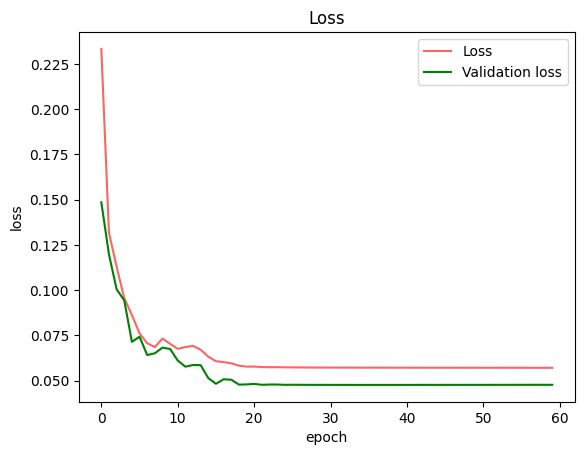

step 1, accuracy_train:0.46875, loss: 0.22592732700453713
step 2, accuracy_train:0.7125, loss: 0.12883770192310054
step 3, accuracy_train:0.71875, loss: 0.1162539598585526
step 4, accuracy_train:0.796875, loss: 0.09781345026316349
step 5, accuracy_train:0.8625, loss: 0.07723407811815775
step 6, accuracy_train:0.8625, loss: 0.07211022771982457
step 7, accuracy_train:0.88125, loss: 0.06634349519440054
step 8, accuracy_train:0.865625, loss: 0.06667851756684084
step 9, accuracy_train:0.884375, loss: 0.06585092721551206
step 10, accuracy_train:0.88125, loss: 0.06535747702022038
step 11, accuracy_train:0.859375, loss: 0.06871553631011061
step 12, accuracy_train:0.8625, loss: 0.06902373585390979
step 13, accuracy_train:0.871875, loss: 0.06785258133060502
step 14, accuracy_train:0.865625, loss: 0.06837259716645187
step 15, accuracy_train:0.878125, loss: 0.06868909047007668
step 16, accuracy_train:0.90625, loss: 0.054253514177693404
step 17, accuracy_train:0.915625, loss: 0.048913090601095985
s

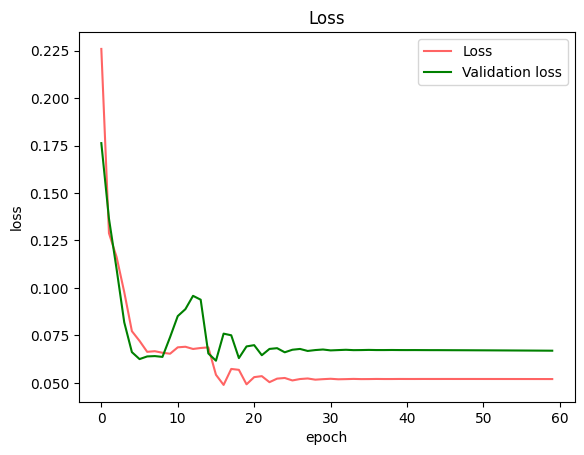

cv_time ：45.699848 s
((0.15, 0.05, 0.01), 60, 50, 50, (0.05, 0.03, 0.01))
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.209375, loss: 0.31553760276761933
step 2, accuracy_train:0.490625, loss: 0.22344700747688506
step 3, accuracy_train:0.721875, loss: 0.13527368490428082
step 4, accuracy_train:0.6375, loss: 0.18481643518751656
step 5, accuracy_train:0.784375, loss: 0.13916391606260706
step 6, accuracy_train:0.78125, loss: 0.10661748492607136
step 7, accuracy_train:0.753125, loss: 0.12242109120223747
step 8, accuracy_train:0.78125, loss: 0.10987154803135327
step 9, accuracy_train:0.771875, loss: 0.10264579420032609
step 10, accuracy_train:0.790625, loss: 0.10966589135013774
step 11, accuracy_train:0.803125, loss: 0.10529921161616655
step 12, accuracy_train:0.8, loss: 0.09833507020810803
step 13, accuracy_train:0.79375, loss: 0.09345695132334685
step 14, accuracy_train:0.834375, loss: 0.0809670283123637
step 15, accuracy_

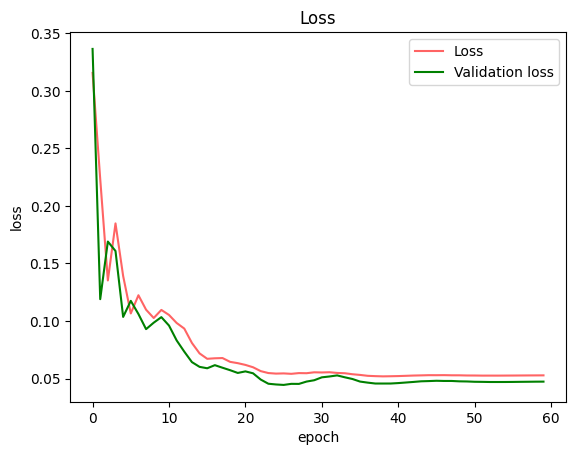

step 1, accuracy_train:0.209375, loss: 0.29963703609055314
step 2, accuracy_train:0.515625, loss: 0.21236264580309364
step 3, accuracy_train:0.496875, loss: 0.20697777558649288
step 4, accuracy_train:0.59375, loss: 0.21491655725144196
step 5, accuracy_train:0.725, loss: 0.12886432782105606
step 6, accuracy_train:0.78125, loss: 0.09908404802546511
step 7, accuracy_train:0.834375, loss: 0.09561033058762712
step 8, accuracy_train:0.846875, loss: 0.07437099227672979
step 9, accuracy_train:0.846875, loss: 0.07361661745634185
step 10, accuracy_train:0.88125, loss: 0.07061041016423902
step 11, accuracy_train:0.8625, loss: 0.06644647397225328
step 12, accuracy_train:0.853125, loss: 0.06775164366806916
step 13, accuracy_train:0.85, loss: 0.0691248696694163
step 14, accuracy_train:0.88125, loss: 0.06278209238855732
step 15, accuracy_train:0.89375, loss: 0.05798202371372015
step 16, accuracy_train:0.903125, loss: 0.05757643436555525
step 17, accuracy_train:0.9, loss: 0.05447920993018905
step 18, 

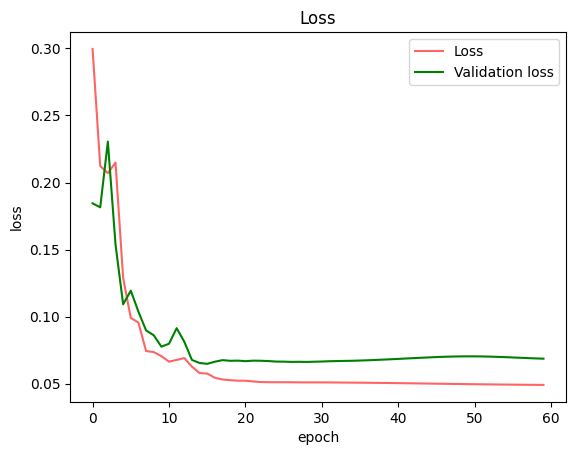

step 1, accuracy_train:0.240625, loss: 0.29881324104461227
step 2, accuracy_train:0.51875, loss: 0.21425019541556456
step 3, accuracy_train:0.53125, loss: 0.19926266581741764
step 4, accuracy_train:0.753125, loss: 0.1686281259449027
step 5, accuracy_train:0.753125, loss: 0.10483712296472425
step 6, accuracy_train:0.8125, loss: 0.0882138646114616
step 7, accuracy_train:0.853125, loss: 0.07846523827100152
step 8, accuracy_train:0.821875, loss: 0.07884799285906005
step 9, accuracy_train:0.784375, loss: 0.09595518411298579
step 10, accuracy_train:0.85, loss: 0.077332977016193
step 11, accuracy_train:0.88125, loss: 0.06568205477530045
step 12, accuracy_train:0.9, loss: 0.06731115109401267
step 13, accuracy_train:0.89375, loss: 0.06786530170020115
step 14, accuracy_train:0.875, loss: 0.06578996671207155
step 15, accuracy_train:0.884375, loss: 0.06528757137251218
step 16, accuracy_train:0.865625, loss: 0.06825565688468707
step 17, accuracy_train:0.84375, loss: 0.0705427891016545
step 18, accu

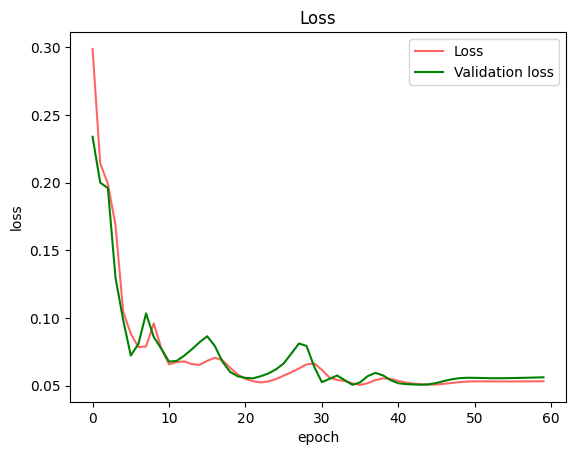

step 1, accuracy_train:0.228125, loss: 0.3031480301740891
step 2, accuracy_train:0.471875, loss: 0.22033670791678553
step 3, accuracy_train:0.584375, loss: 0.18780252955047255
step 4, accuracy_train:0.75625, loss: 0.15522491093245452
step 5, accuracy_train:0.765625, loss: 0.10106997840337875
step 6, accuracy_train:0.828125, loss: 0.09297111211179757
step 7, accuracy_train:0.83125, loss: 0.08701132907743858
step 8, accuracy_train:0.775, loss: 0.09562661308215784
step 9, accuracy_train:0.853125, loss: 0.08252441828685803
step 10, accuracy_train:0.890625, loss: 0.07186345619762566
step 11, accuracy_train:0.84375, loss: 0.07420014795577208
step 12, accuracy_train:0.846875, loss: 0.07219294494025641
step 13, accuracy_train:0.871875, loss: 0.0649309790092751
step 14, accuracy_train:0.8875, loss: 0.06155511575491715
step 15, accuracy_train:0.86875, loss: 0.06117243187098846
step 16, accuracy_train:0.859375, loss: 0.06449278322376366
step 17, accuracy_train:0.85625, loss: 0.06695408769066383
s

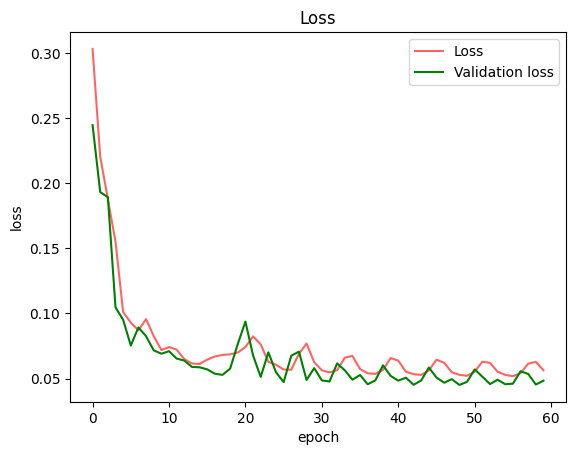

step 1, accuracy_train:0.221875, loss: 0.2917345207120513
step 2, accuracy_train:0.384375, loss: 0.24858335867020737
step 3, accuracy_train:0.396875, loss: 0.24732990988213638
step 4, accuracy_train:0.45625, loss: 0.24105985678923234
step 5, accuracy_train:0.6375, loss: 0.15660378968212746
step 6, accuracy_train:0.68125, loss: 0.12125165239153675
step 7, accuracy_train:0.75625, loss: 0.10501835108024543
step 8, accuracy_train:0.790625, loss: 0.09258002049846173
step 9, accuracy_train:0.815625, loss: 0.093319711778156
step 10, accuracy_train:0.828125, loss: 0.08956388308426749
step 11, accuracy_train:0.84375, loss: 0.0779192003759269
step 12, accuracy_train:0.8625, loss: 0.06965004321565935
step 13, accuracy_train:0.840625, loss: 0.06957222823862791
step 14, accuracy_train:0.85, loss: 0.06969962153406706
step 15, accuracy_train:0.853125, loss: 0.06584012463351689
step 16, accuracy_train:0.846875, loss: 0.06473603169602987
step 17, accuracy_train:0.84375, loss: 0.06663125492737995
step 1

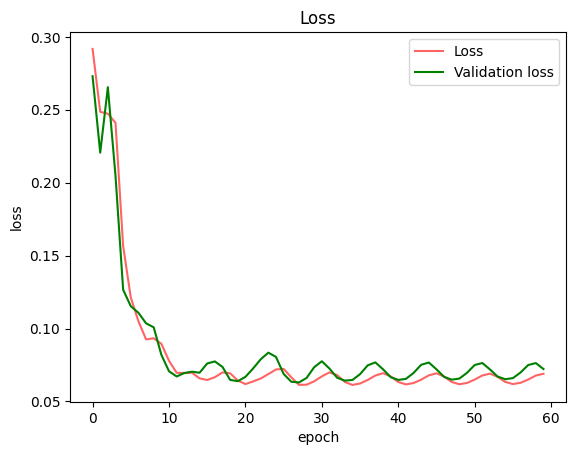

cv_time ：40.160228 s
((0.15, 0.05, 0.01), 60, 100, 50, (0.05, 0.03, 0.01))
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.41875, loss: 0.2996027579856552
step 2, accuracy_train:0.084375, loss: 0.28451090135138396
step 3, accuracy_train:0.534375, loss: 0.20927661571433723
step 4, accuracy_train:0.503125, loss: 0.21648672729678262
step 5, accuracy_train:0.54375, loss: 0.2146938796756972
step 6, accuracy_train:0.5, loss: 0.2493948928926591
step 7, accuracy_train:0.571875, loss: 0.2377412327519477
step 8, accuracy_train:0.609375, loss: 0.2001832331403447
step 9, accuracy_train:0.678125, loss: 0.14306214437401021
step 10, accuracy_train:0.70625, loss: 0.11368311755570955
step 11, accuracy_train:0.721875, loss: 0.12184049738123803
step 12, accuracy_train:0.746875, loss: 0.11218789065673704
step 13, accuracy_train:0.75, loss: 0.1064526571337776
step 14, accuracy_train:0.825, loss: 0.08580896119980722
step 15, accuracy_train:0.8

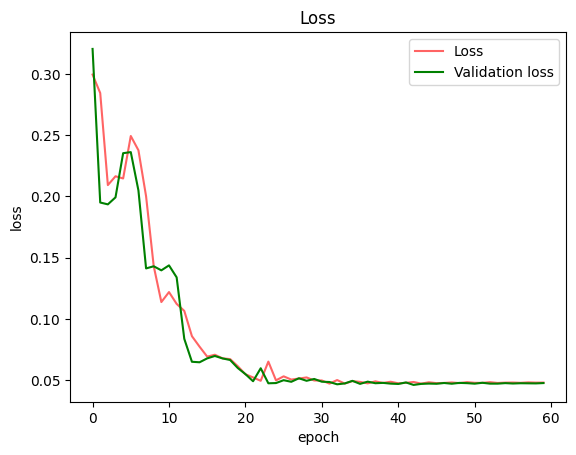

step 1, accuracy_train:0.403125, loss: 0.3004003718476602
step 2, accuracy_train:0.153125, loss: 0.2767697709528785
step 3, accuracy_train:0.528125, loss: 0.2114858934584729
step 4, accuracy_train:0.45, loss: 0.2200973067851845
step 5, accuracy_train:0.403125, loss: 0.23410372119027983
step 6, accuracy_train:0.578125, loss: 0.24400779270725104
step 7, accuracy_train:0.63125, loss: 0.21503367064441328
step 8, accuracy_train:0.6375, loss: 0.17705471000356546
step 9, accuracy_train:0.771875, loss: 0.11571092743140526
step 10, accuracy_train:0.7375, loss: 0.09795733075929018
step 11, accuracy_train:0.778125, loss: 0.10138665601741174
step 12, accuracy_train:0.778125, loss: 0.09653726357967324
step 13, accuracy_train:0.7875, loss: 0.09482100444945264
step 14, accuracy_train:0.8125, loss: 0.08597173175894146
step 15, accuracy_train:0.828125, loss: 0.09798046549374828
step 16, accuracy_train:0.859375, loss: 0.09735025992397173
step 17, accuracy_train:0.86875, loss: 0.08699121522407234
step 18

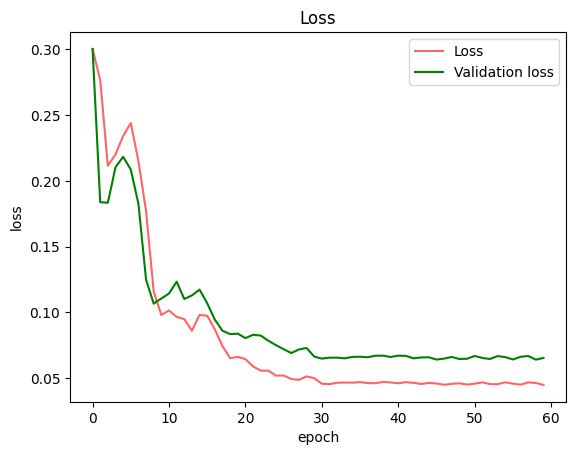

step 1, accuracy_train:0.409375, loss: 0.30052817955395233
step 2, accuracy_train:0.109375, loss: 0.2809481092131027
step 3, accuracy_train:0.53125, loss: 0.20863599853076717
step 4, accuracy_train:0.4875, loss: 0.21506192244328973
step 5, accuracy_train:0.534375, loss: 0.2163440410383231
step 6, accuracy_train:0.53125, loss: 0.24721457403876665
step 7, accuracy_train:0.609375, loss: 0.21989409171184682
step 8, accuracy_train:0.653125, loss: 0.1804942458534958
step 9, accuracy_train:0.740625, loss: 0.12495225775253124
step 10, accuracy_train:0.678125, loss: 0.11456369295017935
step 11, accuracy_train:0.684375, loss: 0.13160781081357542
step 12, accuracy_train:0.69375, loss: 0.1283637885623532
step 13, accuracy_train:0.7, loss: 0.1167144299283267
step 14, accuracy_train:0.784375, loss: 0.10187285183012847
step 15, accuracy_train:0.78125, loss: 0.09315923924484798
step 16, accuracy_train:0.78125, loss: 0.10031754444425986
step 17, accuracy_train:0.8, loss: 0.11525930362085401
step 18, ac

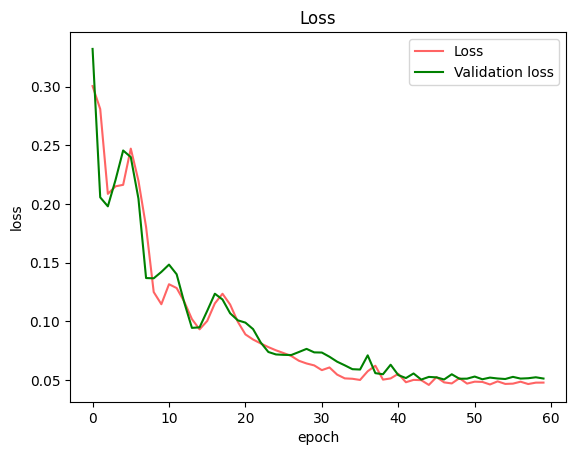

step 1, accuracy_train:0.4, loss: 0.3001963735530797
step 2, accuracy_train:0.103125, loss: 0.28306743846007043
step 3, accuracy_train:0.521875, loss: 0.20854250447712994
step 4, accuracy_train:0.44375, loss: 0.21792044295670904
step 5, accuracy_train:0.49375, loss: 0.22123266582895088
step 6, accuracy_train:0.56875, loss: 0.24459989903852536
step 7, accuracy_train:0.625, loss: 0.2122143791800059
step 8, accuracy_train:0.665625, loss: 0.17354563140976043
step 9, accuracy_train:0.74375, loss: 0.12149251814110013
step 10, accuracy_train:0.6875, loss: 0.11262004736777972
step 11, accuracy_train:0.684375, loss: 0.12822716756895544
step 12, accuracy_train:0.703125, loss: 0.12569140949561128
step 13, accuracy_train:0.746875, loss: 0.10340162190166001
step 14, accuracy_train:0.796875, loss: 0.09515923109769187
step 15, accuracy_train:0.7875, loss: 0.09640974765687657
step 16, accuracy_train:0.7875, loss: 0.10690966304414987
step 17, accuracy_train:0.80625, loss: 0.11703316601611474
step 18, a

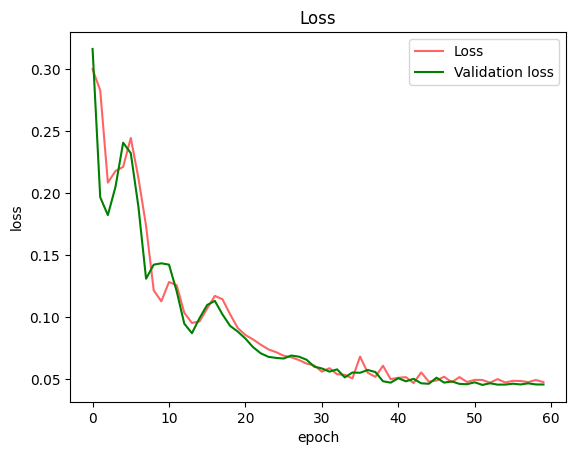

step 1, accuracy_train:0.384375, loss: 0.3019097648892094
step 2, accuracy_train:0.115625, loss: 0.2809900532656967
step 3, accuracy_train:0.496875, loss: 0.2525101386612497
step 4, accuracy_train:0.55, loss: 0.19244216790543311
step 5, accuracy_train:0.446875, loss: 0.2134501494330688
step 6, accuracy_train:0.46875, loss: 0.25092338908298706
step 7, accuracy_train:0.44375, loss: 0.25333025187610614
step 8, accuracy_train:0.525, loss: 0.220120381256336
step 9, accuracy_train:0.546875, loss: 0.18015973787260922
step 10, accuracy_train:0.53125, loss: 0.15804557406206252
step 11, accuracy_train:0.675, loss: 0.1512347568003288
step 12, accuracy_train:0.73125, loss: 0.1423447421557253
step 13, accuracy_train:0.7375, loss: 0.1326746534984673
step 14, accuracy_train:0.73125, loss: 0.12338973177997214
step 15, accuracy_train:0.734375, loss: 0.12569026172924624
step 16, accuracy_train:0.73125, loss: 0.13464342494178078
step 17, accuracy_train:0.715625, loss: 0.1522460916242424
step 18, accuracy

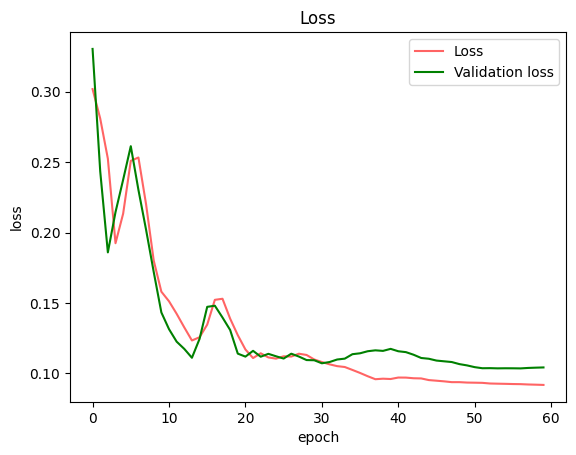

cv_time ：40.118604 s
((0.15, 0.05, 0.01), 60, 300, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.3625, loss: 0.2729045606157341
step 2, accuracy_train:0.609375, loss: 0.16478452828493406
step 3, accuracy_train:0.721875, loss: 0.16517886844838647
step 4, accuracy_train:0.778125, loss: 0.10417404073383049
step 5, accuracy_train:0.803125, loss: 0.08455728643215173
step 6, accuracy_train:0.853125, loss: 0.07944652589678186
step 7, accuracy_train:0.865625, loss: 0.07281630755699903
step 8, accuracy_train:0.846875, loss: 0.07379023425711986
step 9, accuracy_train:0.853125, loss: 0.06570998599724022
step 10, accuracy_train:0.88125, loss: 0.0623276295007137
step 11, accuracy_train:0.8875, loss: 0.061115320605870355
step 12, accuracy_train:0.903125, loss: 0.05761224315515854
step 13, accuracy_train:0.884375, loss: 0.058153841669436025
step 14, accuracy_train:0.890625, loss: 0.05641637498178877
step 15, accuracy_train:0.884375, loss: 0.057825900600293245
step 16, accuracy_train:0.8875, loss: 

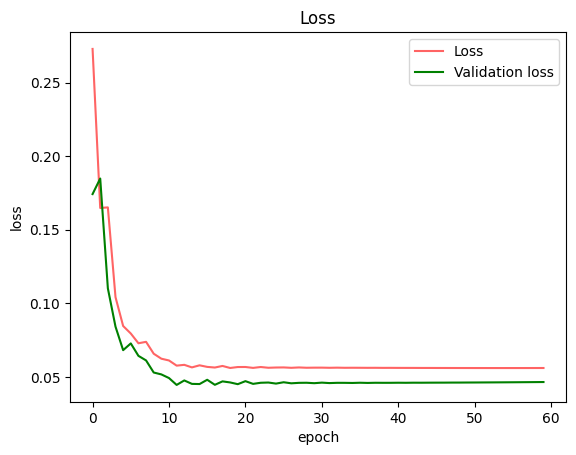

step 1, accuracy_train:0.378125, loss: 0.2572729914032406
step 2, accuracy_train:0.584375, loss: 0.16958010556308908
step 3, accuracy_train:0.75625, loss: 0.11813771227129585
step 4, accuracy_train:0.803125, loss: 0.09599139309627419
step 5, accuracy_train:0.834375, loss: 0.08434566701534421
step 6, accuracy_train:0.859375, loss: 0.07106221284305006
step 7, accuracy_train:0.8625, loss: 0.07137239683093553
step 8, accuracy_train:0.86875, loss: 0.06326344882705509
step 9, accuracy_train:0.859375, loss: 0.06434957842160578
step 10, accuracy_train:0.85625, loss: 0.06513152720326178
step 11, accuracy_train:0.8875, loss: 0.05777137981884724
step 12, accuracy_train:0.890625, loss: 0.05568030295263456
step 13, accuracy_train:0.878125, loss: 0.059515241213189185
step 14, accuracy_train:0.8875, loss: 0.05637041115121624
step 15, accuracy_train:0.884375, loss: 0.054489866600960085
step 16, accuracy_train:0.875, loss: 0.0576394342383416
step 17, accuracy_train:0.89375, loss: 0.053670403595363805
s

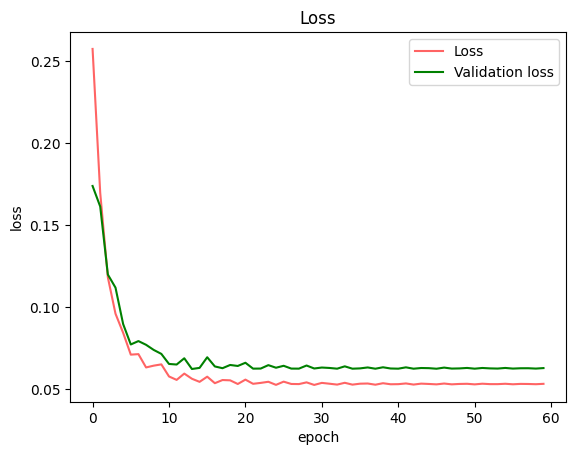

step 1, accuracy_train:0.446875, loss: 0.22622131630850273
step 2, accuracy_train:0.70625, loss: 0.12908023099421329
step 3, accuracy_train:0.771875, loss: 0.1084856382354869
step 4, accuracy_train:0.7875, loss: 0.09676175058430828
step 5, accuracy_train:0.846875, loss: 0.08252867578768479
step 6, accuracy_train:0.865625, loss: 0.07247931379490158
step 7, accuracy_train:0.846875, loss: 0.07070857178551633
step 8, accuracy_train:0.859375, loss: 0.07035066358425981
step 9, accuracy_train:0.878125, loss: 0.06868186044775666
step 10, accuracy_train:0.853125, loss: 0.07015854368376517
step 11, accuracy_train:0.859375, loss: 0.06897854525306035
step 12, accuracy_train:0.871875, loss: 0.06547851208760243
step 13, accuracy_train:0.88125, loss: 0.06442851558779071
step 14, accuracy_train:0.86875, loss: 0.06585797630406459
step 15, accuracy_train:0.859375, loss: 0.06473977722882648
step 16, accuracy_train:0.884375, loss: 0.05901291653770972
step 17, accuracy_train:0.88125, loss: 0.05735916340331

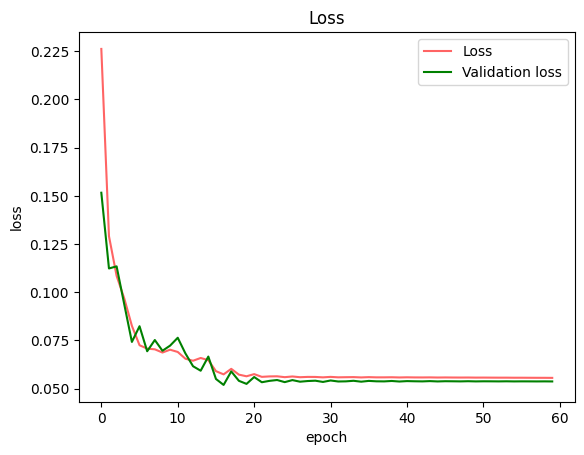

step 1, accuracy_train:0.44375, loss: 0.23334569827078058
step 2, accuracy_train:0.7125, loss: 0.13161546627561058
step 3, accuracy_train:0.753125, loss: 0.11295889713579756
step 4, accuracy_train:0.7875, loss: 0.09556267490408263
step 5, accuracy_train:0.8375, loss: 0.08622522485907338
step 6, accuracy_train:0.846875, loss: 0.07604058609554892
step 7, accuracy_train:0.85625, loss: 0.07066106557241479
step 8, accuracy_train:0.8625, loss: 0.06852475360082844
step 9, accuracy_train:0.875, loss: 0.07321894586133841
step 10, accuracy_train:0.85, loss: 0.07029602976041116
step 11, accuracy_train:0.86875, loss: 0.06750677397578586
step 12, accuracy_train:0.859375, loss: 0.06852873161456925
step 13, accuracy_train:0.853125, loss: 0.0691846006855295
step 14, accuracy_train:0.86875, loss: 0.06702760874100154
step 15, accuracy_train:0.884375, loss: 0.06320973742484169
step 16, accuracy_train:0.890625, loss: 0.06069760197976648
step 17, accuracy_train:0.890625, loss: 0.06021279001184168
step 18, 

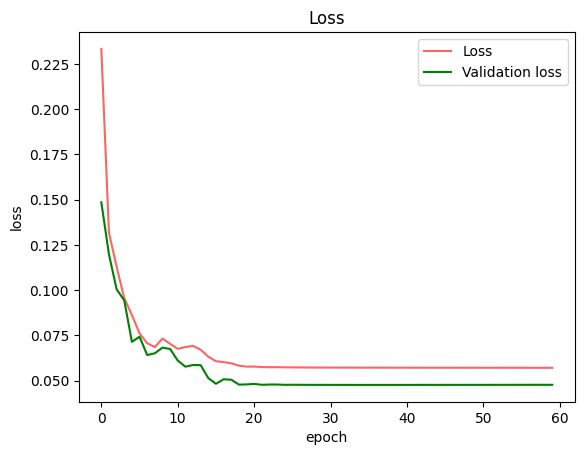

step 1, accuracy_train:0.46875, loss: 0.22592732700453713
step 2, accuracy_train:0.7125, loss: 0.12883770192310054
step 3, accuracy_train:0.71875, loss: 0.1162539598585526
step 4, accuracy_train:0.796875, loss: 0.09781345026316349
step 5, accuracy_train:0.8625, loss: 0.07723407811815775
step 6, accuracy_train:0.8625, loss: 0.07211022771982457
step 7, accuracy_train:0.88125, loss: 0.06634349519440054
step 8, accuracy_train:0.865625, loss: 0.06667851756684084
step 9, accuracy_train:0.884375, loss: 0.06585092721551206
step 10, accuracy_train:0.88125, loss: 0.06535747702022038
step 11, accuracy_train:0.859375, loss: 0.06871553631011061
step 12, accuracy_train:0.8625, loss: 0.06902373585390979
step 13, accuracy_train:0.871875, loss: 0.06785258133060502
step 14, accuracy_train:0.865625, loss: 0.06837259716645187
step 15, accuracy_train:0.878125, loss: 0.06868909047007668
step 16, accuracy_train:0.90625, loss: 0.054253514177693404
step 17, accuracy_train:0.915625, loss: 0.048913090601095985
s

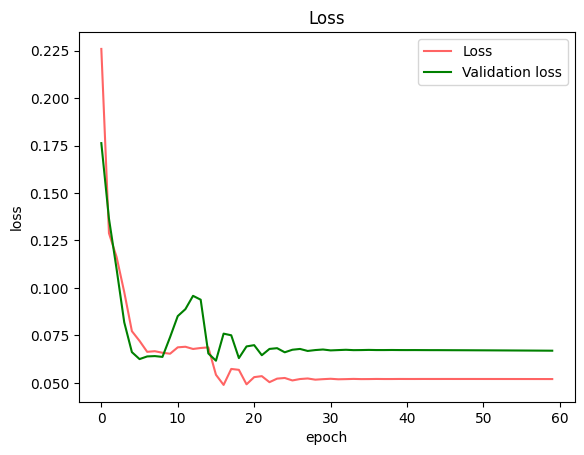

cv_time ：40.125670 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 50, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.209375, loss: 0.31553760276761933
step 2, accuracy_train:0.490625, loss: 0.22344700747688506
step 3, accuracy_train:0.721875, loss: 0.13527368490428082
step 4, accuracy_train:0.6375, loss: 0.18481643518751656
step 5, accuracy_train:0.784375, loss: 0.13916391606260706
step 6, accuracy_train:0.78125, loss: 0.10661748492607136
step 7, accuracy_train:0.753125, loss: 0.12242109120223747
step 8, accuracy_train:0.78125, loss: 0.10987154803135327
step 9, accuracy_train:0.771875, loss: 0.10264579420032609
step 10, accuracy_train:0.790625, loss: 0.10966589135013774
step 11, accuracy_train:0.803125, loss: 0.10529921161616655
step 12, accuracy_train:0.8, loss: 0.09833507020810803
step 13, accuracy_train:0.79375, loss: 0.09345695132334685
step 14, accuracy_train:0.834375, loss: 0.0809670283123637
step 15, accuracy_train:0.8625, loss: 0.0718950746963111
step 16, accuracy_train:0.86875, l

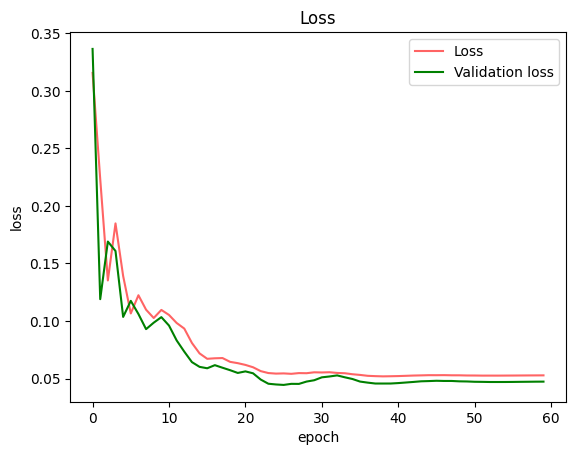

step 1, accuracy_train:0.209375, loss: 0.29963703609055314
step 2, accuracy_train:0.515625, loss: 0.21236264580309364
step 3, accuracy_train:0.496875, loss: 0.20697777558649288
step 4, accuracy_train:0.59375, loss: 0.21491655725144196
step 5, accuracy_train:0.725, loss: 0.12886432782105606
step 6, accuracy_train:0.78125, loss: 0.09908404802546511
step 7, accuracy_train:0.834375, loss: 0.09561033058762712
step 8, accuracy_train:0.846875, loss: 0.07437099227672979
step 9, accuracy_train:0.846875, loss: 0.07361661745634185
step 10, accuracy_train:0.88125, loss: 0.07061041016423902
step 11, accuracy_train:0.8625, loss: 0.06644647397225328
step 12, accuracy_train:0.853125, loss: 0.06775164366806916
step 13, accuracy_train:0.85, loss: 0.0691248696694163
step 14, accuracy_train:0.88125, loss: 0.06278209238855732
step 15, accuracy_train:0.89375, loss: 0.05798202371372015
step 16, accuracy_train:0.903125, loss: 0.05757643436555525
step 17, accuracy_train:0.9, loss: 0.05447920993018905
step 18, 

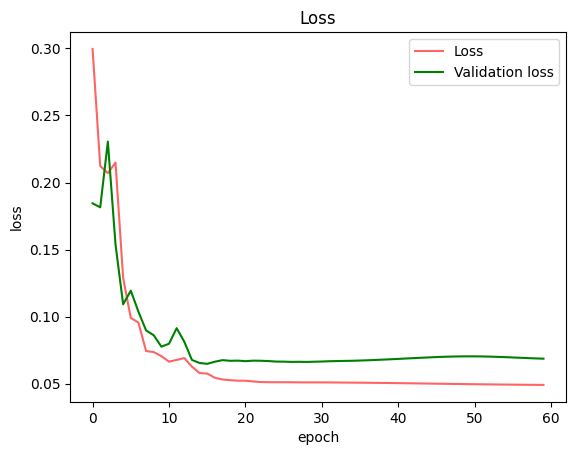

step 1, accuracy_train:0.240625, loss: 0.29881324104461227
step 2, accuracy_train:0.51875, loss: 0.21425019541556456
step 3, accuracy_train:0.53125, loss: 0.19926266581741764
step 4, accuracy_train:0.753125, loss: 0.1686281259449027
step 5, accuracy_train:0.753125, loss: 0.10483712296472425
step 6, accuracy_train:0.8125, loss: 0.0882138646114616
step 7, accuracy_train:0.853125, loss: 0.07846523827100152
step 8, accuracy_train:0.821875, loss: 0.07884799285906005
step 9, accuracy_train:0.784375, loss: 0.09595518411298579
step 10, accuracy_train:0.85, loss: 0.077332977016193
step 11, accuracy_train:0.88125, loss: 0.06568205477530045
step 12, accuracy_train:0.9, loss: 0.06731115109401267
step 13, accuracy_train:0.89375, loss: 0.06786530170020115
step 14, accuracy_train:0.875, loss: 0.06578996671207155
step 15, accuracy_train:0.884375, loss: 0.06528757137251218
step 16, accuracy_train:0.865625, loss: 0.06825565688468707
step 17, accuracy_train:0.84375, loss: 0.0705427891016545
step 18, accu

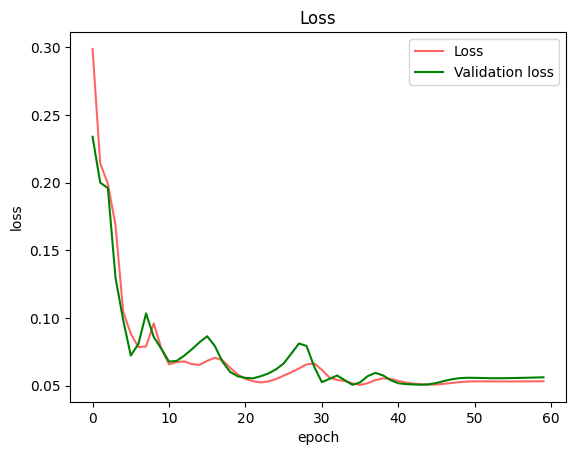

step 1, accuracy_train:0.228125, loss: 0.3031480301740891
step 2, accuracy_train:0.471875, loss: 0.22033670791678553
step 3, accuracy_train:0.584375, loss: 0.18780252955047255
step 4, accuracy_train:0.75625, loss: 0.15522491093245452
step 5, accuracy_train:0.765625, loss: 0.10106997840337875
step 6, accuracy_train:0.828125, loss: 0.09297111211179757
step 7, accuracy_train:0.83125, loss: 0.08701132907743858
step 8, accuracy_train:0.775, loss: 0.09562661308215784
step 9, accuracy_train:0.853125, loss: 0.08252441828685803
step 10, accuracy_train:0.890625, loss: 0.07186345619762566
step 11, accuracy_train:0.84375, loss: 0.07420014795577208
step 12, accuracy_train:0.846875, loss: 0.07219294494025641
step 13, accuracy_train:0.871875, loss: 0.0649309790092751
step 14, accuracy_train:0.8875, loss: 0.06155511575491715
step 15, accuracy_train:0.86875, loss: 0.06117243187098846
step 16, accuracy_train:0.859375, loss: 0.06449278322376366
step 17, accuracy_train:0.85625, loss: 0.06695408769066383
s

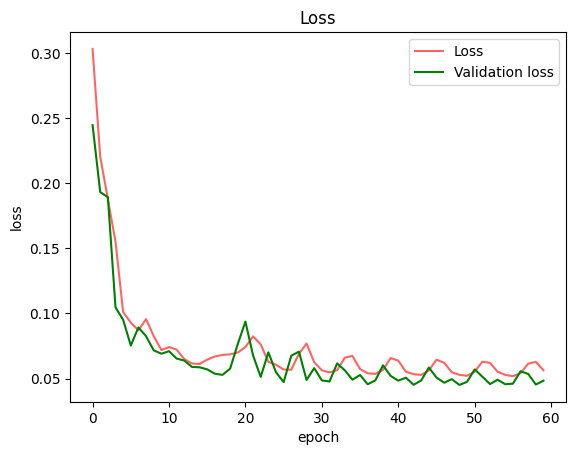

step 1, accuracy_train:0.221875, loss: 0.2917345207120513
step 2, accuracy_train:0.384375, loss: 0.24858335867020737
step 3, accuracy_train:0.396875, loss: 0.24732990988213638
step 4, accuracy_train:0.45625, loss: 0.24105985678923234
step 5, accuracy_train:0.6375, loss: 0.15660378968212746
step 6, accuracy_train:0.68125, loss: 0.12125165239153675
step 7, accuracy_train:0.75625, loss: 0.10501835108024543
step 8, accuracy_train:0.790625, loss: 0.09258002049846173
step 9, accuracy_train:0.815625, loss: 0.093319711778156
step 10, accuracy_train:0.828125, loss: 0.08956388308426749
step 11, accuracy_train:0.84375, loss: 0.0779192003759269
step 12, accuracy_train:0.8625, loss: 0.06965004321565935
step 13, accuracy_train:0.840625, loss: 0.06957222823862791
step 14, accuracy_train:0.85, loss: 0.06969962153406706
step 15, accuracy_train:0.853125, loss: 0.06584012463351689
step 16, accuracy_train:0.846875, loss: 0.06473603169602987
step 17, accuracy_train:0.84375, loss: 0.06663125492737995
step 1

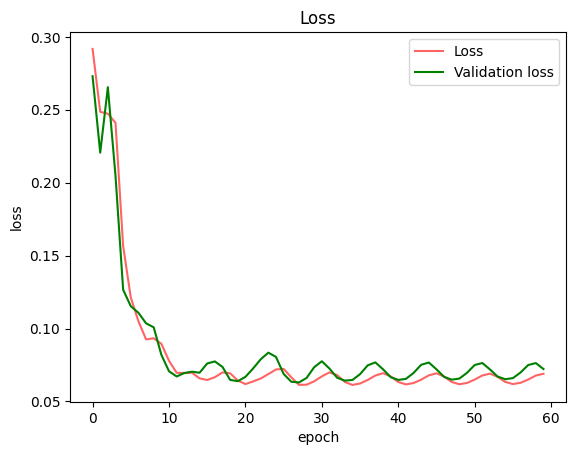

cv_time ：38.214744 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 100, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.41875, loss: 0.2996027579856552
step 2, accuracy_train:0.084375, loss: 0.28451090135138396
step 3, accuracy_train:0.534375, loss: 0.20927661571433723
step 4, accuracy_train:0.503125, loss: 0.21648672729678262
step 5, accuracy_train:0.54375, loss: 0.2146938796756972
step 6, accuracy_train:0.5, loss: 0.2493948928926591
step 7, accuracy_train:0.571875, loss: 0.2377412327519477
step 8, accuracy_train:0.609375, loss: 0.2001832331403447
step 9, accuracy_train:0.678125, loss: 0.14306214437401021
step 10, accuracy_train:0.70625, loss: 0.11368311755570955
step 11, accuracy_train:0.721875, loss: 0.12184049738123803
step 12, accuracy_train:0.746875, loss: 0.11218789065673704
step 13, accuracy_train:0.75, loss: 0.1064526571337776
step 14, accuracy_train:0.825, loss: 0.08580896119980722
step 15, accuracy_train:0.859375, loss: 0.07720322022983281
step 16, accuracy_train:0.865625, loss: 

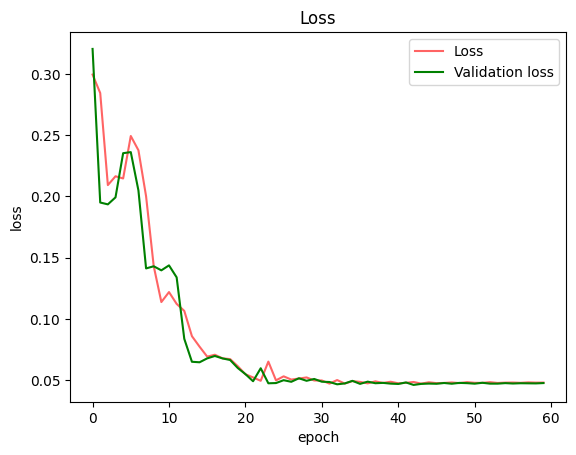

step 1, accuracy_train:0.403125, loss: 0.3004003718476602
step 2, accuracy_train:0.153125, loss: 0.2767697709528785
step 3, accuracy_train:0.528125, loss: 0.2114858934584729
step 4, accuracy_train:0.45, loss: 0.2200973067851845
step 5, accuracy_train:0.403125, loss: 0.23410372119027983
step 6, accuracy_train:0.578125, loss: 0.24400779270725104
step 7, accuracy_train:0.63125, loss: 0.21503367064441328
step 8, accuracy_train:0.6375, loss: 0.17705471000356546
step 9, accuracy_train:0.771875, loss: 0.11571092743140526
step 10, accuracy_train:0.7375, loss: 0.09795733075929018
step 11, accuracy_train:0.778125, loss: 0.10138665601741174
step 12, accuracy_train:0.778125, loss: 0.09653726357967324
step 13, accuracy_train:0.7875, loss: 0.09482100444945264
step 14, accuracy_train:0.8125, loss: 0.08597173175894146
step 15, accuracy_train:0.828125, loss: 0.09798046549374828
step 16, accuracy_train:0.859375, loss: 0.09735025992397173
step 17, accuracy_train:0.86875, loss: 0.08699121522407234
step 18

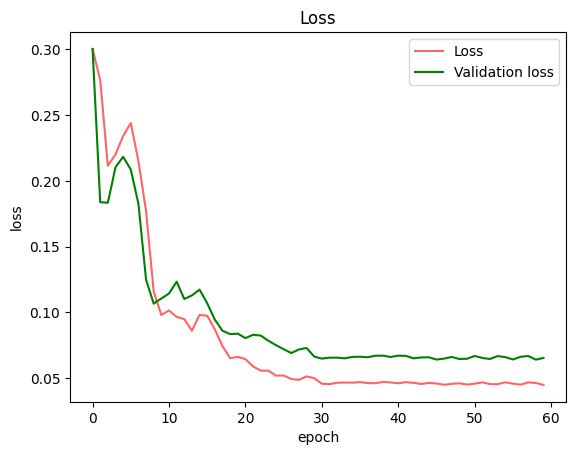

step 1, accuracy_train:0.409375, loss: 0.30052817955395233
step 2, accuracy_train:0.109375, loss: 0.2809481092131027
step 3, accuracy_train:0.53125, loss: 0.20863599853076717
step 4, accuracy_train:0.4875, loss: 0.21506192244328973
step 5, accuracy_train:0.534375, loss: 0.2163440410383231
step 6, accuracy_train:0.53125, loss: 0.24721457403876665
step 7, accuracy_train:0.609375, loss: 0.21989409171184682
step 8, accuracy_train:0.653125, loss: 0.1804942458534958
step 9, accuracy_train:0.740625, loss: 0.12495225775253124
step 10, accuracy_train:0.678125, loss: 0.11456369295017935
step 11, accuracy_train:0.684375, loss: 0.13160781081357542
step 12, accuracy_train:0.69375, loss: 0.1283637885623532
step 13, accuracy_train:0.7, loss: 0.1167144299283267
step 14, accuracy_train:0.784375, loss: 0.10187285183012847
step 15, accuracy_train:0.78125, loss: 0.09315923924484798
step 16, accuracy_train:0.78125, loss: 0.10031754444425986
step 17, accuracy_train:0.8, loss: 0.11525930362085401
step 18, ac

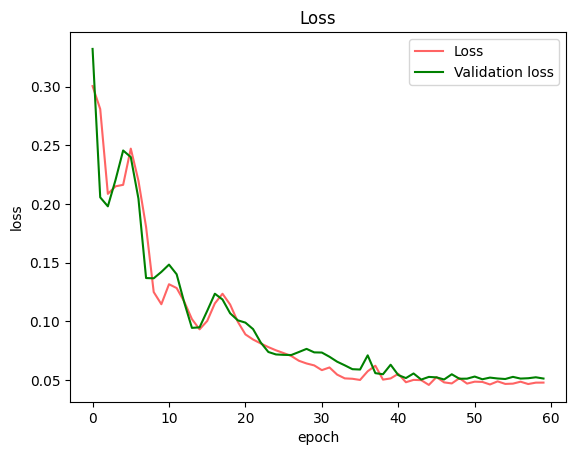

step 1, accuracy_train:0.4, loss: 0.3001963735530797
step 2, accuracy_train:0.103125, loss: 0.28306743846007043
step 3, accuracy_train:0.521875, loss: 0.20854250447712994
step 4, accuracy_train:0.44375, loss: 0.21792044295670904
step 5, accuracy_train:0.49375, loss: 0.22123266582895088
step 6, accuracy_train:0.56875, loss: 0.24459989903852536
step 7, accuracy_train:0.625, loss: 0.2122143791800059
step 8, accuracy_train:0.665625, loss: 0.17354563140976043
step 9, accuracy_train:0.74375, loss: 0.12149251814110013
step 10, accuracy_train:0.6875, loss: 0.11262004736777972
step 11, accuracy_train:0.684375, loss: 0.12822716756895544
step 12, accuracy_train:0.703125, loss: 0.12569140949561128
step 13, accuracy_train:0.746875, loss: 0.10340162190166001
step 14, accuracy_train:0.796875, loss: 0.09515923109769187
step 15, accuracy_train:0.7875, loss: 0.09640974765687657
step 16, accuracy_train:0.7875, loss: 0.10690966304414987
step 17, accuracy_train:0.80625, loss: 0.11703316601611474
step 18, a

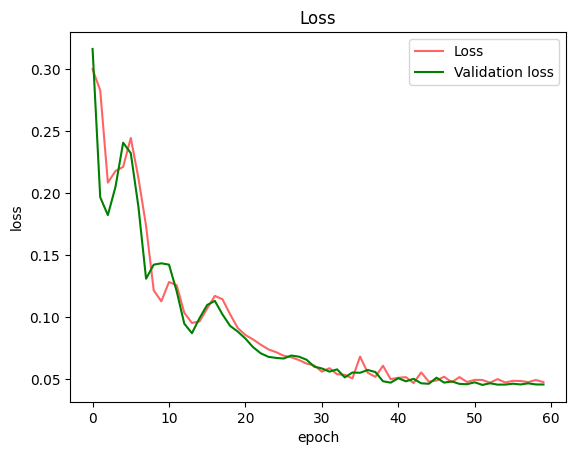

step 1, accuracy_train:0.384375, loss: 0.3019097648892094
step 2, accuracy_train:0.115625, loss: 0.2809900532656967
step 3, accuracy_train:0.496875, loss: 0.2525101386612497
step 4, accuracy_train:0.55, loss: 0.19244216790543311
step 5, accuracy_train:0.446875, loss: 0.2134501494330688
step 6, accuracy_train:0.46875, loss: 0.25092338908298706
step 7, accuracy_train:0.44375, loss: 0.25333025187610614
step 8, accuracy_train:0.525, loss: 0.220120381256336
step 9, accuracy_train:0.546875, loss: 0.18015973787260922
step 10, accuracy_train:0.53125, loss: 0.15804557406206252
step 11, accuracy_train:0.675, loss: 0.1512347568003288
step 12, accuracy_train:0.73125, loss: 0.1423447421557253
step 13, accuracy_train:0.7375, loss: 0.1326746534984673
step 14, accuracy_train:0.73125, loss: 0.12338973177997214
step 15, accuracy_train:0.734375, loss: 0.12569026172924624
step 16, accuracy_train:0.73125, loss: 0.13464342494178078
step 17, accuracy_train:0.715625, loss: 0.1522460916242424
step 18, accuracy

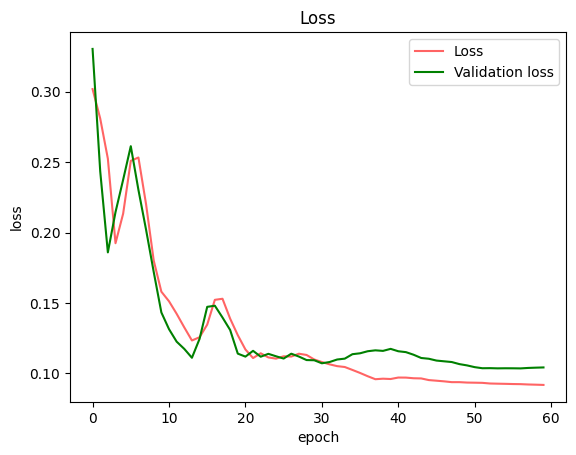

cv_time ：36.028576 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 300, 50, (0.05, 0.03, 0.01))


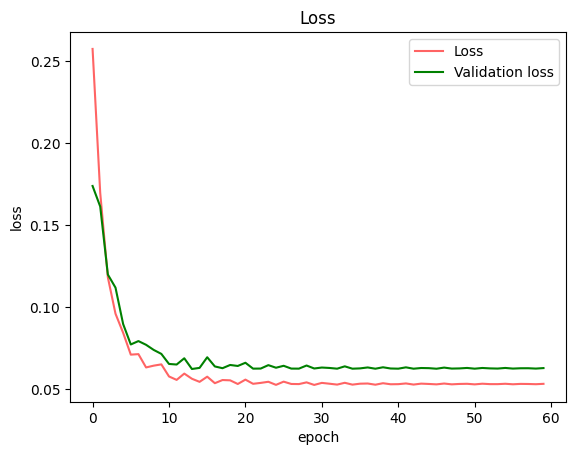

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.49375, loss: 0.24385480841845822
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 2, accuracy_train:0.734375, loss: 0.17187431949518298
step 3, accuracy_train:0.753125, loss: 0.1233850996449161
step 4, accuracy_train:0.790625, loss: 0.09246953435954801
step 5, accuracy_train:0.778125, loss: 0.088447010462935
step 6, accuracy_train:0.796875, loss: 0.0841095220102762
step 7, accuracy_train:0.825, loss: 0.08160534436589306
step 8, accuracy_train:0.7875, loss: 0.08443524204353244
step 9, accuracy_train:0.8125, loss: 0.07489903627161856
step 10, accuracy_train:0.81875, loss: 0.07000338935795485
step 11, accuracy_train:0.834375, loss: 0.06868838287810368
step 12, accuracy_train:0.840625, loss: 0.06667369252727956
step 13, accuracy_train:0.840625, loss

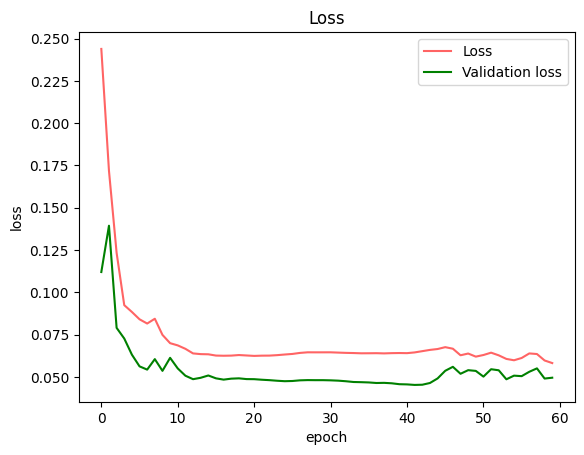

step 1, accuracy_train:0.61875, loss: 0.23671959385486532
step 2, accuracy_train:0.7375, loss: 0.16685522512799678
step 3, accuracy_train:0.78125, loss: 0.13483073578825813
step 4, accuracy_train:0.771875, loss: 0.08923661720275271
step 5, accuracy_train:0.821875, loss: 0.08145972864892946
step 6, accuracy_train:0.83125, loss: 0.07701208967068425
step 7, accuracy_train:0.815625, loss: 0.0767578766727865
step 8, accuracy_train:0.778125, loss: 0.08572114936163451
step 9, accuracy_train:0.778125, loss: 0.08310421098016303
step 10, accuracy_train:0.840625, loss: 0.077670625895162
step 11, accuracy_train:0.809375, loss: 0.07178485720249252
step 12, accuracy_train:0.8375, loss: 0.06795556003834637
step 13, accuracy_train:0.846875, loss: 0.06884404748604095
step 14, accuracy_train:0.84375, loss: 0.0671889057595581
step 15, accuracy_train:0.825, loss: 0.07083238437642013
step 16, accuracy_train:0.8125, loss: 0.07612016008810718
step 17, accuracy_train:0.821875, loss: 0.07520757537016381
step 1

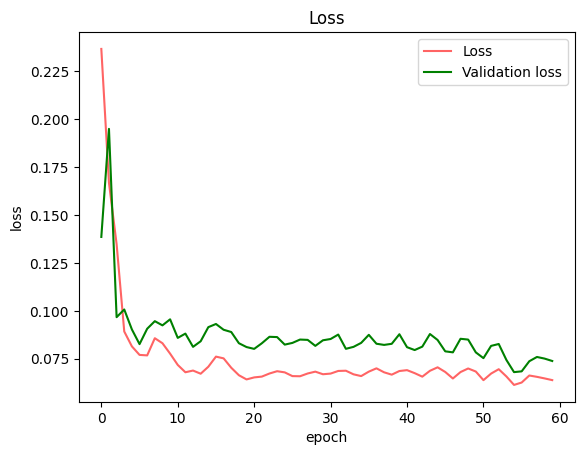

step 1, accuracy_train:0.63125, loss: 0.23308371465358343
step 2, accuracy_train:0.73125, loss: 0.1751589063890511
step 3, accuracy_train:0.796875, loss: 0.13148626765933646
step 4, accuracy_train:0.7875, loss: 0.08441492175669847
step 5, accuracy_train:0.828125, loss: 0.07412396254300312
step 6, accuracy_train:0.84375, loss: 0.06938256853908163
step 7, accuracy_train:0.853125, loss: 0.06433934180589145
step 8, accuracy_train:0.846875, loss: 0.06346391263576975
step 9, accuracy_train:0.84375, loss: 0.06286019943332295
step 10, accuracy_train:0.8625, loss: 0.05967663591350262
step 11, accuracy_train:0.871875, loss: 0.05850002397139607
step 12, accuracy_train:0.871875, loss: 0.058090993130835336
step 13, accuracy_train:0.875, loss: 0.05715258719354075
step 14, accuracy_train:0.875, loss: 0.05716040719587216
step 15, accuracy_train:0.865625, loss: 0.056715773689853984
step 16, accuracy_train:0.86875, loss: 0.056516396848071866
step 17, accuracy_train:0.871875, loss: 0.057115205909062584
s

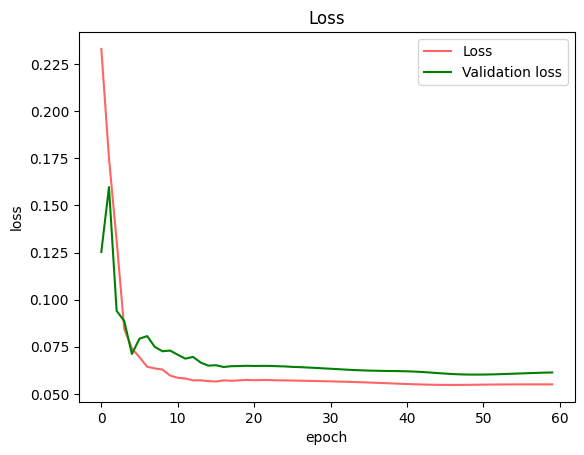

step 1, accuracy_train:0.60625, loss: 0.23950305421107912
step 2, accuracy_train:0.790625, loss: 0.14536106161975987
step 3, accuracy_train:0.80625, loss: 0.09728402438398429
step 4, accuracy_train:0.796875, loss: 0.08080103948702416
step 5, accuracy_train:0.853125, loss: 0.07533160257610673
step 6, accuracy_train:0.853125, loss: 0.07375133803964139
step 7, accuracy_train:0.825, loss: 0.07273061702202499
step 8, accuracy_train:0.815625, loss: 0.0742741172462958
step 9, accuracy_train:0.81875, loss: 0.07569926630858831
step 10, accuracy_train:0.85, loss: 0.07360148965238457
step 11, accuracy_train:0.8375, loss: 0.07291995357851587
step 12, accuracy_train:0.821875, loss: 0.07524063724660653
step 13, accuracy_train:0.815625, loss: 0.07427887653546632
step 14, accuracy_train:0.821875, loss: 0.07438865324352217
step 15, accuracy_train:0.859375, loss: 0.07189645001199198
step 16, accuracy_train:0.846875, loss: 0.07162609090818278
step 17, accuracy_train:0.828125, loss: 0.07268343869529884
st

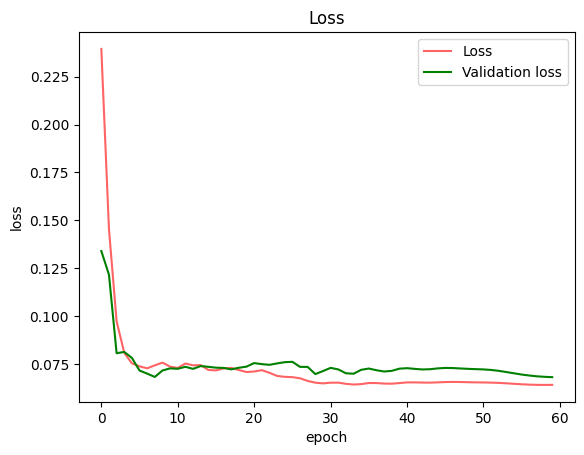

step 1, accuracy_train:0.640625, loss: 0.23206009317689869
step 2, accuracy_train:0.80625, loss: 0.15803861726810348
step 3, accuracy_train:0.721875, loss: 0.1334063546741588
step 4, accuracy_train:0.759375, loss: 0.0948942194523198
step 5, accuracy_train:0.8375, loss: 0.08598584369362322
step 6, accuracy_train:0.790625, loss: 0.08244186574382602
step 7, accuracy_train:0.796875, loss: 0.08357646301908749
step 8, accuracy_train:0.809375, loss: 0.08464501150441074
step 9, accuracy_train:0.821875, loss: 0.08087616766150643
step 10, accuracy_train:0.80625, loss: 0.0728106492369136
step 11, accuracy_train:0.8375, loss: 0.06820179800017441
step 12, accuracy_train:0.834375, loss: 0.07256067951056647
step 13, accuracy_train:0.815625, loss: 0.07255207184800815
step 14, accuracy_train:0.83125, loss: 0.07178150256304282
step 15, accuracy_train:0.821875, loss: 0.07558799346554193
step 16, accuracy_train:0.828125, loss: 0.0754254258614425
step 17, accuracy_train:0.8125, loss: 0.07667735062089319
st

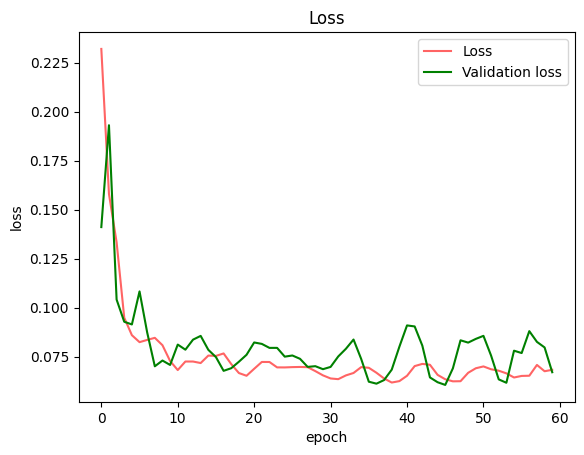

cv_time ：105.374579 s
((0.15, 0.05, 0.01), 60, 50, 50, (0.05, 0.03, 0.01))
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.49375, loss: 0.32013045513023114
step 2, accuracy_train:0.784375, loss: 0.12400498389278052
step 3, accuracy_train:0.796875, loss: 0.1463074677550521
step 4, accuracy_train:0.81875, loss: 0.15092738992251964
step 5, accuracy_train:0.809375, loss: 0.10303690646666165
step 6, accuracy_train:0.803125, loss: 0.08356949808254201
step 7, accuracy_train:0.78125, loss: 0.07889672624909153
step 8, accuracy_train:0.7875, loss: 0.07472477477905201
step 9, accuracy_train:0.790625, loss: 0.07551283745627962
step 10, accuracy_train:0.79375, loss: 0.0754820797345869
step 11, accuracy_train:0.809375, loss: 0.06993380725445014
step 12, accuracy_train:0.815625, loss: 0.06774336788968605
step 13, accuracy_train:0.815625, loss: 0.06764778939068726
step 14, accuracy_train:0.834375, loss: 0.06586740928052104
step 15, accur

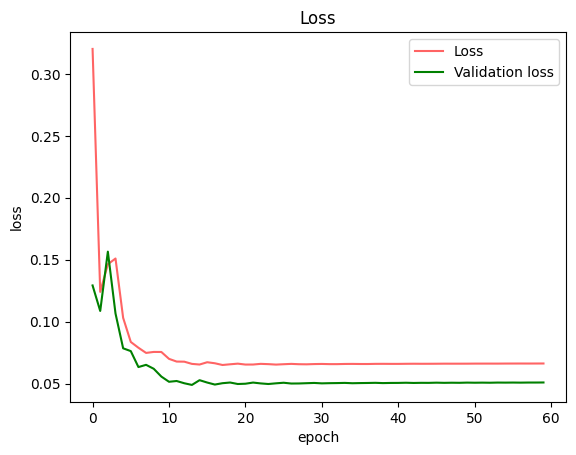

step 1, accuracy_train:0.5125, loss: 0.31866609375832494
step 2, accuracy_train:0.784375, loss: 0.12350997328034022
step 3, accuracy_train:0.796875, loss: 0.1426248098100348
step 4, accuracy_train:0.821875, loss: 0.15783880569038747
step 5, accuracy_train:0.846875, loss: 0.10213287985222899
step 6, accuracy_train:0.846875, loss: 0.07664630486070438
step 7, accuracy_train:0.8375, loss: 0.07440025515589388
step 8, accuracy_train:0.815625, loss: 0.0677677154827713
step 9, accuracy_train:0.828125, loss: 0.06594959697583584
step 10, accuracy_train:0.821875, loss: 0.06642535228782535
step 11, accuracy_train:0.865625, loss: 0.06254022780065731
step 12, accuracy_train:0.85625, loss: 0.06135750358427717
step 13, accuracy_train:0.84375, loss: 0.062023574833988085
step 14, accuracy_train:0.846875, loss: 0.059966077756029634
step 15, accuracy_train:0.846875, loss: 0.059421241037679255
step 16, accuracy_train:0.85, loss: 0.06141629398193431
step 17, accuracy_train:0.84375, loss: 0.06094655248406176

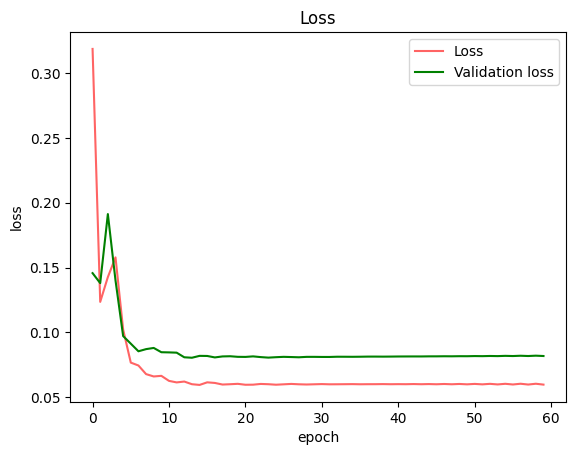

step 1, accuracy_train:0.4375, loss: 0.3315521066281557
step 2, accuracy_train:0.73125, loss: 0.1275991680524308
step 3, accuracy_train:0.75, loss: 0.1537413408113701
step 4, accuracy_train:0.7875, loss: 0.1638738267856702
step 5, accuracy_train:0.79375, loss: 0.1270429900353066
step 6, accuracy_train:0.79375, loss: 0.08987504174496788
step 7, accuracy_train:0.815625, loss: 0.08182898082112654
step 8, accuracy_train:0.83125, loss: 0.07777377429953278
step 9, accuracy_train:0.821875, loss: 0.07099501957167559
step 10, accuracy_train:0.83125, loss: 0.06769495640659287
step 11, accuracy_train:0.821875, loss: 0.07520011308845131
step 12, accuracy_train:0.84375, loss: 0.0663643001093302
step 13, accuracy_train:0.85, loss: 0.06332774690782089
step 14, accuracy_train:0.834375, loss: 0.06529334598298986
step 15, accuracy_train:0.865625, loss: 0.06292692147522899
step 16, accuracy_train:0.85, loss: 0.06319897905685173
step 17, accuracy_train:0.840625, loss: 0.06523706476316135
step 18, accuracy

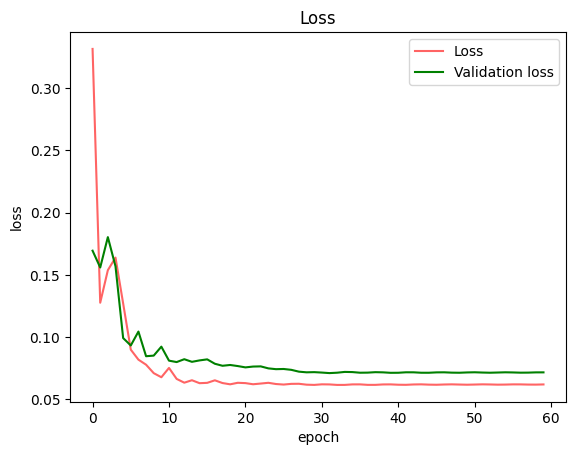

step 1, accuracy_train:0.3875, loss: 0.3333713988378534
step 2, accuracy_train:0.7125, loss: 0.12720555027509275
step 3, accuracy_train:0.725, loss: 0.15871342362132185
step 4, accuracy_train:0.784375, loss: 0.1873823300102309
step 5, accuracy_train:0.796875, loss: 0.12166389558994464
step 6, accuracy_train:0.75, loss: 0.09197964273274936
step 7, accuracy_train:0.80625, loss: 0.08293332771552096
step 8, accuracy_train:0.790625, loss: 0.08139736127760494
step 9, accuracy_train:0.815625, loss: 0.07418506650647413
step 10, accuracy_train:0.81875, loss: 0.0739749718305241
step 11, accuracy_train:0.834375, loss: 0.07251678801213451
step 12, accuracy_train:0.809375, loss: 0.070862890278371
step 13, accuracy_train:0.828125, loss: 0.0659505842620628
step 14, accuracy_train:0.840625, loss: 0.06523773171618052
step 15, accuracy_train:0.83125, loss: 0.06667316850398898
step 16, accuracy_train:0.840625, loss: 0.06492538173341582
step 17, accuracy_train:0.84375, loss: 0.06335845272993416
step 18, a

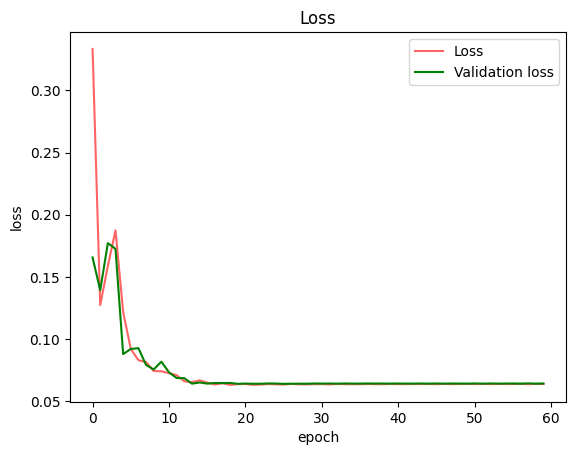

step 1, accuracy_train:0.396875, loss: 0.33071914360749416
step 2, accuracy_train:0.778125, loss: 0.11767765355478904
step 3, accuracy_train:0.740625, loss: 0.17843003961777684
step 4, accuracy_train:0.75625, loss: 0.17665081424265608
step 5, accuracy_train:0.796875, loss: 0.12214122462558605
step 6, accuracy_train:0.8, loss: 0.08500072749634746
step 7, accuracy_train:0.8125, loss: 0.08789743669645649
step 8, accuracy_train:0.828125, loss: 0.07741279501698614
step 9, accuracy_train:0.815625, loss: 0.07126344222788296
step 10, accuracy_train:0.825, loss: 0.07393175354622143
step 11, accuracy_train:0.8625, loss: 0.06790935143875726
step 12, accuracy_train:0.846875, loss: 0.06964566116619421
step 13, accuracy_train:0.875, loss: 0.06461576990413397
step 14, accuracy_train:0.86875, loss: 0.06327639537651869
step 15, accuracy_train:0.85, loss: 0.06530309519804772
step 16, accuracy_train:0.85, loss: 0.06381463192789869
step 17, accuracy_train:0.84375, loss: 0.06370363905219298
step 18, accura

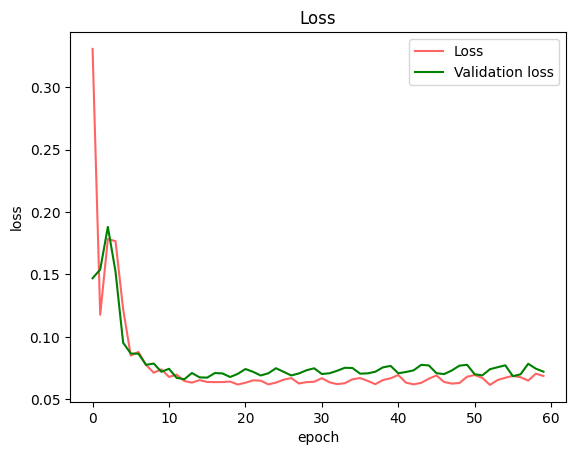

cv_time ：89.644136 s
((0.15, 0.05, 0.01), 60, 100, 50, (0.05, 0.03, 0.01))
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.48125, loss: 0.4338653578838457
step 2, accuracy_train:0.65, loss: 0.2432753975887263
step 3, accuracy_train:0.621875, loss: 0.14420605699412659
step 4, accuracy_train:0.69375, loss: 0.11895335407279037
step 5, accuracy_train:0.6875, loss: 0.12939603051840148
step 6, accuracy_train:0.665625, loss: 0.15172094908812667
step 7, accuracy_train:0.7, loss: 0.14325689747299103
step 8, accuracy_train:0.7625, loss: 0.15184009289321343
step 9, accuracy_train:0.78125, loss: 0.13252409790566969
step 10, accuracy_train:0.75625, loss: 0.10281874429521554
step 11, accuracy_train:0.746875, loss: 0.08752757972998938
step 12, accuracy_train:0.740625, loss: 0.08523549216638082
step 13, accuracy_train:0.771875, loss: 0.08805421161068415
step 14, accuracy_train:0.784375, loss: 0.08831376075609787
step 15, accuracy_train:0

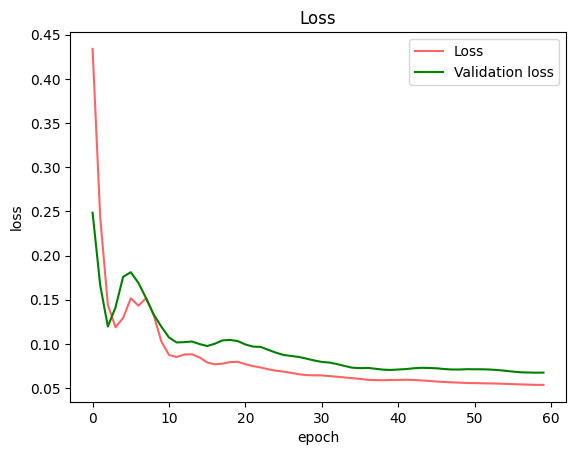

step 1, accuracy_train:0.490625, loss: 0.4336024444157488
step 2, accuracy_train:0.65, loss: 0.24249301754562794
step 3, accuracy_train:0.640625, loss: 0.14510653019900016
step 4, accuracy_train:0.703125, loss: 0.11960501395406775
step 5, accuracy_train:0.696875, loss: 0.13106454379572832
step 6, accuracy_train:0.665625, loss: 0.14955372827129348
step 7, accuracy_train:0.678125, loss: 0.1438565166424481
step 8, accuracy_train:0.74375, loss: 0.14827317240104398
step 9, accuracy_train:0.75625, loss: 0.13229060325801964
step 10, accuracy_train:0.75, loss: 0.10478420574852922
step 11, accuracy_train:0.734375, loss: 0.09194227914925057
step 12, accuracy_train:0.728125, loss: 0.0871051461804364
step 13, accuracy_train:0.75, loss: 0.08813785494248175
step 14, accuracy_train:0.765625, loss: 0.08645496212081147
step 15, accuracy_train:0.7625, loss: 0.08343768267312801
step 16, accuracy_train:0.75, loss: 0.08047095573345908
step 17, accuracy_train:0.753125, loss: 0.07955457034813596
step 18, acc

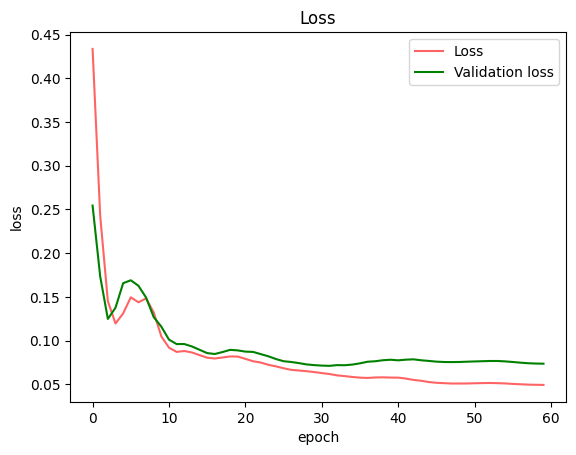

step 1, accuracy_train:0.484375, loss: 0.43347859609607875
step 2, accuracy_train:0.634375, loss: 0.24021450018235224
step 3, accuracy_train:0.665625, loss: 0.13997399388616003
step 4, accuracy_train:0.6875, loss: 0.12720550504662073
step 5, accuracy_train:0.69375, loss: 0.13218413889624805
step 6, accuracy_train:0.653125, loss: 0.1510795430425867
step 7, accuracy_train:0.690625, loss: 0.14589900198811617
step 8, accuracy_train:0.75625, loss: 0.14765676052890028
step 9, accuracy_train:0.7875, loss: 0.13763184337456363
step 10, accuracy_train:0.76875, loss: 0.10954618734022972
step 11, accuracy_train:0.75, loss: 0.09169668872006564
step 12, accuracy_train:0.78125, loss: 0.08460775227416233
step 13, accuracy_train:0.784375, loss: 0.08368810115612912
step 14, accuracy_train:0.78125, loss: 0.08139698222961542
step 15, accuracy_train:0.796875, loss: 0.07789975353452913
step 16, accuracy_train:0.78125, loss: 0.07906908780377275
step 17, accuracy_train:0.7875, loss: 0.0764975589425107
step 18

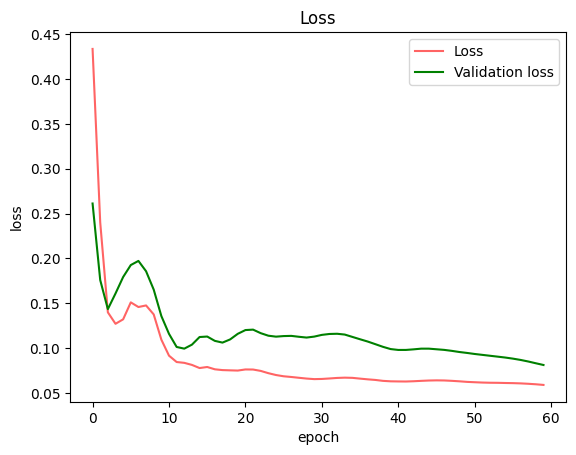

step 1, accuracy_train:0.490625, loss: 0.4337453126592113
step 2, accuracy_train:0.65, loss: 0.24228935215156647
step 3, accuracy_train:0.6375, loss: 0.14515475729576433
step 4, accuracy_train:0.6875, loss: 0.1209785942069056
step 5, accuracy_train:0.70625, loss: 0.12815568244613143
step 6, accuracy_train:0.6875, loss: 0.1448789575547667
step 7, accuracy_train:0.7125, loss: 0.14701059476999948
step 8, accuracy_train:0.75, loss: 0.1556091303678882
step 9, accuracy_train:0.746875, loss: 0.13617830824202293
step 10, accuracy_train:0.715625, loss: 0.11318546705247923
step 11, accuracy_train:0.734375, loss: 0.097266322224175
step 12, accuracy_train:0.75, loss: 0.0886471044200928
step 13, accuracy_train:0.75625, loss: 0.08589875940618097
step 14, accuracy_train:0.759375, loss: 0.08794240773940908
step 15, accuracy_train:0.7625, loss: 0.08582579029277673
step 16, accuracy_train:0.775, loss: 0.08290099176030208
step 17, accuracy_train:0.778125, loss: 0.07834918392076182
step 18, accuracy_train

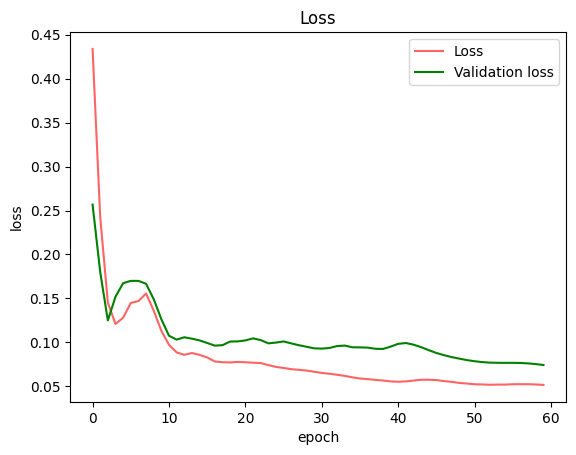

step 1, accuracy_train:0.475, loss: 0.43301996757048544
step 2, accuracy_train:0.590625, loss: 0.23832840274807077
step 3, accuracy_train:0.7, loss: 0.13520693093374958
step 4, accuracy_train:0.621875, loss: 0.125996408078488
step 5, accuracy_train:0.678125, loss: 0.1509331762451621
step 6, accuracy_train:0.734375, loss: 0.16688831296004486
step 7, accuracy_train:0.728125, loss: 0.1581496800531616
step 8, accuracy_train:0.70625, loss: 0.14416438984629104
step 9, accuracy_train:0.7625, loss: 0.11753197458637621
step 10, accuracy_train:0.8, loss: 0.10417388571644105
step 11, accuracy_train:0.825, loss: 0.0883984894945132
step 12, accuracy_train:0.80625, loss: 0.07912373190257938
step 13, accuracy_train:0.825, loss: 0.07414140117133376
step 14, accuracy_train:0.828125, loss: 0.0718841268550826
step 15, accuracy_train:0.825, loss: 0.07032748572933374
step 16, accuracy_train:0.828125, loss: 0.06351993293266622
step 17, accuracy_train:0.809375, loss: 0.05905703117293947
step 18, accuracy_tra

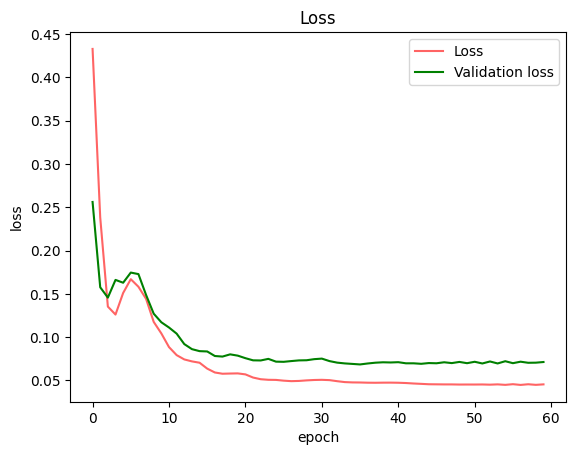

cv_time ：86.632317 s
((0.15, 0.05, 0.01), 60, 300, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.49375, loss: 0.24385480841845822
step 2, accuracy_train:0.734375, loss: 0.17187431949518298
step 3, accuracy_train:0.753125, loss: 0.1233850996449161
step 4, accuracy_train:0.790625, loss: 0.09246953435954801
step 5, accuracy_train:0.778125, loss: 0.088447010462935
step 6, accuracy_train:0.796875, loss: 0.0841095220102762
step 7, accuracy_train:0.825, loss: 0.08160534436589306
step 8, accuracy_train:0.7875, loss: 0.08443524204353244
step 9, accuracy_train:0.8125, loss: 0.07489903627161856
step 10, accuracy_train:0.81875, loss: 0.07000338935795485
step 11, accuracy_train:0.834375, loss: 0.06868838287810368
step 12, accuracy_train:0.840625, loss: 0.06667369252727956
step 13, accuracy_train:0.840625, loss: 0.06395502718512476
step 14, accuracy_train:0.828125, loss: 0.0635361146932101
step 15, accuracy_train:0.83125, loss: 0.06343446937306248
step 16, accuracy_train:0.8375, loss: 0.062681386

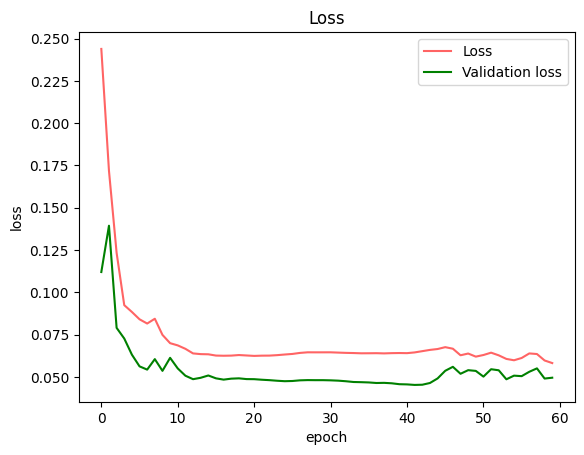

step 1, accuracy_train:0.61875, loss: 0.23671959385486532
step 2, accuracy_train:0.7375, loss: 0.16685522512799678
step 3, accuracy_train:0.78125, loss: 0.13483073578825813
step 4, accuracy_train:0.771875, loss: 0.08923661720275271
step 5, accuracy_train:0.821875, loss: 0.08145972864892946
step 6, accuracy_train:0.83125, loss: 0.07701208967068425
step 7, accuracy_train:0.815625, loss: 0.0767578766727865
step 8, accuracy_train:0.778125, loss: 0.08572114936163451
step 9, accuracy_train:0.778125, loss: 0.08310421098016303
step 10, accuracy_train:0.840625, loss: 0.077670625895162
step 11, accuracy_train:0.809375, loss: 0.07178485720249252
step 12, accuracy_train:0.8375, loss: 0.06795556003834637
step 13, accuracy_train:0.846875, loss: 0.06884404748604095
step 14, accuracy_train:0.84375, loss: 0.0671889057595581
step 15, accuracy_train:0.825, loss: 0.07083238437642013
step 16, accuracy_train:0.8125, loss: 0.07612016008810718
step 17, accuracy_train:0.821875, loss: 0.07520757537016381
step 1

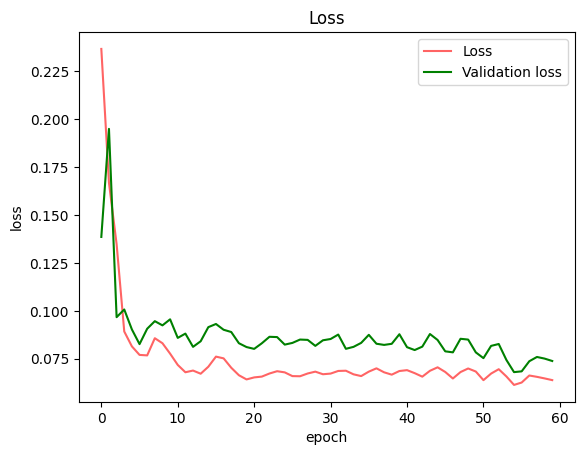

step 1, accuracy_train:0.63125, loss: 0.23308371465358343
step 2, accuracy_train:0.73125, loss: 0.1751589063890511
step 3, accuracy_train:0.796875, loss: 0.13148626765933646
step 4, accuracy_train:0.7875, loss: 0.08441492175669847
step 5, accuracy_train:0.828125, loss: 0.07412396254300312
step 6, accuracy_train:0.84375, loss: 0.06938256853908163
step 7, accuracy_train:0.853125, loss: 0.06433934180589145
step 8, accuracy_train:0.846875, loss: 0.06346391263576975
step 9, accuracy_train:0.84375, loss: 0.06286019943332295
step 10, accuracy_train:0.8625, loss: 0.05967663591350262
step 11, accuracy_train:0.871875, loss: 0.05850002397139607
step 12, accuracy_train:0.871875, loss: 0.058090993130835336
step 13, accuracy_train:0.875, loss: 0.05715258719354075
step 14, accuracy_train:0.875, loss: 0.05716040719587216
step 15, accuracy_train:0.865625, loss: 0.056715773689853984
step 16, accuracy_train:0.86875, loss: 0.056516396848071866
step 17, accuracy_train:0.871875, loss: 0.057115205909062584
s

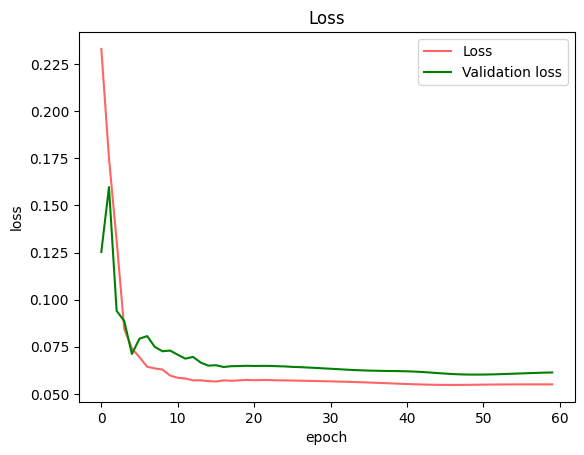

step 1, accuracy_train:0.60625, loss: 0.23950305421107912
step 2, accuracy_train:0.790625, loss: 0.14536106161975987
step 3, accuracy_train:0.80625, loss: 0.09728402438398429
step 4, accuracy_train:0.796875, loss: 0.08080103948702416
step 5, accuracy_train:0.853125, loss: 0.07533160257610673
step 6, accuracy_train:0.853125, loss: 0.07375133803964139
step 7, accuracy_train:0.825, loss: 0.07273061702202499
step 8, accuracy_train:0.815625, loss: 0.0742741172462958
step 9, accuracy_train:0.81875, loss: 0.07569926630858831
step 10, accuracy_train:0.85, loss: 0.07360148965238457
step 11, accuracy_train:0.8375, loss: 0.07291995357851587
step 12, accuracy_train:0.821875, loss: 0.07524063724660653
step 13, accuracy_train:0.815625, loss: 0.07427887653546632
step 14, accuracy_train:0.821875, loss: 0.07438865324352217
step 15, accuracy_train:0.859375, loss: 0.07189645001199198
step 16, accuracy_train:0.846875, loss: 0.07162609090818278
step 17, accuracy_train:0.828125, loss: 0.07268343869529884
st

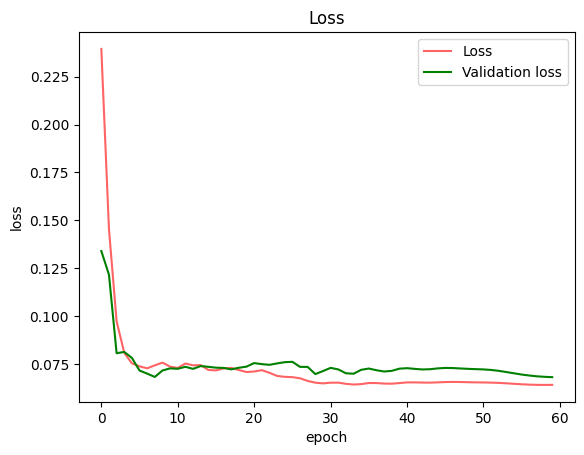

step 1, accuracy_train:0.640625, loss: 0.23206009317689869
step 2, accuracy_train:0.80625, loss: 0.15803861726810348
step 3, accuracy_train:0.721875, loss: 0.1334063546741588
step 4, accuracy_train:0.759375, loss: 0.0948942194523198
step 5, accuracy_train:0.8375, loss: 0.08598584369362322
step 6, accuracy_train:0.790625, loss: 0.08244186574382602
step 7, accuracy_train:0.796875, loss: 0.08357646301908749
step 8, accuracy_train:0.809375, loss: 0.08464501150441074
step 9, accuracy_train:0.821875, loss: 0.08087616766150643
step 10, accuracy_train:0.80625, loss: 0.0728106492369136
step 11, accuracy_train:0.8375, loss: 0.06820179800017441
step 12, accuracy_train:0.834375, loss: 0.07256067951056647
step 13, accuracy_train:0.815625, loss: 0.07255207184800815
step 14, accuracy_train:0.83125, loss: 0.07178150256304282
step 15, accuracy_train:0.821875, loss: 0.07558799346554193
step 16, accuracy_train:0.828125, loss: 0.0754254258614425
step 17, accuracy_train:0.8125, loss: 0.07667735062089319
st

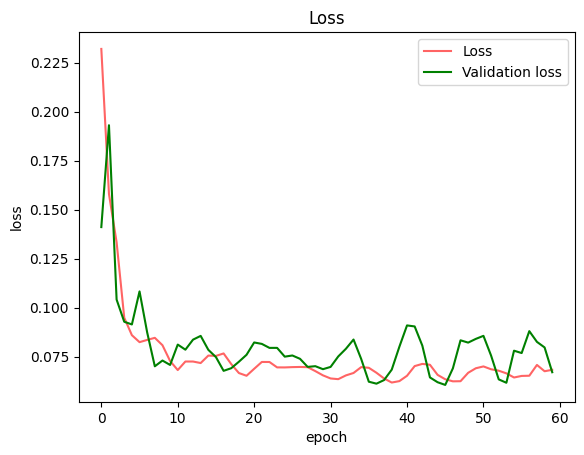

cv_time ：89.995579 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 50, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.49375, loss: 0.32013045513023114
step 2, accuracy_train:0.784375, loss: 0.12400498389278052
step 3, accuracy_train:0.796875, loss: 0.1463074677550521
step 4, accuracy_train:0.81875, loss: 0.15092738992251964
step 5, accuracy_train:0.809375, loss: 0.10303690646666165
step 6, accuracy_train:0.803125, loss: 0.08356949808254201
step 7, accuracy_train:0.78125, loss: 0.07889672624909153
step 8, accuracy_train:0.7875, loss: 0.07472477477905201
step 9, accuracy_train:0.790625, loss: 0.07551283745627962
step 10, accuracy_train:0.79375, loss: 0.0754820797345869
step 11, accuracy_train:0.809375, loss: 0.06993380725445014
step 12, accuracy_train:0.815625, loss: 0.06774336788968605
step 13, accuracy_train:0.815625, loss: 0.06764778939068726
step 14, accuracy_train:0.834375, loss: 0.06586740928052104
step 15, accuracy_train:0.828125, loss: 0.06535472951446136
step 16, accuracy_train:0.83

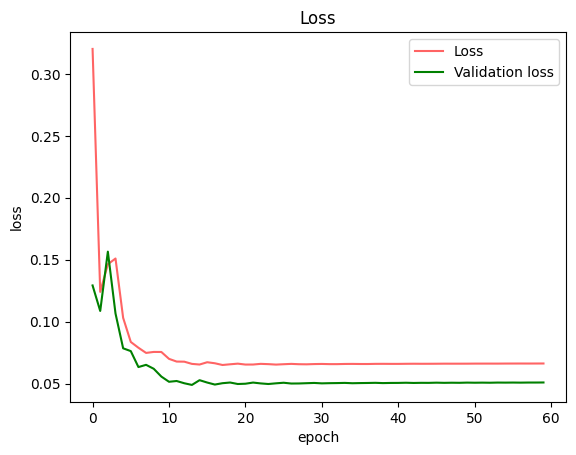

step 1, accuracy_train:0.5125, loss: 0.31866609375832494
step 2, accuracy_train:0.784375, loss: 0.12350997328034022
step 3, accuracy_train:0.796875, loss: 0.1426248098100348
step 4, accuracy_train:0.821875, loss: 0.15783880569038747
step 5, accuracy_train:0.846875, loss: 0.10213287985222899
step 6, accuracy_train:0.846875, loss: 0.07664630486070438
step 7, accuracy_train:0.8375, loss: 0.07440025515589388
step 8, accuracy_train:0.815625, loss: 0.0677677154827713
step 9, accuracy_train:0.828125, loss: 0.06594959697583584
step 10, accuracy_train:0.821875, loss: 0.06642535228782535
step 11, accuracy_train:0.865625, loss: 0.06254022780065731
step 12, accuracy_train:0.85625, loss: 0.06135750358427717
step 13, accuracy_train:0.84375, loss: 0.062023574833988085
step 14, accuracy_train:0.846875, loss: 0.059966077756029634
step 15, accuracy_train:0.846875, loss: 0.059421241037679255
step 16, accuracy_train:0.85, loss: 0.06141629398193431
step 17, accuracy_train:0.84375, loss: 0.06094655248406176

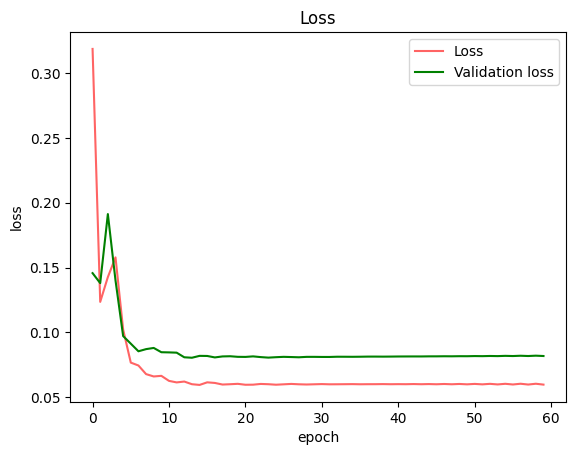

step 1, accuracy_train:0.4375, loss: 0.3315521066281557
step 2, accuracy_train:0.73125, loss: 0.1275991680524308
step 3, accuracy_train:0.75, loss: 0.1537413408113701
step 4, accuracy_train:0.7875, loss: 0.1638738267856702
step 5, accuracy_train:0.79375, loss: 0.1270429900353066
step 6, accuracy_train:0.79375, loss: 0.08987504174496788
step 7, accuracy_train:0.815625, loss: 0.08182898082112654
step 8, accuracy_train:0.83125, loss: 0.07777377429953278
step 9, accuracy_train:0.821875, loss: 0.07099501957167559
step 10, accuracy_train:0.83125, loss: 0.06769495640659287
step 11, accuracy_train:0.821875, loss: 0.07520011308845131
step 12, accuracy_train:0.84375, loss: 0.0663643001093302
step 13, accuracy_train:0.85, loss: 0.06332774690782089
step 14, accuracy_train:0.834375, loss: 0.06529334598298986
step 15, accuracy_train:0.865625, loss: 0.06292692147522899
step 16, accuracy_train:0.85, loss: 0.06319897905685173
step 17, accuracy_train:0.840625, loss: 0.06523706476316135
step 18, accuracy

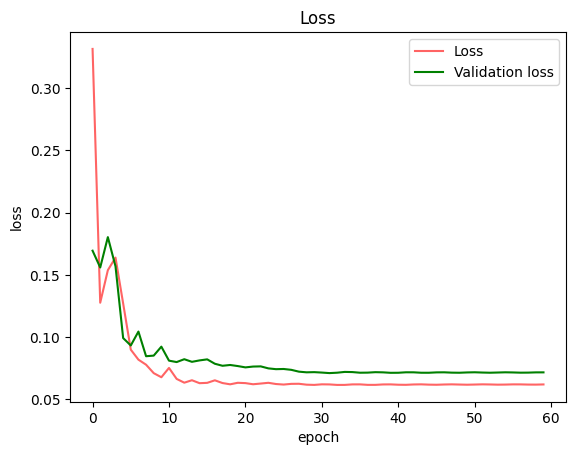

step 1, accuracy_train:0.3875, loss: 0.3333713988378534
step 2, accuracy_train:0.7125, loss: 0.12720555027509275
step 3, accuracy_train:0.725, loss: 0.15871342362132185
step 4, accuracy_train:0.784375, loss: 0.1873823300102309
step 5, accuracy_train:0.796875, loss: 0.12166389558994464
step 6, accuracy_train:0.75, loss: 0.09197964273274936
step 7, accuracy_train:0.80625, loss: 0.08293332771552096
step 8, accuracy_train:0.790625, loss: 0.08139736127760494
step 9, accuracy_train:0.815625, loss: 0.07418506650647413
step 10, accuracy_train:0.81875, loss: 0.0739749718305241
step 11, accuracy_train:0.834375, loss: 0.07251678801213451
step 12, accuracy_train:0.809375, loss: 0.070862890278371
step 13, accuracy_train:0.828125, loss: 0.0659505842620628
step 14, accuracy_train:0.840625, loss: 0.06523773171618052
step 15, accuracy_train:0.83125, loss: 0.06667316850398898
step 16, accuracy_train:0.840625, loss: 0.06492538173341582
step 17, accuracy_train:0.84375, loss: 0.06335845272993416
step 18, a

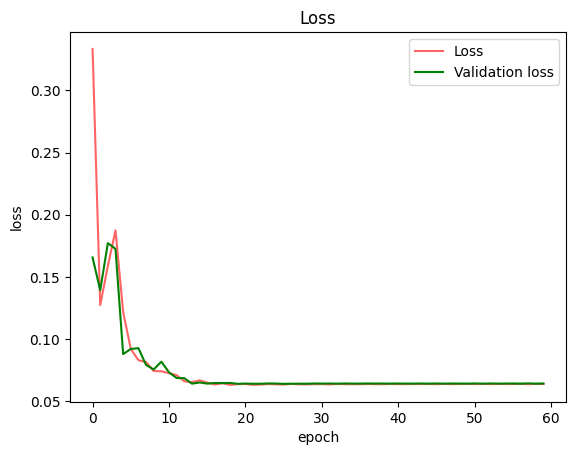

step 1, accuracy_train:0.396875, loss: 0.33071914360749416
step 2, accuracy_train:0.778125, loss: 0.11767765355478904
step 3, accuracy_train:0.740625, loss: 0.17843003961777684
step 4, accuracy_train:0.75625, loss: 0.17665081424265608
step 5, accuracy_train:0.796875, loss: 0.12214122462558605
step 6, accuracy_train:0.8, loss: 0.08500072749634746
step 7, accuracy_train:0.8125, loss: 0.08789743669645649
step 8, accuracy_train:0.828125, loss: 0.07741279501698614
step 9, accuracy_train:0.815625, loss: 0.07126344222788296
step 10, accuracy_train:0.825, loss: 0.07393175354622143
step 11, accuracy_train:0.8625, loss: 0.06790935143875726
step 12, accuracy_train:0.846875, loss: 0.06964566116619421
step 13, accuracy_train:0.875, loss: 0.06461576990413397
step 14, accuracy_train:0.86875, loss: 0.06327639537651869
step 15, accuracy_train:0.85, loss: 0.06530309519804772
step 16, accuracy_train:0.85, loss: 0.06381463192789869
step 17, accuracy_train:0.84375, loss: 0.06370363905219298
step 18, accura

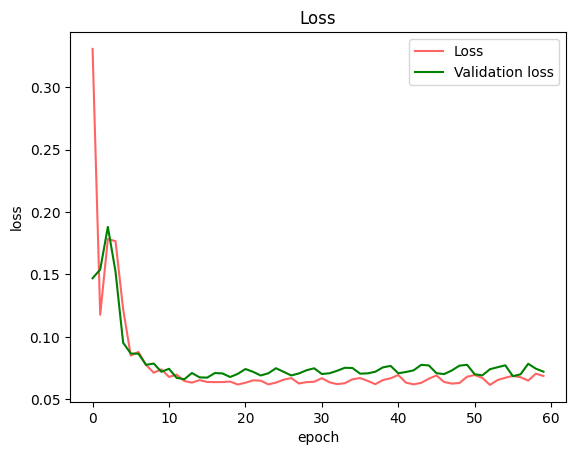

cv_time ：87.607797 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 100, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.48125, loss: 0.4338653578838457
step 2, accuracy_train:0.65, loss: 0.2432753975887263
step 3, accuracy_train:0.621875, loss: 0.14420605699412659
step 4, accuracy_train:0.69375, loss: 0.11895335407279037
step 5, accuracy_train:0.6875, loss: 0.12939603051840148
step 6, accuracy_train:0.665625, loss: 0.15172094908812667
step 7, accuracy_train:0.7, loss: 0.14325689747299103
step 8, accuracy_train:0.7625, loss: 0.15184009289321343
step 9, accuracy_train:0.78125, loss: 0.13252409790566969
step 10, accuracy_train:0.75625, loss: 0.10281874429521554
step 11, accuracy_train:0.746875, loss: 0.08752757972998938
step 12, accuracy_train:0.740625, loss: 0.08523549216638082
step 13, accuracy_train:0.771875, loss: 0.08805421161068415
step 14, accuracy_train:0.784375, loss: 0.08831376075609787
step 15, accuracy_train:0.778125, loss: 0.08474131764018036
step 16, accuracy_train:0.775, loss: 0

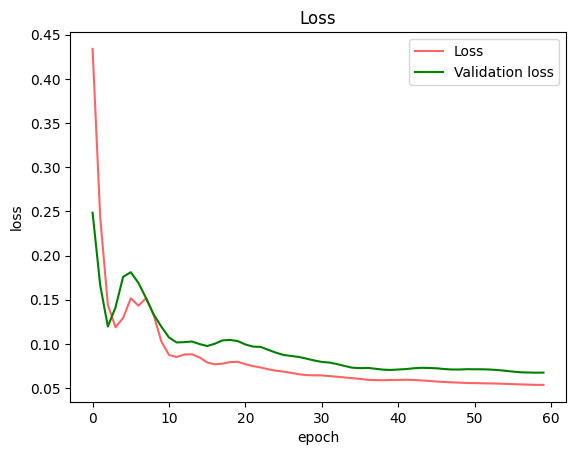

step 1, accuracy_train:0.490625, loss: 0.4336024444157488
step 2, accuracy_train:0.65, loss: 0.24249301754562794
step 3, accuracy_train:0.640625, loss: 0.14510653019900016
step 4, accuracy_train:0.703125, loss: 0.11960501395406775
step 5, accuracy_train:0.696875, loss: 0.13106454379572832
step 6, accuracy_train:0.665625, loss: 0.14955372827129348
step 7, accuracy_train:0.678125, loss: 0.1438565166424481
step 8, accuracy_train:0.74375, loss: 0.14827317240104398
step 9, accuracy_train:0.75625, loss: 0.13229060325801964
step 10, accuracy_train:0.75, loss: 0.10478420574852922
step 11, accuracy_train:0.734375, loss: 0.09194227914925057
step 12, accuracy_train:0.728125, loss: 0.0871051461804364
step 13, accuracy_train:0.75, loss: 0.08813785494248175
step 14, accuracy_train:0.765625, loss: 0.08645496212081147
step 15, accuracy_train:0.7625, loss: 0.08343768267312801
step 16, accuracy_train:0.75, loss: 0.08047095573345908
step 17, accuracy_train:0.753125, loss: 0.07955457034813596
step 18, acc

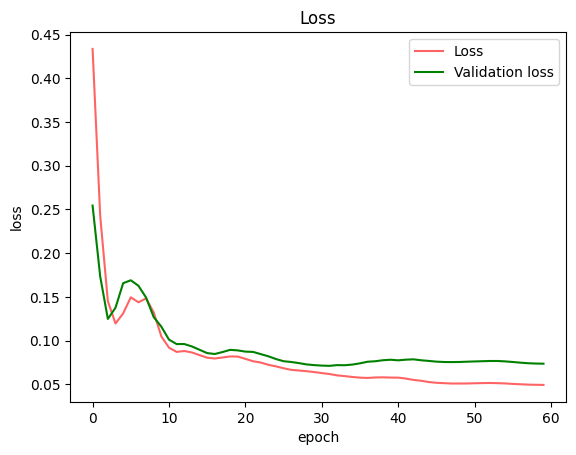

step 1, accuracy_train:0.484375, loss: 0.43347859609607875
step 2, accuracy_train:0.634375, loss: 0.24021450018235224
step 3, accuracy_train:0.665625, loss: 0.13997399388616003
step 4, accuracy_train:0.6875, loss: 0.12720550504662073
step 5, accuracy_train:0.69375, loss: 0.13218413889624805
step 6, accuracy_train:0.653125, loss: 0.1510795430425867
step 7, accuracy_train:0.690625, loss: 0.14589900198811617
step 8, accuracy_train:0.75625, loss: 0.14765676052890028
step 9, accuracy_train:0.7875, loss: 0.13763184337456363
step 10, accuracy_train:0.76875, loss: 0.10954618734022972
step 11, accuracy_train:0.75, loss: 0.09169668872006564
step 12, accuracy_train:0.78125, loss: 0.08460775227416233
step 13, accuracy_train:0.784375, loss: 0.08368810115612912
step 14, accuracy_train:0.78125, loss: 0.08139698222961542
step 15, accuracy_train:0.796875, loss: 0.07789975353452913
step 16, accuracy_train:0.78125, loss: 0.07906908780377275
step 17, accuracy_train:0.7875, loss: 0.0764975589425107
step 18

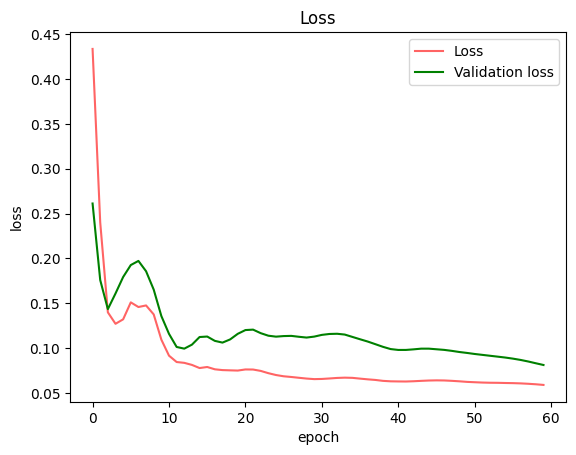

step 1, accuracy_train:0.490625, loss: 0.4337453126592113
step 2, accuracy_train:0.65, loss: 0.24228935215156647
step 3, accuracy_train:0.6375, loss: 0.14515475729576433
step 4, accuracy_train:0.6875, loss: 0.1209785942069056
step 5, accuracy_train:0.70625, loss: 0.12815568244613143
step 6, accuracy_train:0.6875, loss: 0.1448789575547667
step 7, accuracy_train:0.7125, loss: 0.14701059476999948
step 8, accuracy_train:0.75, loss: 0.1556091303678882
step 9, accuracy_train:0.746875, loss: 0.13617830824202293
step 10, accuracy_train:0.715625, loss: 0.11318546705247923
step 11, accuracy_train:0.734375, loss: 0.097266322224175
step 12, accuracy_train:0.75, loss: 0.0886471044200928
step 13, accuracy_train:0.75625, loss: 0.08589875940618097
step 14, accuracy_train:0.759375, loss: 0.08794240773940908
step 15, accuracy_train:0.7625, loss: 0.08582579029277673
step 16, accuracy_train:0.775, loss: 0.08290099176030208
step 17, accuracy_train:0.778125, loss: 0.07834918392076182
step 18, accuracy_train

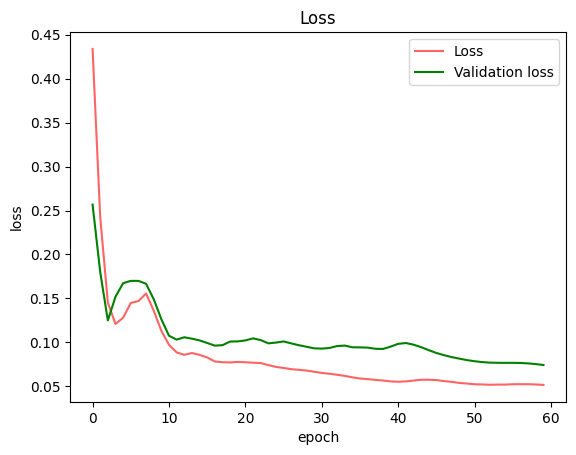

step 1, accuracy_train:0.475, loss: 0.43301996757048544
step 2, accuracy_train:0.590625, loss: 0.23832840274807077
step 3, accuracy_train:0.7, loss: 0.13520693093374958
step 4, accuracy_train:0.621875, loss: 0.125996408078488
step 5, accuracy_train:0.678125, loss: 0.1509331762451621
step 6, accuracy_train:0.734375, loss: 0.16688831296004486
step 7, accuracy_train:0.728125, loss: 0.1581496800531616
step 8, accuracy_train:0.70625, loss: 0.14416438984629104
step 9, accuracy_train:0.7625, loss: 0.11753197458637621
step 10, accuracy_train:0.8, loss: 0.10417388571644105
step 11, accuracy_train:0.825, loss: 0.0883984894945132
step 12, accuracy_train:0.80625, loss: 0.07912373190257938
step 13, accuracy_train:0.825, loss: 0.07414140117133376
step 14, accuracy_train:0.828125, loss: 0.0718841268550826
step 15, accuracy_train:0.825, loss: 0.07032748572933374
step 16, accuracy_train:0.828125, loss: 0.06351993293266622
step 17, accuracy_train:0.809375, loss: 0.05905703117293947
step 18, accuracy_tra

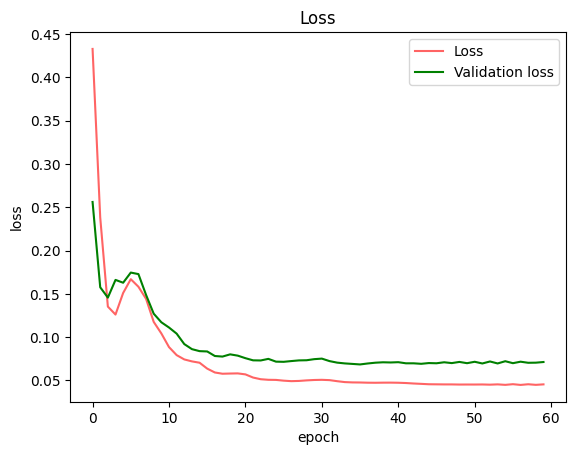

cv_time ：84.185846 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 300, 50, (0.05, 0.03, 0.01))


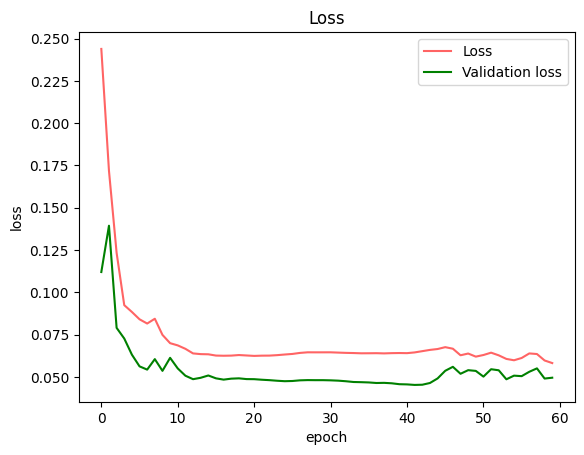

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.40625, loss: 0.1939904938024569
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 2, accuracy_train:0.684375, loss: 0.12407901938361937
step 3, accuracy_train:0.796875, loss: 0.10469475676353808
step 4, accuracy_train:0.825, loss: 0.09705715191587766
step 5, accuracy_train:0.840625, loss: 0.08955172238062171
step 6, accuracy_train:0.8625, loss: 0.0785837659085044
step 7, accuracy_train:0.825, loss: 0.08345159767943938
step 8, accuracy_train:0.81875, loss: 0.0861285409952856
step 9, accuracy_train:0.825, loss: 0.08790474678652141
step 10, accuracy_train:0.8, loss: 0.08300421646867694
step 11, accuracy_train:0.803125, loss: 0.08892347719341848
step 12, accuracy_train:0.85625, loss: 0.08162191161913367
step 13, accuracy_train:0.83125, loss: 0.081575

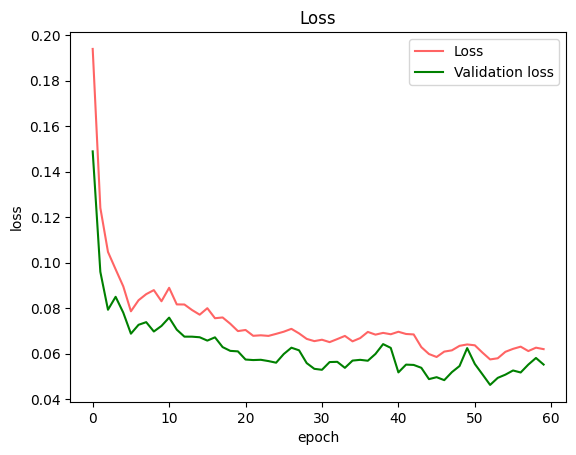

step 1, accuracy_train:0.384375, loss: 0.19955009028987578
step 2, accuracy_train:0.721875, loss: 0.13864346847871298
step 3, accuracy_train:0.78125, loss: 0.1062263546069261
step 4, accuracy_train:0.790625, loss: 0.1100925914246754
step 5, accuracy_train:0.803125, loss: 0.09435094135912739
step 6, accuracy_train:0.846875, loss: 0.09257487159595713
step 7, accuracy_train:0.865625, loss: 0.08821213411987464
step 8, accuracy_train:0.875, loss: 0.07228637501580416
step 9, accuracy_train:0.9, loss: 0.06891305136655061
step 10, accuracy_train:0.9125, loss: 0.07208941518505636
step 11, accuracy_train:0.89375, loss: 0.06016403340945776
step 12, accuracy_train:0.909375, loss: 0.05594277777813697
step 13, accuracy_train:0.90625, loss: 0.05822662574136781
step 14, accuracy_train:0.896875, loss: 0.05670961163858385
step 15, accuracy_train:0.884375, loss: 0.05545151017249484
step 16, accuracy_train:0.896875, loss: 0.05728318329945977
step 17, accuracy_train:0.8875, loss: 0.057430829484070786
step 

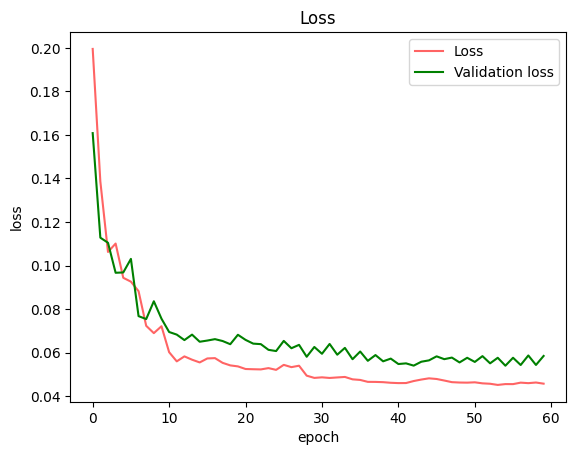

step 1, accuracy_train:0.36875, loss: 0.18748661942814998
step 2, accuracy_train:0.721875, loss: 0.11719908549237767
step 3, accuracy_train:0.84375, loss: 0.08603735358613032
step 4, accuracy_train:0.85625, loss: 0.0828342898029614
step 5, accuracy_train:0.878125, loss: 0.06816888931039627
step 6, accuracy_train:0.8875, loss: 0.06381103165805187
step 7, accuracy_train:0.890625, loss: 0.06468485029906892
step 8, accuracy_train:0.86875, loss: 0.06444801465534433
step 9, accuracy_train:0.865625, loss: 0.0642557401600957
step 10, accuracy_train:0.890625, loss: 0.06388407146767235
step 11, accuracy_train:0.903125, loss: 0.060497087520302514
step 12, accuracy_train:0.9, loss: 0.05916351780659981
step 13, accuracy_train:0.884375, loss: 0.059612817406986325
step 14, accuracy_train:0.884375, loss: 0.05944901724688316
step 15, accuracy_train:0.871875, loss: 0.059374165533973795
step 16, accuracy_train:0.875, loss: 0.057191924965999494
step 17, accuracy_train:0.890625, loss: 0.055049799610453774


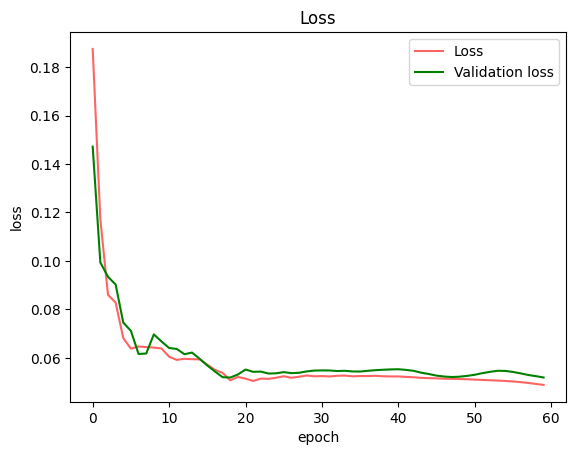

step 1, accuracy_train:0.31875, loss: 0.19886739465933195
step 2, accuracy_train:0.6875, loss: 0.1364950567447472
step 3, accuracy_train:0.803125, loss: 0.10507285845362316
step 4, accuracy_train:0.8375, loss: 0.08944351908166359
step 5, accuracy_train:0.878125, loss: 0.08371381744942637
step 6, accuracy_train:0.871875, loss: 0.07550215455073354
step 7, accuracy_train:0.871875, loss: 0.06944291042676655
step 8, accuracy_train:0.896875, loss: 0.06272947539684853
step 9, accuracy_train:0.890625, loss: 0.06557130034898302
step 10, accuracy_train:0.909375, loss: 0.06394803722943138
step 11, accuracy_train:0.903125, loss: 0.060086201075339206
step 12, accuracy_train:0.909375, loss: 0.05918285314937242
step 13, accuracy_train:0.909375, loss: 0.059622667557399464
step 14, accuracy_train:0.890625, loss: 0.059502002546385144
step 15, accuracy_train:0.903125, loss: 0.05655645020887396
step 16, accuracy_train:0.90625, loss: 0.055720170818819414
step 17, accuracy_train:0.903125, loss: 0.0556553999

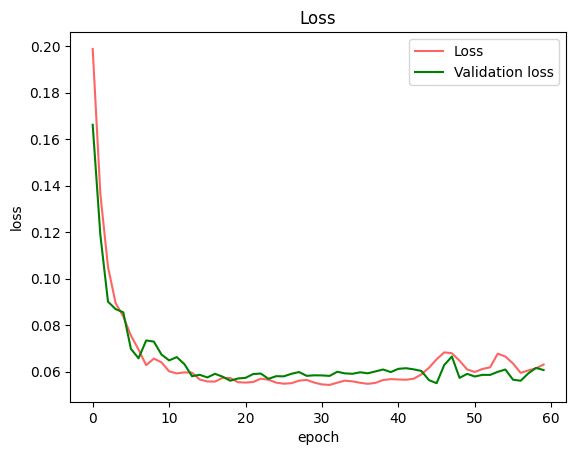

step 1, accuracy_train:0.30625, loss: 0.19740729697520337
step 2, accuracy_train:0.603125, loss: 0.14178421533060356
step 3, accuracy_train:0.784375, loss: 0.10943809797303058
step 4, accuracy_train:0.834375, loss: 0.12061612205903473
step 5, accuracy_train:0.84375, loss: 0.09029197785494289
step 6, accuracy_train:0.8375, loss: 0.08222862726528239
step 7, accuracy_train:0.846875, loss: 0.08440614455411628
step 8, accuracy_train:0.884375, loss: 0.07672658960589164
step 9, accuracy_train:0.853125, loss: 0.07067709531911005
step 10, accuracy_train:0.8875, loss: 0.06488742324252712
step 11, accuracy_train:0.878125, loss: 0.06561664555426823
step 12, accuracy_train:0.9, loss: 0.06446506787127483
step 13, accuracy_train:0.896875, loss: 0.0669531902457136
step 14, accuracy_train:0.890625, loss: 0.06364784946905247
step 15, accuracy_train:0.909375, loss: 0.06339827836081213
step 16, accuracy_train:0.896875, loss: 0.062102645368142535
step 17, accuracy_train:0.875, loss: 0.06964586635131412
ste

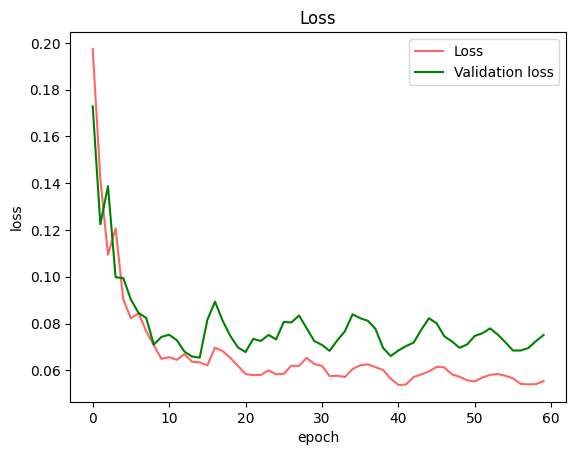

cv_time ：184.143834 s
((0.15, 0.05, 0.01), 60, 50, 50, (0.05, 0.03, 0.01))
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.275, loss: 0.2173501125067964
step 2, accuracy_train:0.48125, loss: 0.17494576338591888
step 3, accuracy_train:0.65625, loss: 0.13496128061945728
step 4, accuracy_train:0.684375, loss: 0.1175582062027315
step 5, accuracy_train:0.753125, loss: 0.1128539881497575
step 6, accuracy_train:0.76875, loss: 0.11685380271354104
step 7, accuracy_train:0.759375, loss: 0.11678797054094756
step 8, accuracy_train:0.790625, loss: 0.10209516834862012
step 9, accuracy_train:0.79375, loss: 0.09572522530832789
step 10, accuracy_train:0.80625, loss: 0.09189616490368374
step 11, accuracy_train:0.796875, loss: 0.09641456386532171
step 12, accuracy_train:0.81875, loss: 0.09898232490408232
step 13, accuracy_train:0.83125, loss: 0.09365842022240545
step 14, accuracy_train:0.85, loss: 0.08835441774642273
step 15, accuracy_train

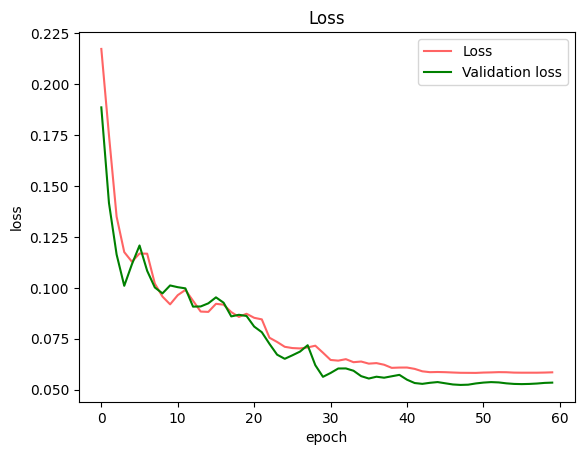

step 1, accuracy_train:0.26875, loss: 0.20512683030916518
step 2, accuracy_train:0.490625, loss: 0.14552596584442187
step 3, accuracy_train:0.7625, loss: 0.11336942095907644
step 4, accuracy_train:0.828125, loss: 0.09827431977272874
step 5, accuracy_train:0.86875, loss: 0.09143201609512154
step 6, accuracy_train:0.859375, loss: 0.08705466101801898
step 7, accuracy_train:0.878125, loss: 0.07170096492286902
step 8, accuracy_train:0.8875, loss: 0.06573345424849408
step 9, accuracy_train:0.909375, loss: 0.061821969309863334
step 10, accuracy_train:0.875, loss: 0.06229310450248794
step 11, accuracy_train:0.8625, loss: 0.06506064751610335
step 12, accuracy_train:0.875, loss: 0.059350067523200926
step 13, accuracy_train:0.878125, loss: 0.05541445787955211
step 14, accuracy_train:0.88125, loss: 0.054400331661261084
step 15, accuracy_train:0.88125, loss: 0.05420167896697023
step 16, accuracy_train:0.878125, loss: 0.0549566050435978
step 17, accuracy_train:0.878125, loss: 0.0545977296260343
step

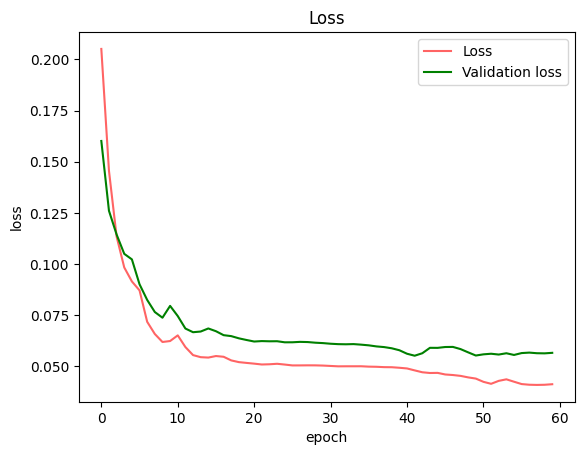

step 1, accuracy_train:0.30625, loss: 0.20648074753042214
step 2, accuracy_train:0.55, loss: 0.15241669911304334
step 3, accuracy_train:0.8, loss: 0.11209392750247835
step 4, accuracy_train:0.809375, loss: 0.10224409229488488
step 5, accuracy_train:0.778125, loss: 0.09763539536137829
step 6, accuracy_train:0.828125, loss: 0.11776370136265361
step 7, accuracy_train:0.79375, loss: 0.13530067331508072
step 8, accuracy_train:0.8625, loss: 0.10499054105643311
step 9, accuracy_train:0.84375, loss: 0.08315088118360353
step 10, accuracy_train:0.859375, loss: 0.07784250292252265
step 11, accuracy_train:0.86875, loss: 0.08063714025543489
step 12, accuracy_train:0.853125, loss: 0.08521334971457206
step 13, accuracy_train:0.875, loss: 0.08391378213483311
step 14, accuracy_train:0.8625, loss: 0.08096917568488035
step 15, accuracy_train:0.86875, loss: 0.07975010094932866
step 16, accuracy_train:0.8875, loss: 0.07917392481792326
step 17, accuracy_train:0.878125, loss: 0.07957350678836604
step 18, acc

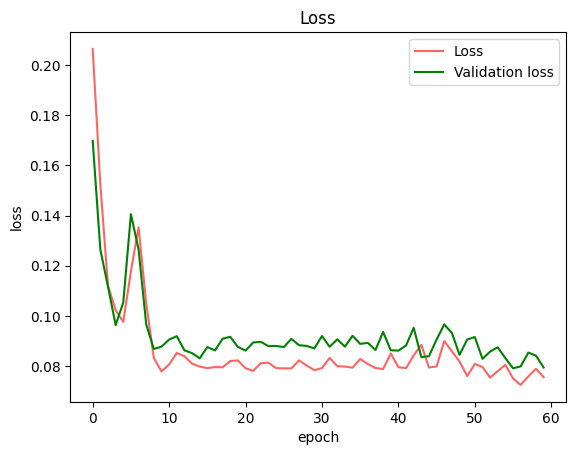

step 1, accuracy_train:0.33125, loss: 0.19797666862274216
step 2, accuracy_train:0.659375, loss: 0.1469204357292127
step 3, accuracy_train:0.6625, loss: 0.12216736091674614
step 4, accuracy_train:0.796875, loss: 0.11309738350454812
step 5, accuracy_train:0.771875, loss: 0.11280657129476046
step 6, accuracy_train:0.8125, loss: 0.11134040263910658
step 7, accuracy_train:0.83125, loss: 0.09919203313329022
step 8, accuracy_train:0.859375, loss: 0.08084935209136668
step 9, accuracy_train:0.86875, loss: 0.08828154688804712
step 10, accuracy_train:0.8875, loss: 0.07598724207966276
step 11, accuracy_train:0.86875, loss: 0.06456232383430108
step 12, accuracy_train:0.9, loss: 0.07120071923596878
step 13, accuracy_train:0.85, loss: 0.06958036368427725
step 14, accuracy_train:0.88125, loss: 0.06301476368913973
step 15, accuracy_train:0.9125, loss: 0.05337030853102048
step 16, accuracy_train:0.90625, loss: 0.050757057126567126
step 17, accuracy_train:0.88125, loss: 0.05517900695454758
step 18, accu

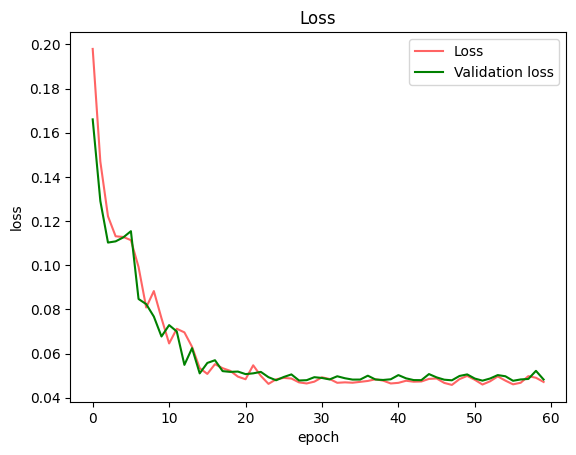

step 1, accuracy_train:0.325, loss: 0.19840913028769075
step 2, accuracy_train:0.446875, loss: 0.16491196983520268
step 3, accuracy_train:0.6875, loss: 0.13701301625995896
step 4, accuracy_train:0.721875, loss: 0.12620296463808872
step 5, accuracy_train:0.771875, loss: 0.10526854437789449
step 6, accuracy_train:0.815625, loss: 0.10160299347271082
step 7, accuracy_train:0.865625, loss: 0.09164407642126157
step 8, accuracy_train:0.871875, loss: 0.07383725674240882
step 9, accuracy_train:0.884375, loss: 0.06675386630528936
step 10, accuracy_train:0.884375, loss: 0.061973448834788114
step 11, accuracy_train:0.9, loss: 0.058661632043447154
step 12, accuracy_train:0.871875, loss: 0.061348713259059544
step 13, accuracy_train:0.896875, loss: 0.05746130522490873
step 14, accuracy_train:0.884375, loss: 0.05719385623753677
step 15, accuracy_train:0.8875, loss: 0.05553107208195428
step 16, accuracy_train:0.88125, loss: 0.0564277176267866
step 17, accuracy_train:0.875, loss: 0.0565158068478038
step

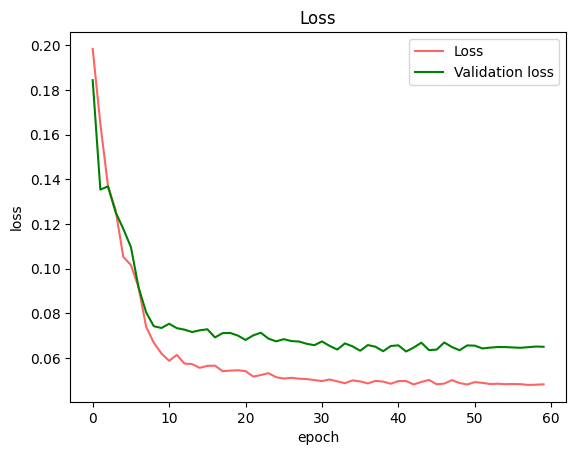

cv_time ：165.593954 s
((0.15, 0.05, 0.01), 60, 100, 50, (0.05, 0.03, 0.01))
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.146875, loss: 0.2275982863791554
step 2, accuracy_train:0.378125, loss: 0.17188116239562867
step 3, accuracy_train:0.51875, loss: 0.15235119020591814
step 4, accuracy_train:0.58125, loss: 0.12758641590902878
step 5, accuracy_train:0.575, loss: 0.13005666339580788
step 6, accuracy_train:0.571875, loss: 0.12429024716004361
step 7, accuracy_train:0.61875, loss: 0.11877645147826733
step 8, accuracy_train:0.653125, loss: 0.11549270391344305
step 9, accuracy_train:0.66875, loss: 0.10688151120018594
step 10, accuracy_train:0.659375, loss: 0.10750059528058405
step 11, accuracy_train:0.640625, loss: 0.10596685829334673
step 12, accuracy_train:0.665625, loss: 0.0987572322581887
step 13, accuracy_train:0.684375, loss: 0.097406715274383
step 14, accuracy_train:0.709375, loss: 0.09452312155247775
step 15, accurac

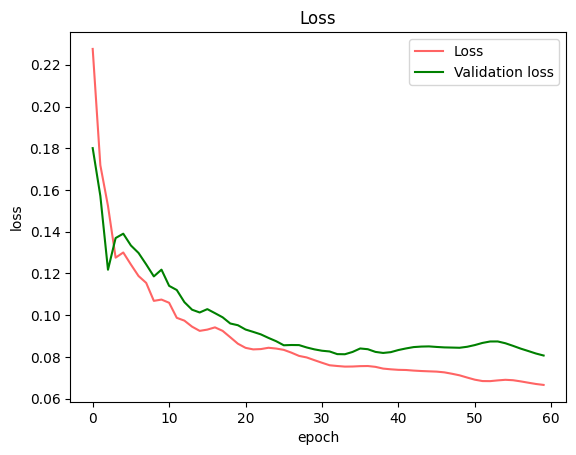

step 1, accuracy_train:0.146875, loss: 0.2305082909026603
step 2, accuracy_train:0.34375, loss: 0.20674876167172423
step 3, accuracy_train:0.296875, loss: 0.16560849002432693
step 4, accuracy_train:0.540625, loss: 0.1471672460151543
step 5, accuracy_train:0.6, loss: 0.14076114394319866
step 6, accuracy_train:0.615625, loss: 0.1391657961955261
step 7, accuracy_train:0.684375, loss: 0.12626024864213545
step 8, accuracy_train:0.634375, loss: 0.11148142997909187
step 9, accuracy_train:0.65, loss: 0.10312663090762772
step 10, accuracy_train:0.675, loss: 0.0962367266813505
step 11, accuracy_train:0.66875, loss: 0.09544942907150912
step 12, accuracy_train:0.690625, loss: 0.09587809168277098
step 13, accuracy_train:0.734375, loss: 0.09634919049842308
step 14, accuracy_train:0.746875, loss: 0.09798583738160499
step 15, accuracy_train:0.76875, loss: 0.09078022925601195
step 16, accuracy_train:0.815625, loss: 0.08015124851739719
step 17, accuracy_train:0.821875, loss: 0.0726753517571005
step 18, 

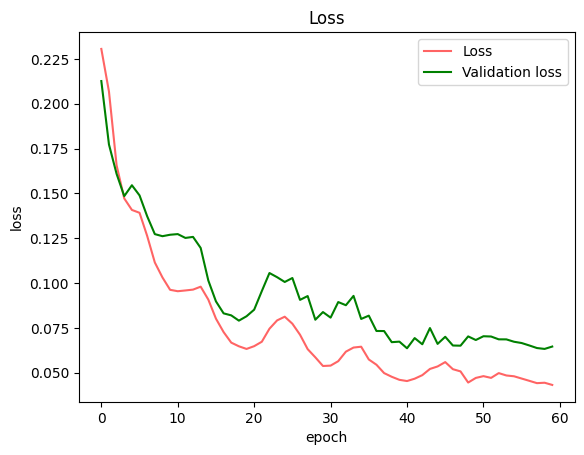

step 1, accuracy_train:0.1375, loss: 0.22811561705602376
step 2, accuracy_train:0.35625, loss: 0.18668723812512933
step 3, accuracy_train:0.5375, loss: 0.155302150282768
step 4, accuracy_train:0.5875, loss: 0.13487038079911018
step 5, accuracy_train:0.571875, loss: 0.11441831282410304
step 6, accuracy_train:0.6625, loss: 0.1126196429292055
step 7, accuracy_train:0.6875, loss: 0.11598603491014017
step 8, accuracy_train:0.740625, loss: 0.10990405909061227
step 9, accuracy_train:0.71875, loss: 0.10679630625606137
step 10, accuracy_train:0.73125, loss: 0.10027373661508192
step 11, accuracy_train:0.70625, loss: 0.09455585936352215
step 12, accuracy_train:0.70625, loss: 0.09064651912851163
step 13, accuracy_train:0.75625, loss: 0.09619314821283953
step 14, accuracy_train:0.75, loss: 0.10000201789075874
step 15, accuracy_train:0.734375, loss: 0.09869115833560944
step 16, accuracy_train:0.75, loss: 0.09098315692387793
step 17, accuracy_train:0.753125, loss: 0.08790224383912149
step 18, accurac

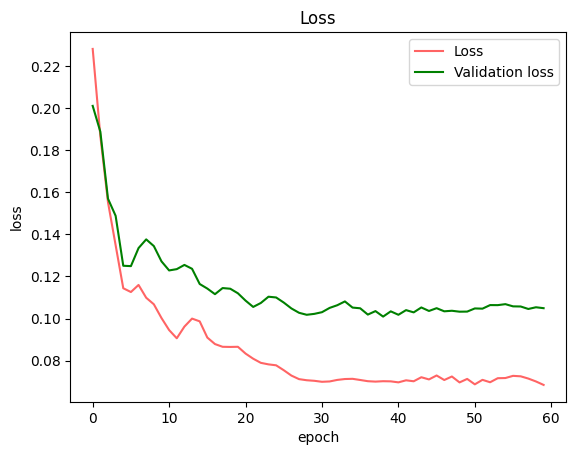

step 1, accuracy_train:0.128125, loss: 0.2413470067483432
step 2, accuracy_train:0.3125, loss: 0.18697361935213858
step 3, accuracy_train:0.428125, loss: 0.1629931065745152
step 4, accuracy_train:0.546875, loss: 0.15499675045659417
step 5, accuracy_train:0.675, loss: 0.13126502988011757
step 6, accuracy_train:0.634375, loss: 0.13292665357758232
step 7, accuracy_train:0.625, loss: 0.11931718804067215
step 8, accuracy_train:0.625, loss: 0.10513796312024089
step 9, accuracy_train:0.640625, loss: 0.09627992065219351
step 10, accuracy_train:0.6875, loss: 0.09364973970874158
step 11, accuracy_train:0.725, loss: 0.09053070163761276
step 12, accuracy_train:0.721875, loss: 0.09323096316872614
step 13, accuracy_train:0.69375, loss: 0.09818418545714927
step 14, accuracy_train:0.7, loss: 0.09069903690065609
step 15, accuracy_train:0.696875, loss: 0.08512417006810277
step 16, accuracy_train:0.709375, loss: 0.08032267995354544
step 17, accuracy_train:0.684375, loss: 0.07834781502904689
step 18, accu

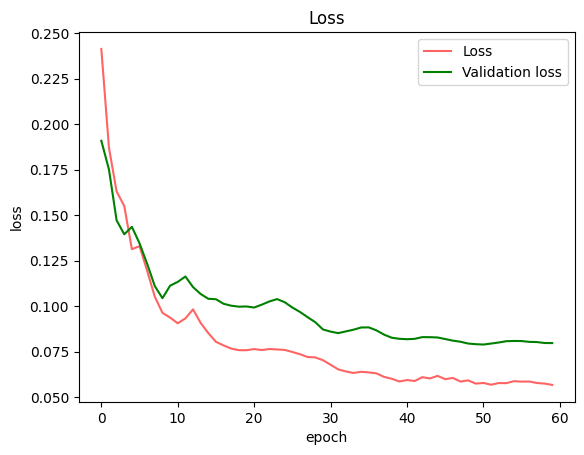

step 1, accuracy_train:0.13125, loss: 0.23065562282920396
step 2, accuracy_train:0.13125, loss: 0.22508371578721717
step 3, accuracy_train:0.365625, loss: 0.15717936863999116
step 4, accuracy_train:0.575, loss: 0.15556508677563147
step 5, accuracy_train:0.571875, loss: 0.16545465086103822
step 6, accuracy_train:0.690625, loss: 0.16668551007606097
step 7, accuracy_train:0.69375, loss: 0.14552622730328887
step 8, accuracy_train:0.746875, loss: 0.11245142763934378
step 9, accuracy_train:0.740625, loss: 0.095870453758823
step 10, accuracy_train:0.78125, loss: 0.08351245733569132
step 11, accuracy_train:0.8, loss: 0.07651980289052082
step 12, accuracy_train:0.8125, loss: 0.07190129800923649
step 13, accuracy_train:0.85, loss: 0.07064167558126319
step 14, accuracy_train:0.865625, loss: 0.07346574727067967
step 15, accuracy_train:0.85, loss: 0.07546397506283027
step 16, accuracy_train:0.865625, loss: 0.07473238598807078
step 17, accuracy_train:0.871875, loss: 0.07296685181727004
step 18, accu

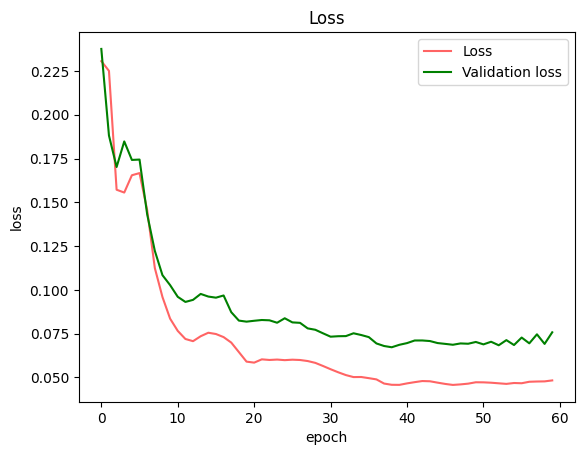

cv_time ：166.669816 s
((0.15, 0.05, 0.01), 60, 300, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.40625, loss: 0.1939904938024569
step 2, accuracy_train:0.684375, loss: 0.12407901938361937
step 3, accuracy_train:0.796875, loss: 0.10469475676353808
step 4, accuracy_train:0.825, loss: 0.09705715191587766
step 5, accuracy_train:0.840625, loss: 0.08955172238062171
step 6, accuracy_train:0.8625, loss: 0.0785837659085044
step 7, accuracy_train:0.825, loss: 0.08345159767943938
step 8, accuracy_train:0.81875, loss: 0.0861285409952856
step 9, accuracy_train:0.825, loss: 0.08790474678652141
step 10, accuracy_train:0.8, loss: 0.08300421646867694
step 11, accuracy_train:0.803125, loss: 0.08892347719341848
step 12, accuracy_train:0.85625, loss: 0.08162191161913367
step 13, accuracy_train:0.83125, loss: 0.08157571287397915
step 14, accuracy_train:0.834375, loss: 0.07914107692254575
step 15, accuracy_train:0.846875, loss: 0.07709697167526823
step 16, accuracy_train:0.84375, loss: 0.079948654576870

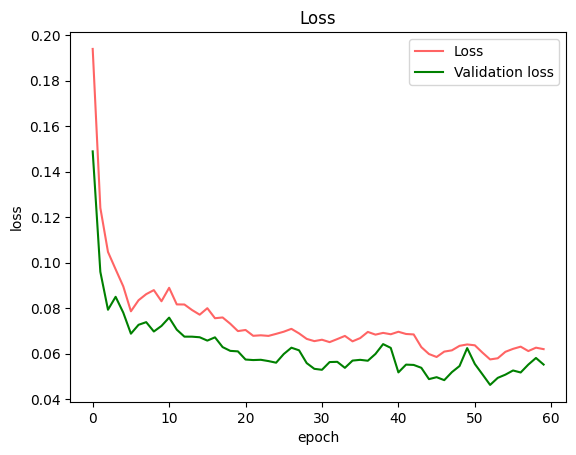

step 1, accuracy_train:0.384375, loss: 0.19955009028987578
step 2, accuracy_train:0.721875, loss: 0.13864346847871298
step 3, accuracy_train:0.78125, loss: 0.1062263546069261
step 4, accuracy_train:0.790625, loss: 0.1100925914246754
step 5, accuracy_train:0.803125, loss: 0.09435094135912739
step 6, accuracy_train:0.846875, loss: 0.09257487159595713
step 7, accuracy_train:0.865625, loss: 0.08821213411987464
step 8, accuracy_train:0.875, loss: 0.07228637501580416
step 9, accuracy_train:0.9, loss: 0.06891305136655061
step 10, accuracy_train:0.9125, loss: 0.07208941518505636
step 11, accuracy_train:0.89375, loss: 0.06016403340945776
step 12, accuracy_train:0.909375, loss: 0.05594277777813697
step 13, accuracy_train:0.90625, loss: 0.05822662574136781
step 14, accuracy_train:0.896875, loss: 0.05670961163858385
step 15, accuracy_train:0.884375, loss: 0.05545151017249484
step 16, accuracy_train:0.896875, loss: 0.05728318329945977
step 17, accuracy_train:0.8875, loss: 0.057430829484070786
step 

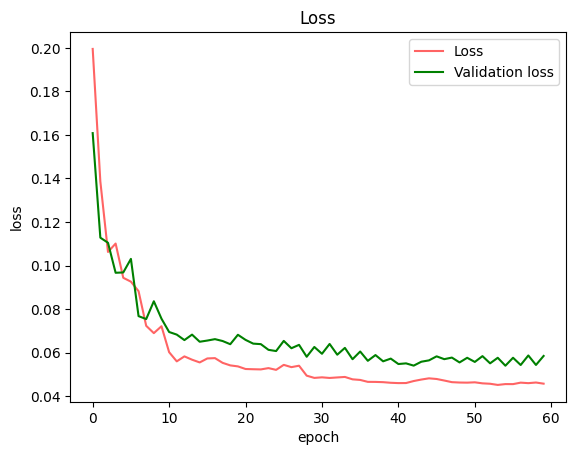

step 1, accuracy_train:0.36875, loss: 0.18748661942814998
step 2, accuracy_train:0.721875, loss: 0.11719908549237767
step 3, accuracy_train:0.84375, loss: 0.08603735358613032
step 4, accuracy_train:0.85625, loss: 0.0828342898029614
step 5, accuracy_train:0.878125, loss: 0.06816888931039627
step 6, accuracy_train:0.8875, loss: 0.06381103165805187
step 7, accuracy_train:0.890625, loss: 0.06468485029906892
step 8, accuracy_train:0.86875, loss: 0.06444801465534433
step 9, accuracy_train:0.865625, loss: 0.0642557401600957
step 10, accuracy_train:0.890625, loss: 0.06388407146767235
step 11, accuracy_train:0.903125, loss: 0.060497087520302514
step 12, accuracy_train:0.9, loss: 0.05916351780659981
step 13, accuracy_train:0.884375, loss: 0.059612817406986325
step 14, accuracy_train:0.884375, loss: 0.05944901724688316
step 15, accuracy_train:0.871875, loss: 0.059374165533973795
step 16, accuracy_train:0.875, loss: 0.057191924965999494
step 17, accuracy_train:0.890625, loss: 0.055049799610453774


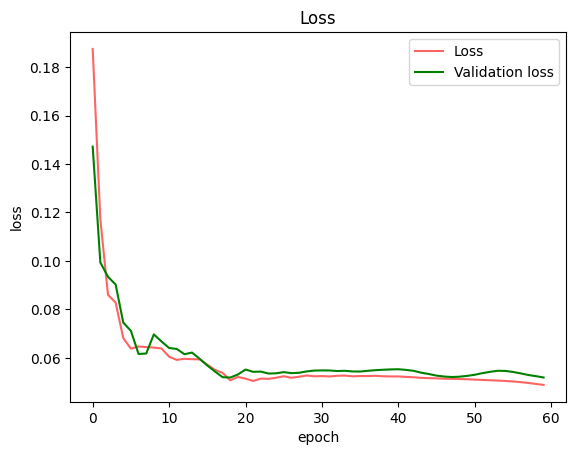

step 1, accuracy_train:0.31875, loss: 0.19886739465933195
step 2, accuracy_train:0.6875, loss: 0.1364950567447472
step 3, accuracy_train:0.803125, loss: 0.10507285845362316
step 4, accuracy_train:0.8375, loss: 0.08944351908166359
step 5, accuracy_train:0.878125, loss: 0.08371381744942637
step 6, accuracy_train:0.871875, loss: 0.07550215455073354
step 7, accuracy_train:0.871875, loss: 0.06944291042676655
step 8, accuracy_train:0.896875, loss: 0.06272947539684853
step 9, accuracy_train:0.890625, loss: 0.06557130034898302
step 10, accuracy_train:0.909375, loss: 0.06394803722943138
step 11, accuracy_train:0.903125, loss: 0.060086201075339206
step 12, accuracy_train:0.909375, loss: 0.05918285314937242
step 13, accuracy_train:0.909375, loss: 0.059622667557399464
step 14, accuracy_train:0.890625, loss: 0.059502002546385144
step 15, accuracy_train:0.903125, loss: 0.05655645020887396
step 16, accuracy_train:0.90625, loss: 0.055720170818819414
step 17, accuracy_train:0.903125, loss: 0.0556553999

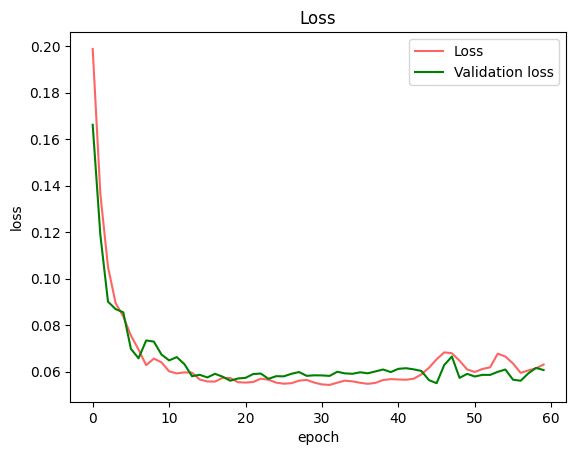

step 1, accuracy_train:0.30625, loss: 0.19740729697520337
step 2, accuracy_train:0.603125, loss: 0.14178421533060356
step 3, accuracy_train:0.784375, loss: 0.10943809797303058
step 4, accuracy_train:0.834375, loss: 0.12061612205903473
step 5, accuracy_train:0.84375, loss: 0.09029197785494289
step 6, accuracy_train:0.8375, loss: 0.08222862726528239
step 7, accuracy_train:0.846875, loss: 0.08440614455411628
step 8, accuracy_train:0.884375, loss: 0.07672658960589164
step 9, accuracy_train:0.853125, loss: 0.07067709531911005
step 10, accuracy_train:0.8875, loss: 0.06488742324252712
step 11, accuracy_train:0.878125, loss: 0.06561664555426823
step 12, accuracy_train:0.9, loss: 0.06446506787127483
step 13, accuracy_train:0.896875, loss: 0.0669531902457136
step 14, accuracy_train:0.890625, loss: 0.06364784946905247
step 15, accuracy_train:0.909375, loss: 0.06339827836081213
step 16, accuracy_train:0.896875, loss: 0.062102645368142535
step 17, accuracy_train:0.875, loss: 0.06964586635131412
ste

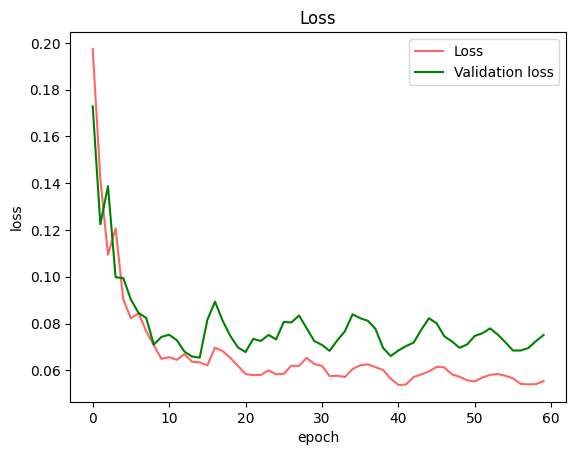

cv_time ：167.639617 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 50, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.275, loss: 0.2173501125067964
step 2, accuracy_train:0.48125, loss: 0.17494576338591888
step 3, accuracy_train:0.65625, loss: 0.13496128061945728
step 4, accuracy_train:0.684375, loss: 0.1175582062027315
step 5, accuracy_train:0.753125, loss: 0.1128539881497575
step 6, accuracy_train:0.76875, loss: 0.11685380271354104
step 7, accuracy_train:0.759375, loss: 0.11678797054094756
step 8, accuracy_train:0.790625, loss: 0.10209516834862012
step 9, accuracy_train:0.79375, loss: 0.09572522530832789
step 10, accuracy_train:0.80625, loss: 0.09189616490368374
step 11, accuracy_train:0.796875, loss: 0.09641456386532171
step 12, accuracy_train:0.81875, loss: 0.09898232490408232
step 13, accuracy_train:0.83125, loss: 0.09365842022240545
step 14, accuracy_train:0.85, loss: 0.08835441774642273
step 15, accuracy_train:0.865625, loss: 0.08819278534629282
step 16, accuracy_train:0.8375, loss

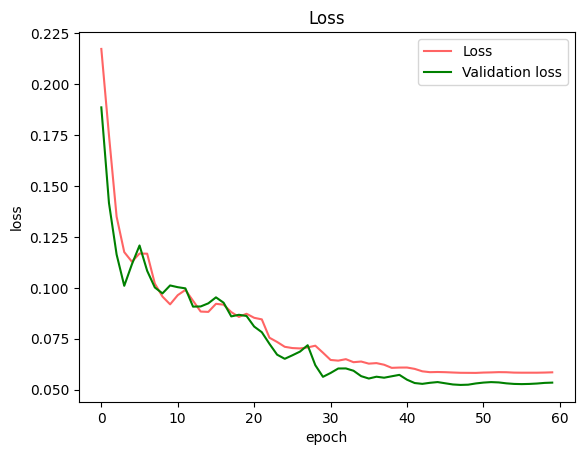

step 1, accuracy_train:0.26875, loss: 0.20512683030916518
step 2, accuracy_train:0.490625, loss: 0.14552596584442187
step 3, accuracy_train:0.7625, loss: 0.11336942095907644
step 4, accuracy_train:0.828125, loss: 0.09827431977272874
step 5, accuracy_train:0.86875, loss: 0.09143201609512154
step 6, accuracy_train:0.859375, loss: 0.08705466101801898
step 7, accuracy_train:0.878125, loss: 0.07170096492286902
step 8, accuracy_train:0.8875, loss: 0.06573345424849408
step 9, accuracy_train:0.909375, loss: 0.061821969309863334
step 10, accuracy_train:0.875, loss: 0.06229310450248794
step 11, accuracy_train:0.8625, loss: 0.06506064751610335
step 12, accuracy_train:0.875, loss: 0.059350067523200926
step 13, accuracy_train:0.878125, loss: 0.05541445787955211
step 14, accuracy_train:0.88125, loss: 0.054400331661261084
step 15, accuracy_train:0.88125, loss: 0.05420167896697023
step 16, accuracy_train:0.878125, loss: 0.0549566050435978
step 17, accuracy_train:0.878125, loss: 0.0545977296260343
step

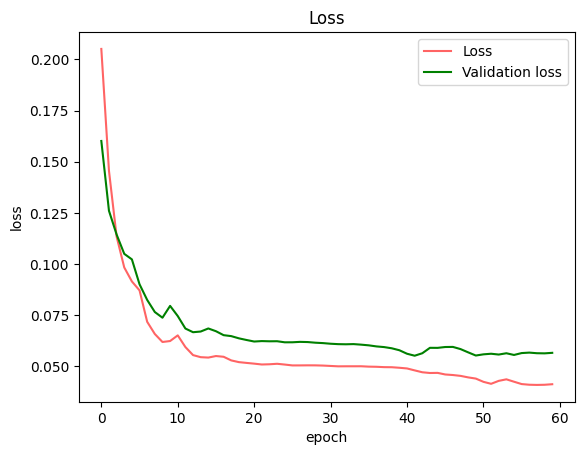

step 1, accuracy_train:0.30625, loss: 0.20648074753042214
step 2, accuracy_train:0.55, loss: 0.15241669911304334
step 3, accuracy_train:0.8, loss: 0.11209392750247835
step 4, accuracy_train:0.809375, loss: 0.10224409229488488
step 5, accuracy_train:0.778125, loss: 0.09763539536137829
step 6, accuracy_train:0.828125, loss: 0.11776370136265361
step 7, accuracy_train:0.79375, loss: 0.13530067331508072
step 8, accuracy_train:0.8625, loss: 0.10499054105643311
step 9, accuracy_train:0.84375, loss: 0.08315088118360353
step 10, accuracy_train:0.859375, loss: 0.07784250292252265
step 11, accuracy_train:0.86875, loss: 0.08063714025543489
step 12, accuracy_train:0.853125, loss: 0.08521334971457206
step 13, accuracy_train:0.875, loss: 0.08391378213483311
step 14, accuracy_train:0.8625, loss: 0.08096917568488035
step 15, accuracy_train:0.86875, loss: 0.07975010094932866
step 16, accuracy_train:0.8875, loss: 0.07917392481792326
step 17, accuracy_train:0.878125, loss: 0.07957350678836604
step 18, acc

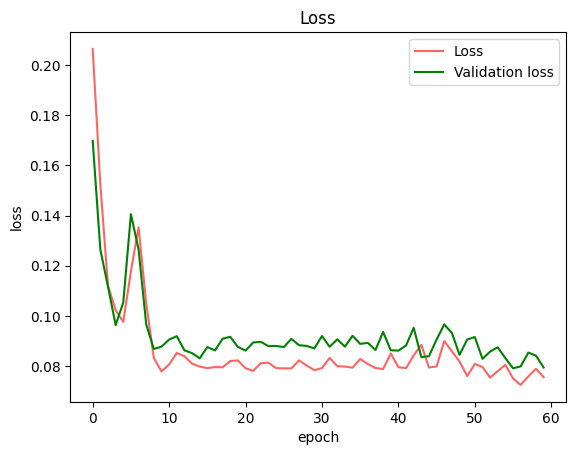

step 1, accuracy_train:0.33125, loss: 0.19797666862274216
step 2, accuracy_train:0.659375, loss: 0.1469204357292127
step 3, accuracy_train:0.6625, loss: 0.12216736091674614
step 4, accuracy_train:0.796875, loss: 0.11309738350454812
step 5, accuracy_train:0.771875, loss: 0.11280657129476046
step 6, accuracy_train:0.8125, loss: 0.11134040263910658
step 7, accuracy_train:0.83125, loss: 0.09919203313329022
step 8, accuracy_train:0.859375, loss: 0.08084935209136668
step 9, accuracy_train:0.86875, loss: 0.08828154688804712
step 10, accuracy_train:0.8875, loss: 0.07598724207966276
step 11, accuracy_train:0.86875, loss: 0.06456232383430108
step 12, accuracy_train:0.9, loss: 0.07120071923596878
step 13, accuracy_train:0.85, loss: 0.06958036368427725
step 14, accuracy_train:0.88125, loss: 0.06301476368913973
step 15, accuracy_train:0.9125, loss: 0.05337030853102048
step 16, accuracy_train:0.90625, loss: 0.050757057126567126
step 17, accuracy_train:0.88125, loss: 0.05517900695454758
step 18, accu

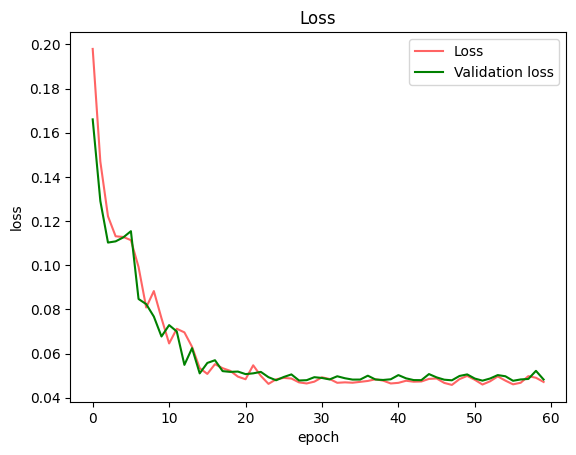

step 1, accuracy_train:0.325, loss: 0.19840913028769075
step 2, accuracy_train:0.446875, loss: 0.16491196983520268
step 3, accuracy_train:0.6875, loss: 0.13701301625995896
step 4, accuracy_train:0.721875, loss: 0.12620296463808872
step 5, accuracy_train:0.771875, loss: 0.10526854437789449
step 6, accuracy_train:0.815625, loss: 0.10160299347271082
step 7, accuracy_train:0.865625, loss: 0.09164407642126157
step 8, accuracy_train:0.871875, loss: 0.07383725674240882
step 9, accuracy_train:0.884375, loss: 0.06675386630528936
step 10, accuracy_train:0.884375, loss: 0.061973448834788114
step 11, accuracy_train:0.9, loss: 0.058661632043447154
step 12, accuracy_train:0.871875, loss: 0.061348713259059544
step 13, accuracy_train:0.896875, loss: 0.05746130522490873
step 14, accuracy_train:0.884375, loss: 0.05719385623753677
step 15, accuracy_train:0.8875, loss: 0.05553107208195428
step 16, accuracy_train:0.88125, loss: 0.0564277176267866
step 17, accuracy_train:0.875, loss: 0.0565158068478038
step

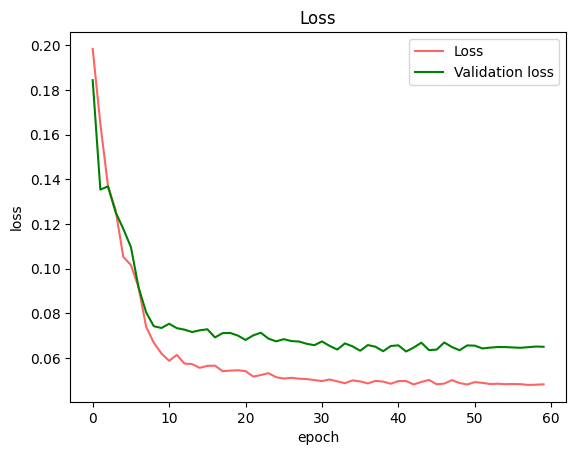

cv_time ：173.861508 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 100, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.146875, loss: 0.2275982863791554
step 2, accuracy_train:0.378125, loss: 0.17188116239562867
step 3, accuracy_train:0.51875, loss: 0.15235119020591814
step 4, accuracy_train:0.58125, loss: 0.12758641590902878
step 5, accuracy_train:0.575, loss: 0.13005666339580788
step 6, accuracy_train:0.571875, loss: 0.12429024716004361
step 7, accuracy_train:0.61875, loss: 0.11877645147826733
step 8, accuracy_train:0.653125, loss: 0.11549270391344305
step 9, accuracy_train:0.66875, loss: 0.10688151120018594
step 10, accuracy_train:0.659375, loss: 0.10750059528058405
step 11, accuracy_train:0.640625, loss: 0.10596685829334673
step 12, accuracy_train:0.665625, loss: 0.0987572322581887
step 13, accuracy_train:0.684375, loss: 0.097406715274383
step 14, accuracy_train:0.709375, loss: 0.09452312155247775
step 15, accuracy_train:0.73125, loss: 0.09250526322775342
step 16, accuracy_train:0.7218

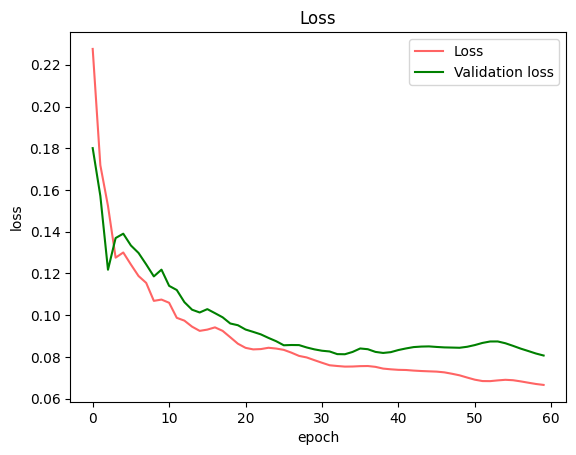

step 1, accuracy_train:0.146875, loss: 0.2305082909026603
step 2, accuracy_train:0.34375, loss: 0.20674876167172423
step 3, accuracy_train:0.296875, loss: 0.16560849002432693
step 4, accuracy_train:0.540625, loss: 0.1471672460151543
step 5, accuracy_train:0.6, loss: 0.14076114394319866
step 6, accuracy_train:0.615625, loss: 0.1391657961955261
step 7, accuracy_train:0.684375, loss: 0.12626024864213545
step 8, accuracy_train:0.634375, loss: 0.11148142997909187
step 9, accuracy_train:0.65, loss: 0.10312663090762772
step 10, accuracy_train:0.675, loss: 0.0962367266813505
step 11, accuracy_train:0.66875, loss: 0.09544942907150912
step 12, accuracy_train:0.690625, loss: 0.09587809168277098
step 13, accuracy_train:0.734375, loss: 0.09634919049842308
step 14, accuracy_train:0.746875, loss: 0.09798583738160499
step 15, accuracy_train:0.76875, loss: 0.09078022925601195
step 16, accuracy_train:0.815625, loss: 0.08015124851739719
step 17, accuracy_train:0.821875, loss: 0.0726753517571005
step 18, 

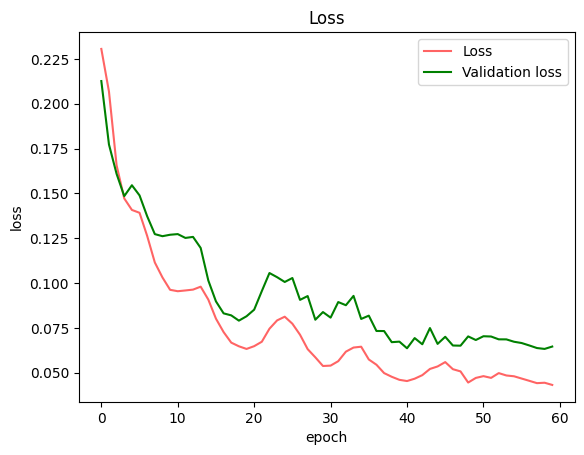

step 1, accuracy_train:0.1375, loss: 0.22811561705602376
step 2, accuracy_train:0.35625, loss: 0.18668723812512933
step 3, accuracy_train:0.5375, loss: 0.155302150282768
step 4, accuracy_train:0.5875, loss: 0.13487038079911018
step 5, accuracy_train:0.571875, loss: 0.11441831282410304
step 6, accuracy_train:0.6625, loss: 0.1126196429292055
step 7, accuracy_train:0.6875, loss: 0.11598603491014017
step 8, accuracy_train:0.740625, loss: 0.10990405909061227
step 9, accuracy_train:0.71875, loss: 0.10679630625606137
step 10, accuracy_train:0.73125, loss: 0.10027373661508192
step 11, accuracy_train:0.70625, loss: 0.09455585936352215
step 12, accuracy_train:0.70625, loss: 0.09064651912851163
step 13, accuracy_train:0.75625, loss: 0.09619314821283953
step 14, accuracy_train:0.75, loss: 0.10000201789075874
step 15, accuracy_train:0.734375, loss: 0.09869115833560944
step 16, accuracy_train:0.75, loss: 0.09098315692387793
step 17, accuracy_train:0.753125, loss: 0.08790224383912149
step 18, accurac

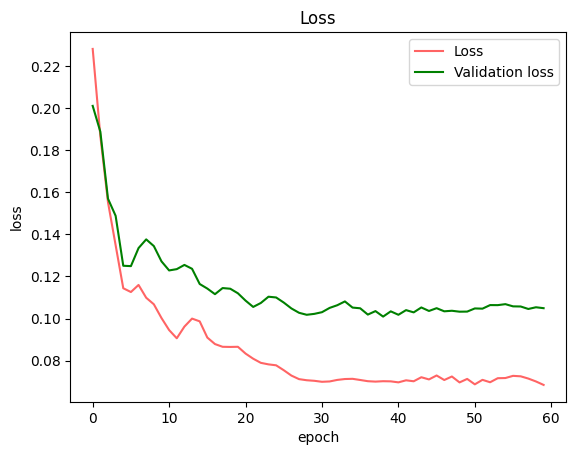

step 1, accuracy_train:0.128125, loss: 0.2413470067483432
step 2, accuracy_train:0.3125, loss: 0.18697361935213858
step 3, accuracy_train:0.428125, loss: 0.1629931065745152
step 4, accuracy_train:0.546875, loss: 0.15499675045659417
step 5, accuracy_train:0.675, loss: 0.13126502988011757
step 6, accuracy_train:0.634375, loss: 0.13292665357758232
step 7, accuracy_train:0.625, loss: 0.11931718804067215
step 8, accuracy_train:0.625, loss: 0.10513796312024089
step 9, accuracy_train:0.640625, loss: 0.09627992065219351
step 10, accuracy_train:0.6875, loss: 0.09364973970874158
step 11, accuracy_train:0.725, loss: 0.09053070163761276
step 12, accuracy_train:0.721875, loss: 0.09323096316872614
step 13, accuracy_train:0.69375, loss: 0.09818418545714927
step 14, accuracy_train:0.7, loss: 0.09069903690065609
step 15, accuracy_train:0.696875, loss: 0.08512417006810277
step 16, accuracy_train:0.709375, loss: 0.08032267995354544
step 17, accuracy_train:0.684375, loss: 0.07834781502904689
step 18, accu

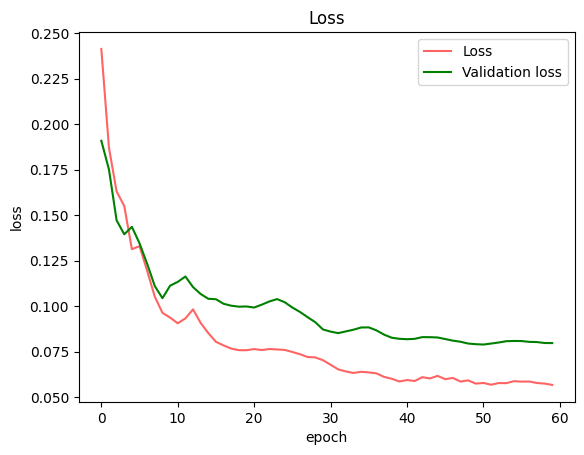

step 1, accuracy_train:0.13125, loss: 0.23065562282920396
step 2, accuracy_train:0.13125, loss: 0.22508371578721717
step 3, accuracy_train:0.365625, loss: 0.15717936863999116
step 4, accuracy_train:0.575, loss: 0.15556508677563147
step 5, accuracy_train:0.571875, loss: 0.16545465086103822
step 6, accuracy_train:0.690625, loss: 0.16668551007606097
step 7, accuracy_train:0.69375, loss: 0.14552622730328887
step 8, accuracy_train:0.746875, loss: 0.11245142763934378
step 9, accuracy_train:0.740625, loss: 0.095870453758823
step 10, accuracy_train:0.78125, loss: 0.08351245733569132
step 11, accuracy_train:0.8, loss: 0.07651980289052082
step 12, accuracy_train:0.8125, loss: 0.07190129800923649
step 13, accuracy_train:0.85, loss: 0.07064167558126319
step 14, accuracy_train:0.865625, loss: 0.07346574727067967
step 15, accuracy_train:0.85, loss: 0.07546397506283027
step 16, accuracy_train:0.865625, loss: 0.07473238598807078
step 17, accuracy_train:0.871875, loss: 0.07296685181727004
step 18, accu

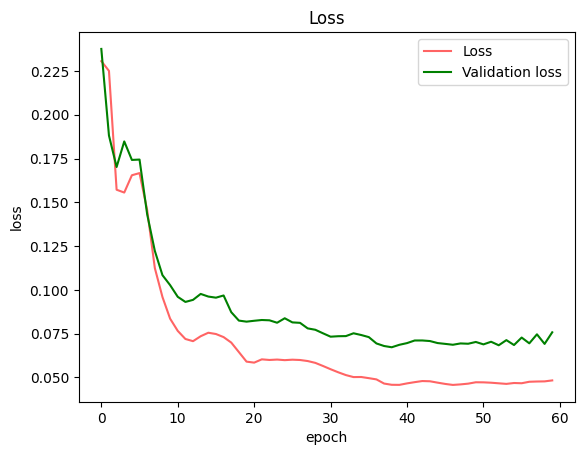

cv_time ：169.532071 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 300, 50, (0.05, 0.03, 0.01))


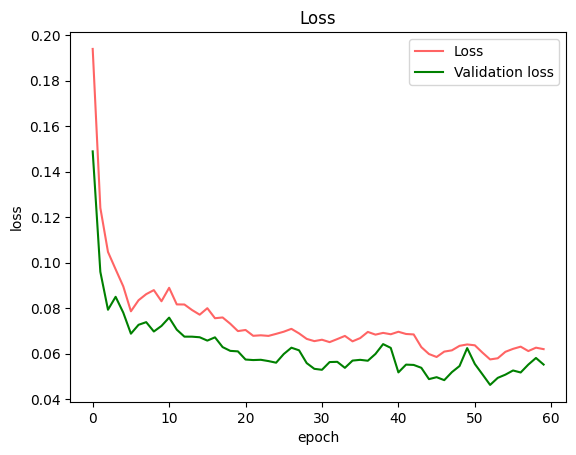

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.5, loss: 0.18002105029554594
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 2, accuracy_train:0.759375, loss: 0.13855494796642387
step 3, accuracy_train:0.7875, loss: 0.10675010817859999
step 4, accuracy_train:0.828125, loss: 0.09233480897403852
step 5, accuracy_train:0.875, loss: 0.07681663751712982
step 6, accuracy_train:0.878125, loss: 0.07107717945363849
step 7, accuracy_train:0.89375, loss: 0.06313408019832065
step 8, accuracy_train:0.890625, loss: 0.06315053498476896
step 9, accuracy_train:0.896875, loss: 0.05987215075626208
step 10, accuracy_train:0.903125, loss: 0.059679038306434375
step 11, accuracy_train:0.903125, loss: 0.0589452203261334
step 12, accuracy_train:0.896875, loss: 0.056636417736626955
step 13, accuracy_train:0.89375, lo

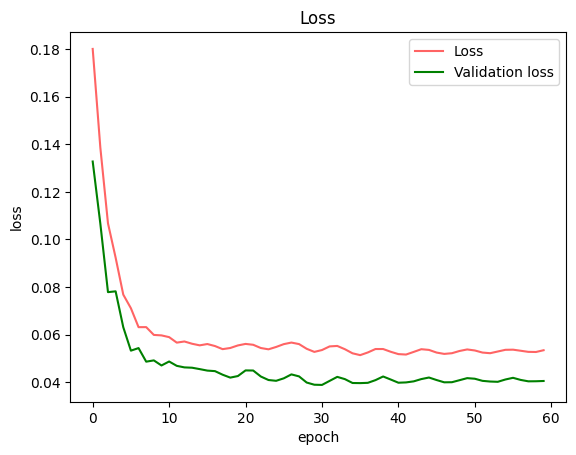

step 1, accuracy_train:0.36875, loss: 0.19641970557983662
step 2, accuracy_train:0.65, loss: 0.1622082273870238
step 3, accuracy_train:0.75, loss: 0.12349412504753413
step 4, accuracy_train:0.81875, loss: 0.11707181912938719
step 5, accuracy_train:0.815625, loss: 0.09514994151562599
step 6, accuracy_train:0.85625, loss: 0.08774319345144845
step 7, accuracy_train:0.840625, loss: 0.09091989719542523
step 8, accuracy_train:0.88125, loss: 0.08094443905521155
step 9, accuracy_train:0.85, loss: 0.07563161035566984
step 10, accuracy_train:0.875, loss: 0.07664197682887698
step 11, accuracy_train:0.890625, loss: 0.070924411882345
step 12, accuracy_train:0.89375, loss: 0.07011696876246917
step 13, accuracy_train:0.896875, loss: 0.07278995977391138
step 14, accuracy_train:0.884375, loss: 0.07244315954341364
step 15, accuracy_train:0.88125, loss: 0.07012083973949594
step 16, accuracy_train:0.88125, loss: 0.06737436264021172
step 17, accuracy_train:0.875, loss: 0.062101864716438054
step 18, accurac

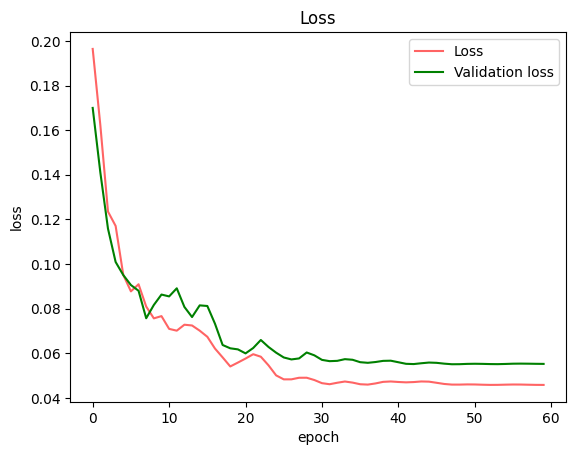

step 1, accuracy_train:0.353125, loss: 0.2007290569712273
step 2, accuracy_train:0.528125, loss: 0.1766439860033167
step 3, accuracy_train:0.71875, loss: 0.14172010127188836
step 4, accuracy_train:0.765625, loss: 0.1237649170265331
step 5, accuracy_train:0.796875, loss: 0.10168058185118212
step 6, accuracy_train:0.86875, loss: 0.09995430414445736
step 7, accuracy_train:0.871875, loss: 0.08317084457069125
step 8, accuracy_train:0.88125, loss: 0.07195537159735094
step 9, accuracy_train:0.875, loss: 0.06778467389451236
step 10, accuracy_train:0.9, loss: 0.06539197216484142
step 11, accuracy_train:0.90625, loss: 0.06297381218282294
step 12, accuracy_train:0.903125, loss: 0.06269296087389899
step 13, accuracy_train:0.90625, loss: 0.06045021616725064
step 14, accuracy_train:0.903125, loss: 0.059398697574029415
step 15, accuracy_train:0.90625, loss: 0.059089067088477734
step 16, accuracy_train:0.896875, loss: 0.059061964830722645
step 17, accuracy_train:0.9, loss: 0.05826221737332712
step 18,

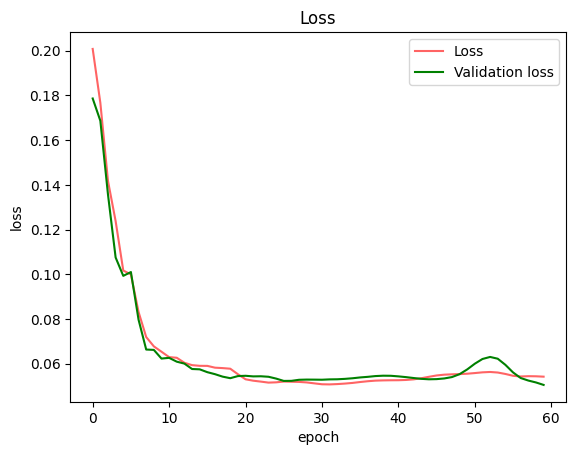

step 1, accuracy_train:0.340625, loss: 0.205928150231092
step 2, accuracy_train:0.54375, loss: 0.17645353677654327
step 3, accuracy_train:0.64375, loss: 0.13828228109478538
step 4, accuracy_train:0.76875, loss: 0.12381480048154107
step 5, accuracy_train:0.828125, loss: 0.10685024949259676
step 6, accuracy_train:0.859375, loss: 0.09690388994416434
step 7, accuracy_train:0.8375, loss: 0.09234634605675655
step 8, accuracy_train:0.890625, loss: 0.07985165739899387
step 9, accuracy_train:0.884375, loss: 0.08317011076093095
step 10, accuracy_train:0.8875, loss: 0.07978306725047073
step 11, accuracy_train:0.884375, loss: 0.07574020145457856
step 12, accuracy_train:0.8875, loss: 0.07512788221697174
step 13, accuracy_train:0.875, loss: 0.0796107888900925
step 14, accuracy_train:0.8875, loss: 0.07701671434287115
step 15, accuracy_train:0.88125, loss: 0.07522134296106008
step 16, accuracy_train:0.878125, loss: 0.07632257468526167
step 17, accuracy_train:0.88125, loss: 0.07356320665924322
step 18,

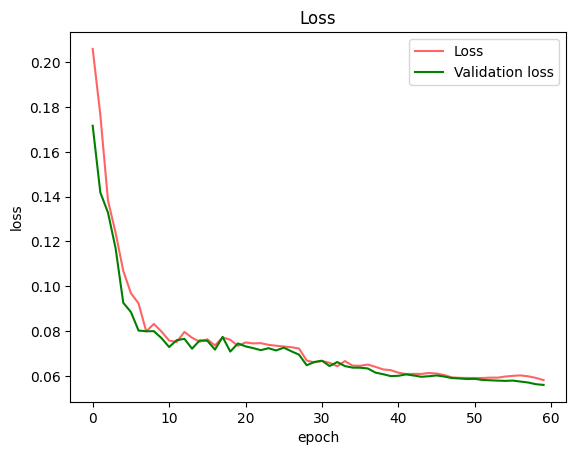

step 1, accuracy_train:0.384375, loss: 0.19862913057250334
step 2, accuracy_train:0.6, loss: 0.17587027733608748
step 3, accuracy_train:0.65, loss: 0.1416220154922172
step 4, accuracy_train:0.746875, loss: 0.11877598008408607
step 5, accuracy_train:0.85, loss: 0.1082216102026288
step 6, accuracy_train:0.7625, loss: 0.11808368498817924
step 7, accuracy_train:0.8125, loss: 0.10851431878218039
step 8, accuracy_train:0.809375, loss: 0.09495823180510951
step 9, accuracy_train:0.80625, loss: 0.09833477509066801
step 10, accuracy_train:0.775, loss: 0.10863485734024929
step 11, accuracy_train:0.8, loss: 0.09619619978094501
step 12, accuracy_train:0.8375, loss: 0.09609713621803258
step 13, accuracy_train:0.85625, loss: 0.09138690864914013
step 14, accuracy_train:0.85625, loss: 0.08870011699630896
step 15, accuracy_train:0.8625, loss: 0.08607000911550644
step 16, accuracy_train:0.8625, loss: 0.07477471746386466
step 17, accuracy_train:0.875, loss: 0.07988530185449814
step 18, accuracy_train:0.86

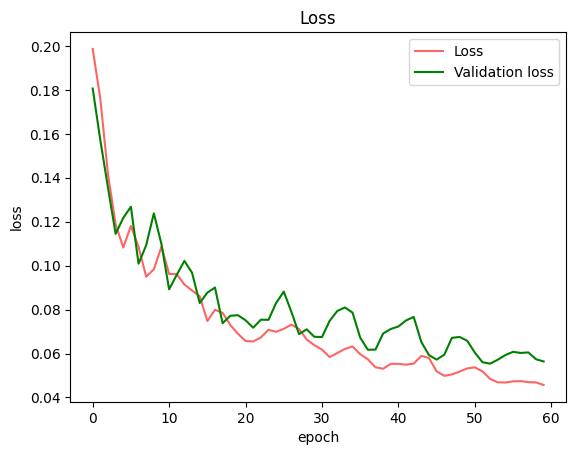

cv_time ：274.472218 s
((0.15, 0.05, 0.01), 60, 50, 50, (0.05, 0.03, 0.01))
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.453125, loss: 0.20338652165559157
step 2, accuracy_train:0.703125, loss: 0.13875229243669285
step 3, accuracy_train:0.74375, loss: 0.14561388906206502
step 4, accuracy_train:0.803125, loss: 0.1203446931837695
step 5, accuracy_train:0.859375, loss: 0.10119121493188724
step 6, accuracy_train:0.809375, loss: 0.08728517128405285
step 7, accuracy_train:0.796875, loss: 0.08232586341031664
step 8, accuracy_train:0.840625, loss: 0.07324476684161738
step 9, accuracy_train:0.85625, loss: 0.07199011017849377
step 10, accuracy_train:0.86875, loss: 0.06644136110881141
step 11, accuracy_train:0.875, loss: 0.059300440505281396
step 12, accuracy_train:0.903125, loss: 0.06046006976460362
step 13, accuracy_train:0.90625, loss: 0.0601956543983343
step 14, accuracy_train:0.909375, loss: 0.05762040627040858
step 15, accur

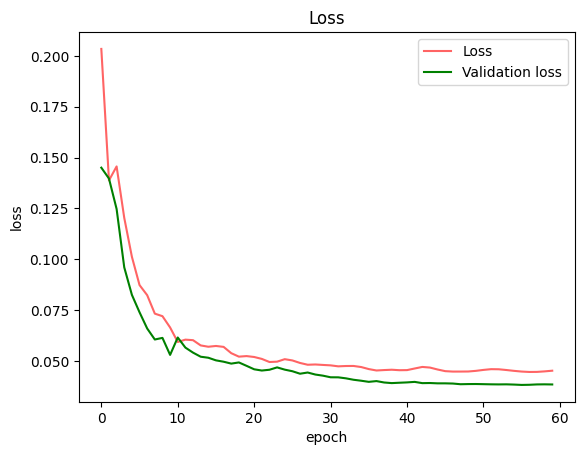

step 1, accuracy_train:0.375, loss: 0.2142833594091566
step 2, accuracy_train:0.578125, loss: 0.14999064345782165
step 3, accuracy_train:0.76875, loss: 0.13602988116251086
step 4, accuracy_train:0.775, loss: 0.1119697051047729
step 5, accuracy_train:0.840625, loss: 0.09507296694003338
step 6, accuracy_train:0.896875, loss: 0.08922798821920623
step 7, accuracy_train:0.896875, loss: 0.07950032224243793
step 8, accuracy_train:0.88125, loss: 0.07519432234083744
step 9, accuracy_train:0.9, loss: 0.07139647576793787
step 10, accuracy_train:0.91875, loss: 0.0680980008478853
step 11, accuracy_train:0.9125, loss: 0.0673029888114125
step 12, accuracy_train:0.9125, loss: 0.06335218886005234
step 13, accuracy_train:0.91875, loss: 0.060398716995191636
step 14, accuracy_train:0.925, loss: 0.05918837340435577
step 15, accuracy_train:0.91875, loss: 0.056839931617499395
step 16, accuracy_train:0.928125, loss: 0.05525149498023735
step 17, accuracy_train:0.928125, loss: 0.05310544056636296
step 18, accur

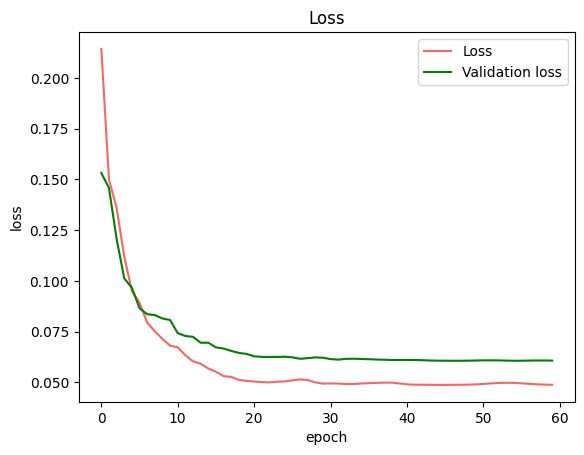

step 1, accuracy_train:0.4, loss: 0.20999559765605308
step 2, accuracy_train:0.68125, loss: 0.16020504865963814
step 3, accuracy_train:0.728125, loss: 0.16038817784416345
step 4, accuracy_train:0.890625, loss: 0.11490505261132165
step 5, accuracy_train:0.859375, loss: 0.08485128828981367
step 6, accuracy_train:0.88125, loss: 0.07413780700720932
step 7, accuracy_train:0.8875, loss: 0.06909386339492661
step 8, accuracy_train:0.90625, loss: 0.060979162134784784
step 9, accuracy_train:0.903125, loss: 0.06073288068173593
step 10, accuracy_train:0.9125, loss: 0.05464907981679776
step 11, accuracy_train:0.915625, loss: 0.05361626120313047
step 12, accuracy_train:0.925, loss: 0.05250184957641983
step 13, accuracy_train:0.921875, loss: 0.05195069564755277
step 14, accuracy_train:0.928125, loss: 0.05035204823384411
step 15, accuracy_train:0.925, loss: 0.04906824530418472
step 16, accuracy_train:0.915625, loss: 0.04925460138805464
step 17, accuracy_train:0.9125, loss: 0.049662821918792975
step 18

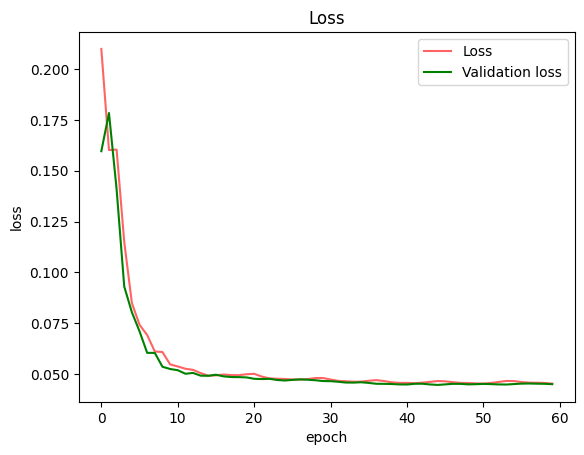

step 1, accuracy_train:0.425, loss: 0.21494817248372447
step 2, accuracy_train:0.665625, loss: 0.1413768903368483
step 3, accuracy_train:0.7625, loss: 0.1423195168714977
step 4, accuracy_train:0.76875, loss: 0.11426436686672545
step 5, accuracy_train:0.8125, loss: 0.09042759204977616
step 6, accuracy_train:0.859375, loss: 0.08197280130046097
step 7, accuracy_train:0.865625, loss: 0.07466001672255101
step 8, accuracy_train:0.859375, loss: 0.07455579301894487
step 9, accuracy_train:0.909375, loss: 0.07467988093743219
step 10, accuracy_train:0.903125, loss: 0.06704485508404869
step 11, accuracy_train:0.93125, loss: 0.06281871309066087
step 12, accuracy_train:0.9, loss: 0.06371502087487194
step 13, accuracy_train:0.928125, loss: 0.05697459218515974
step 14, accuracy_train:0.925, loss: 0.05704090167220331
step 15, accuracy_train:0.928125, loss: 0.05523763704689279
step 16, accuracy_train:0.921875, loss: 0.05507068181220912
step 17, accuracy_train:0.915625, loss: 0.05551483503489939
step 18,

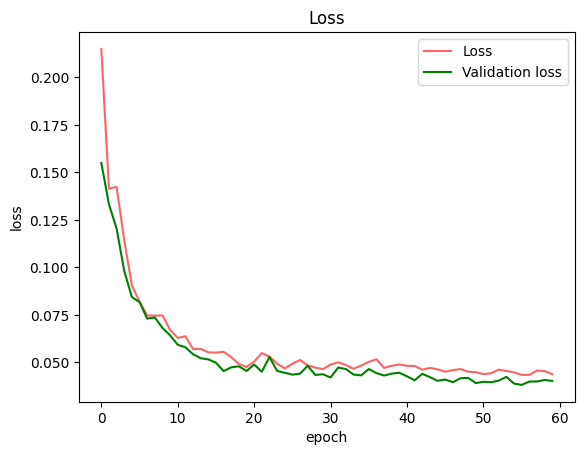

step 1, accuracy_train:0.425, loss: 0.21389286475296435
step 2, accuracy_train:0.71875, loss: 0.14367323592022346
step 3, accuracy_train:0.78125, loss: 0.14424297582171697
step 4, accuracy_train:0.784375, loss: 0.11898864114385456
step 5, accuracy_train:0.809375, loss: 0.09035557071939036
step 6, accuracy_train:0.84375, loss: 0.09298734905719791
step 7, accuracy_train:0.871875, loss: 0.0782110278647743
step 8, accuracy_train:0.825, loss: 0.0778667746365921
step 9, accuracy_train:0.846875, loss: 0.07675246177509076
step 10, accuracy_train:0.89375, loss: 0.06738202145549975
step 11, accuracy_train:0.884375, loss: 0.06906921664195347
step 12, accuracy_train:0.890625, loss: 0.06646650153437389
step 13, accuracy_train:0.878125, loss: 0.06521986986044004
step 14, accuracy_train:0.878125, loss: 0.06325670352682149
step 15, accuracy_train:0.865625, loss: 0.0631449074802044
step 16, accuracy_train:0.878125, loss: 0.05941933441900021
step 17, accuracy_train:0.88125, loss: 0.05801433902629689
ste

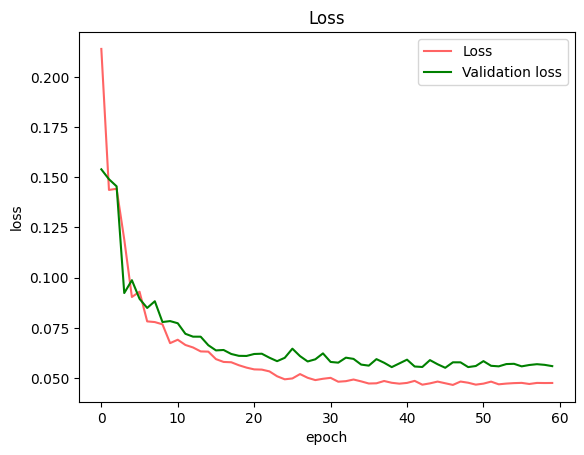

cv_time ：249.962470 s
((0.15, 0.05, 0.01), 60, 100, 50, (0.05, 0.03, 0.01))
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.309375, loss: 0.25763481853926956
step 2, accuracy_train:0.540625, loss: 0.16948859443907954
step 3, accuracy_train:0.3375, loss: 0.1615590304849322
step 4, accuracy_train:0.525, loss: 0.14247796307968322
step 5, accuracy_train:0.74375, loss: 0.13897861590320315
step 6, accuracy_train:0.771875, loss: 0.12743440013613544
step 7, accuracy_train:0.784375, loss: 0.11607472422531413
step 8, accuracy_train:0.81875, loss: 0.10775419933585902
step 9, accuracy_train:0.871875, loss: 0.0957797714036285
step 10, accuracy_train:0.878125, loss: 0.08537734851303709
step 11, accuracy_train:0.890625, loss: 0.07412315475978008
step 12, accuracy_train:0.890625, loss: 0.06472320868372018
step 13, accuracy_train:0.896875, loss: 0.06311184325117991
step 14, accuracy_train:0.89375, loss: 0.06052355758003389
step 15, accura

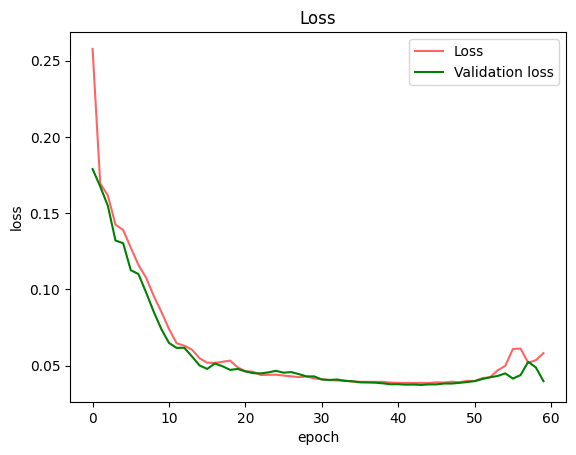

step 1, accuracy_train:0.3, loss: 0.2536738223172177
step 2, accuracy_train:0.56875, loss: 0.16813472006707642
step 3, accuracy_train:0.51875, loss: 0.14420924701659132
step 4, accuracy_train:0.628125, loss: 0.127177175501953
step 5, accuracy_train:0.728125, loss: 0.11727057306490005
step 6, accuracy_train:0.765625, loss: 0.11994904763354246
step 7, accuracy_train:0.8125, loss: 0.12156506396575852
step 8, accuracy_train:0.7875, loss: 0.1197897572037295
step 9, accuracy_train:0.80625, loss: 0.1075334410916314
step 10, accuracy_train:0.878125, loss: 0.09133708631754599
step 11, accuracy_train:0.865625, loss: 0.07732740567129587
step 12, accuracy_train:0.884375, loss: 0.06651454414090356
step 13, accuracy_train:0.86875, loss: 0.059589850243887424
step 14, accuracy_train:0.875, loss: 0.05737774945560603
step 15, accuracy_train:0.9, loss: 0.05570188978281772
step 16, accuracy_train:0.915625, loss: 0.05375272241606107
step 17, accuracy_train:0.915625, loss: 0.05288799128187019
step 18, accur

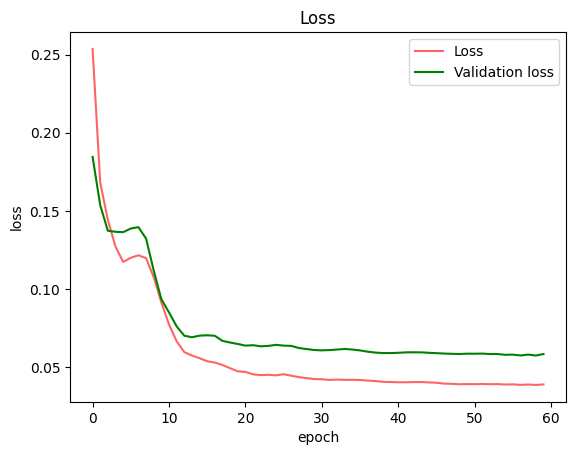

step 1, accuracy_train:0.3, loss: 0.25007201255124634
step 2, accuracy_train:0.5125, loss: 0.16949289768065956
step 3, accuracy_train:0.559375, loss: 0.14486867953282445
step 4, accuracy_train:0.725, loss: 0.11923076555181927
step 5, accuracy_train:0.73125, loss: 0.12805305778432077
step 6, accuracy_train:0.825, loss: 0.11989513784864639
step 7, accuracy_train:0.771875, loss: 0.10795102225190377
step 8, accuracy_train:0.8375, loss: 0.10016020372574272
step 9, accuracy_train:0.875, loss: 0.0827280482387405
step 10, accuracy_train:0.875, loss: 0.07978970146064462
step 11, accuracy_train:0.88125, loss: 0.07253881006649673
step 12, accuracy_train:0.896875, loss: 0.0753987430386014
step 13, accuracy_train:0.890625, loss: 0.07200967706548066
step 14, accuracy_train:0.871875, loss: 0.07358940336192826
step 15, accuracy_train:0.88125, loss: 0.0782000467362377
step 16, accuracy_train:0.890625, loss: 0.07524100791761987
step 17, accuracy_train:0.903125, loss: 0.07648502848858263
step 18, accurac

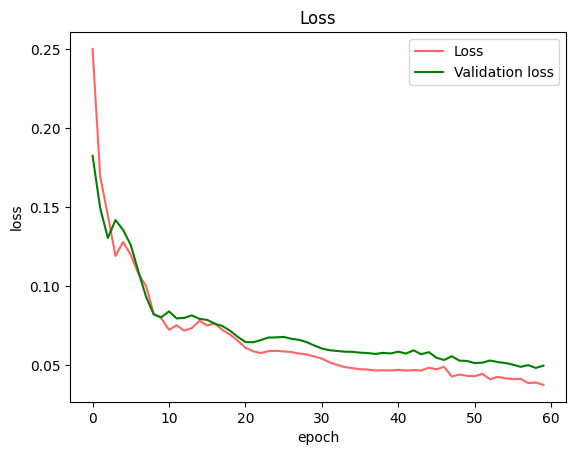

step 1, accuracy_train:0.29375, loss: 0.25238038951687286
step 2, accuracy_train:0.48125, loss: 0.17671831777303232
step 3, accuracy_train:0.3875, loss: 0.14627342845260863
step 4, accuracy_train:0.540625, loss: 0.1411999133774689
step 5, accuracy_train:0.65, loss: 0.1310924944926504
step 6, accuracy_train:0.753125, loss: 0.12578256730934345
step 7, accuracy_train:0.7875, loss: 0.11897072035785894
step 8, accuracy_train:0.875, loss: 0.10869556947495455
step 9, accuracy_train:0.840625, loss: 0.09243455693810479
step 10, accuracy_train:0.840625, loss: 0.08943927998545272
step 11, accuracy_train:0.8625, loss: 0.08505570017555564
step 12, accuracy_train:0.871875, loss: 0.08138936682383266
step 13, accuracy_train:0.8625, loss: 0.07603663509736192
step 14, accuracy_train:0.884375, loss: 0.07353757071956346
step 15, accuracy_train:0.890625, loss: 0.07065528454858949
step 16, accuracy_train:0.890625, loss: 0.0686406368519799
step 17, accuracy_train:0.9125, loss: 0.06732710467244946
step 18, ac

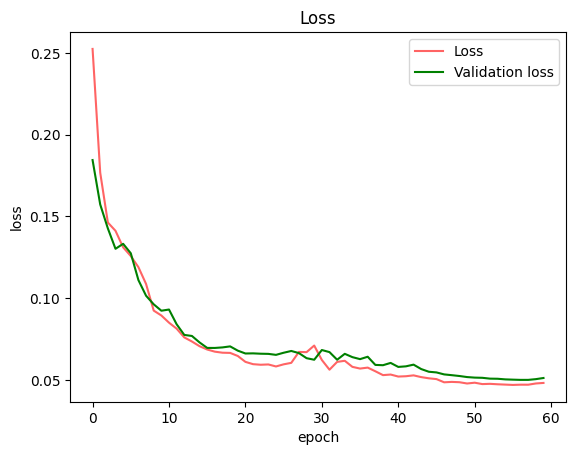

step 1, accuracy_train:0.3, loss: 0.24838036579630815
step 2, accuracy_train:0.553125, loss: 0.1712932840236836
step 3, accuracy_train:0.509375, loss: 0.14723654690229543
step 4, accuracy_train:0.59375, loss: 0.1503193742822027
step 5, accuracy_train:0.640625, loss: 0.14910504992473925
step 6, accuracy_train:0.76875, loss: 0.14331830848604718
step 7, accuracy_train:0.80625, loss: 0.1208238324680404
step 8, accuracy_train:0.83125, loss: 0.10713897847023643
step 9, accuracy_train:0.825, loss: 0.09357964686905601
step 10, accuracy_train:0.846875, loss: 0.08838246344902317
step 11, accuracy_train:0.853125, loss: 0.08300231458054305
step 12, accuracy_train:0.834375, loss: 0.07937714952885025
step 13, accuracy_train:0.871875, loss: 0.07655416419943345
step 14, accuracy_train:0.846875, loss: 0.07179930489460848
step 15, accuracy_train:0.896875, loss: 0.06608338638534353
step 16, accuracy_train:0.9125, loss: 0.05886728597748389
step 17, accuracy_train:0.9125, loss: 0.05459927882256925
step 18,

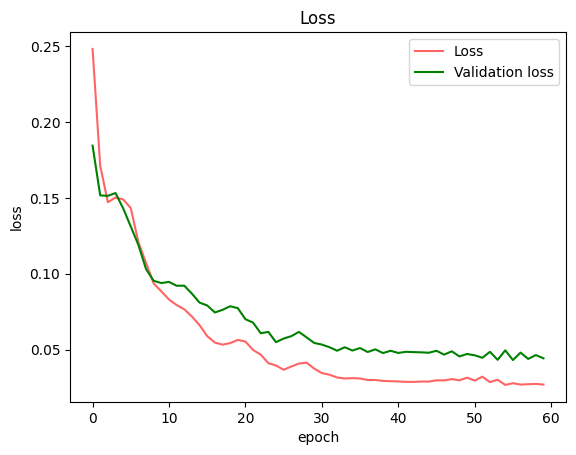

cv_time ：251.510439 s
((0.15, 0.05, 0.01), 60, 300, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.5, loss: 0.18002105029554594
step 2, accuracy_train:0.759375, loss: 0.13855494796642387
step 3, accuracy_train:0.7875, loss: 0.10675010817859999
step 4, accuracy_train:0.828125, loss: 0.09233480897403852
step 5, accuracy_train:0.875, loss: 0.07681663751712982
step 6, accuracy_train:0.878125, loss: 0.07107717945363849
step 7, accuracy_train:0.89375, loss: 0.06313408019832065
step 8, accuracy_train:0.890625, loss: 0.06315053498476896
step 9, accuracy_train:0.896875, loss: 0.05987215075626208
step 10, accuracy_train:0.903125, loss: 0.059679038306434375
step 11, accuracy_train:0.903125, loss: 0.0589452203261334
step 12, accuracy_train:0.896875, loss: 0.056636417736626955
step 13, accuracy_train:0.89375, loss: 0.05711899608929462
step 14, accuracy_train:0.896875, loss: 0.0561664003009769
step 15, accuracy_train:0.909375, loss: 0.05549451717252659
step 16, accuracy_train:0.90625, loss: 0.0560

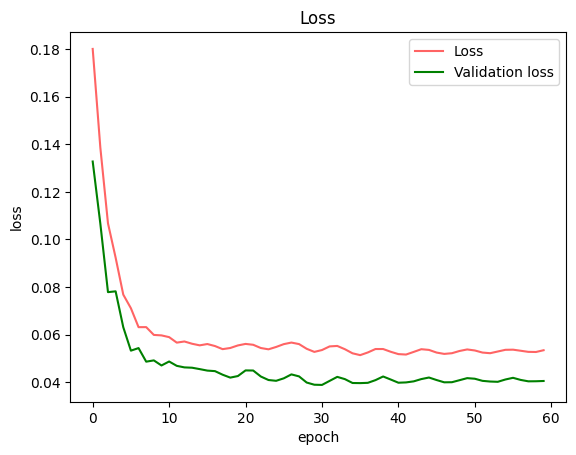

step 1, accuracy_train:0.36875, loss: 0.19641970557983662
step 2, accuracy_train:0.65, loss: 0.1622082273870238
step 3, accuracy_train:0.75, loss: 0.12349412504753413
step 4, accuracy_train:0.81875, loss: 0.11707181912938719
step 5, accuracy_train:0.815625, loss: 0.09514994151562599
step 6, accuracy_train:0.85625, loss: 0.08774319345144845
step 7, accuracy_train:0.840625, loss: 0.09091989719542523
step 8, accuracy_train:0.88125, loss: 0.08094443905521155
step 9, accuracy_train:0.85, loss: 0.07563161035566984
step 10, accuracy_train:0.875, loss: 0.07664197682887698
step 11, accuracy_train:0.890625, loss: 0.070924411882345
step 12, accuracy_train:0.89375, loss: 0.07011696876246917
step 13, accuracy_train:0.896875, loss: 0.07278995977391138
step 14, accuracy_train:0.884375, loss: 0.07244315954341364
step 15, accuracy_train:0.88125, loss: 0.07012083973949594
step 16, accuracy_train:0.88125, loss: 0.06737436264021172
step 17, accuracy_train:0.875, loss: 0.062101864716438054
step 18, accurac

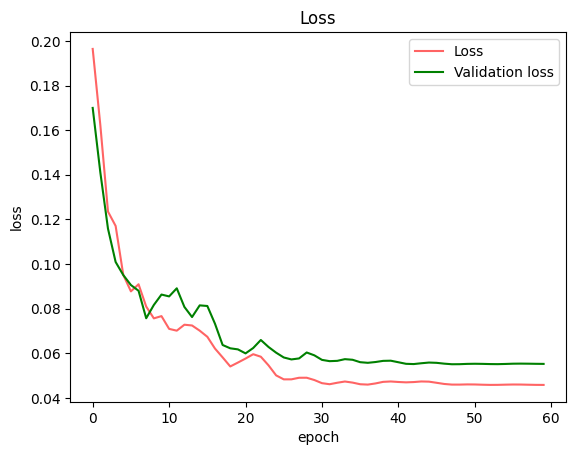

step 1, accuracy_train:0.353125, loss: 0.2007290569712273
step 2, accuracy_train:0.528125, loss: 0.1766439860033167
step 3, accuracy_train:0.71875, loss: 0.14172010127188836
step 4, accuracy_train:0.765625, loss: 0.1237649170265331
step 5, accuracy_train:0.796875, loss: 0.10168058185118212
step 6, accuracy_train:0.86875, loss: 0.09995430414445736
step 7, accuracy_train:0.871875, loss: 0.08317084457069125
step 8, accuracy_train:0.88125, loss: 0.07195537159735094
step 9, accuracy_train:0.875, loss: 0.06778467389451236
step 10, accuracy_train:0.9, loss: 0.06539197216484142
step 11, accuracy_train:0.90625, loss: 0.06297381218282294
step 12, accuracy_train:0.903125, loss: 0.06269296087389899
step 13, accuracy_train:0.90625, loss: 0.06045021616725064
step 14, accuracy_train:0.903125, loss: 0.059398697574029415
step 15, accuracy_train:0.90625, loss: 0.059089067088477734
step 16, accuracy_train:0.896875, loss: 0.059061964830722645
step 17, accuracy_train:0.9, loss: 0.05826221737332712
step 18,

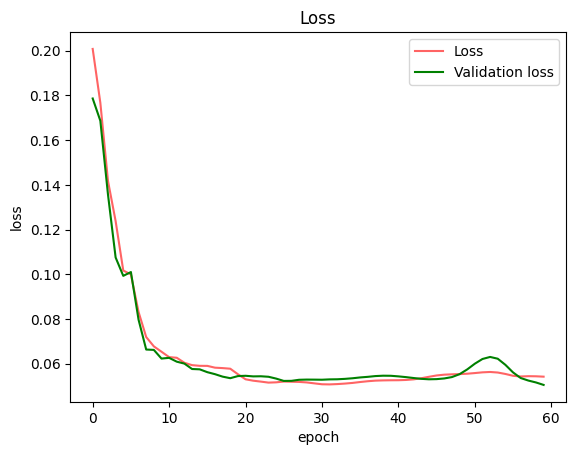

step 1, accuracy_train:0.340625, loss: 0.205928150231092
step 2, accuracy_train:0.54375, loss: 0.17645353677654327
step 3, accuracy_train:0.64375, loss: 0.13828228109478538
step 4, accuracy_train:0.76875, loss: 0.12381480048154107
step 5, accuracy_train:0.828125, loss: 0.10685024949259676
step 6, accuracy_train:0.859375, loss: 0.09690388994416434
step 7, accuracy_train:0.8375, loss: 0.09234634605675655
step 8, accuracy_train:0.890625, loss: 0.07985165739899387
step 9, accuracy_train:0.884375, loss: 0.08317011076093095
step 10, accuracy_train:0.8875, loss: 0.07978306725047073
step 11, accuracy_train:0.884375, loss: 0.07574020145457856
step 12, accuracy_train:0.8875, loss: 0.07512788221697174
step 13, accuracy_train:0.875, loss: 0.0796107888900925
step 14, accuracy_train:0.8875, loss: 0.07701671434287115
step 15, accuracy_train:0.88125, loss: 0.07522134296106008
step 16, accuracy_train:0.878125, loss: 0.07632257468526167
step 17, accuracy_train:0.88125, loss: 0.07356320665924322
step 18,

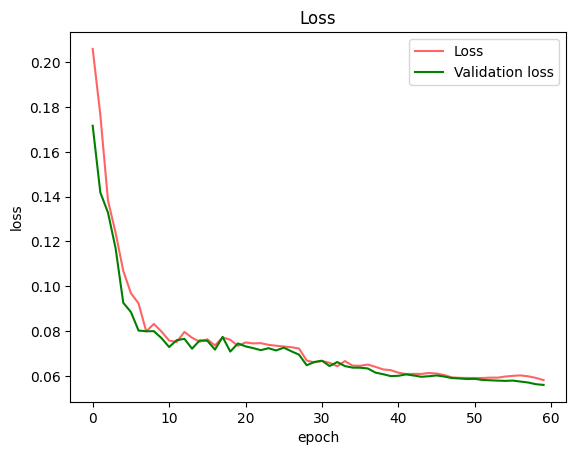

step 1, accuracy_train:0.384375, loss: 0.19862913057250334
step 2, accuracy_train:0.6, loss: 0.17587027733608748
step 3, accuracy_train:0.65, loss: 0.1416220154922172
step 4, accuracy_train:0.746875, loss: 0.11877598008408607
step 5, accuracy_train:0.85, loss: 0.1082216102026288
step 6, accuracy_train:0.7625, loss: 0.11808368498817924
step 7, accuracy_train:0.8125, loss: 0.10851431878218039
step 8, accuracy_train:0.809375, loss: 0.09495823180510951
step 9, accuracy_train:0.80625, loss: 0.09833477509066801
step 10, accuracy_train:0.775, loss: 0.10863485734024929
step 11, accuracy_train:0.8, loss: 0.09619619978094501
step 12, accuracy_train:0.8375, loss: 0.09609713621803258
step 13, accuracy_train:0.85625, loss: 0.09138690864914013
step 14, accuracy_train:0.85625, loss: 0.08870011699630896
step 15, accuracy_train:0.8625, loss: 0.08607000911550644
step 16, accuracy_train:0.8625, loss: 0.07477471746386466
step 17, accuracy_train:0.875, loss: 0.07988530185449814
step 18, accuracy_train:0.86

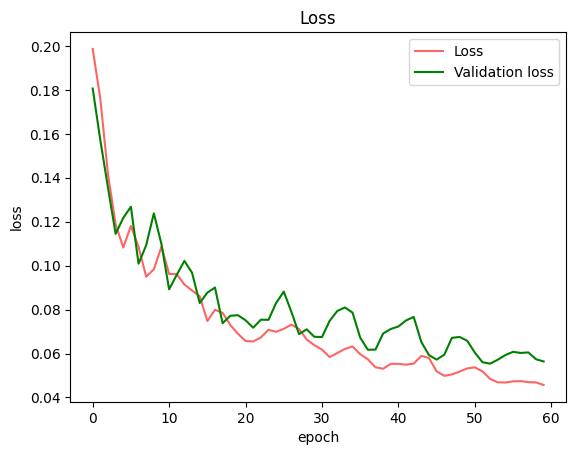

cv_time ：254.563173 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 50, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.453125, loss: 0.20338652165559157
step 2, accuracy_train:0.703125, loss: 0.13875229243669285
step 3, accuracy_train:0.74375, loss: 0.14561388906206502
step 4, accuracy_train:0.803125, loss: 0.1203446931837695
step 5, accuracy_train:0.859375, loss: 0.10119121493188724
step 6, accuracy_train:0.809375, loss: 0.08728517128405285
step 7, accuracy_train:0.796875, loss: 0.08232586341031664
step 8, accuracy_train:0.840625, loss: 0.07324476684161738
step 9, accuracy_train:0.85625, loss: 0.07199011017849377
step 10, accuracy_train:0.86875, loss: 0.06644136110881141
step 11, accuracy_train:0.875, loss: 0.059300440505281396
step 12, accuracy_train:0.903125, loss: 0.06046006976460362
step 13, accuracy_train:0.90625, loss: 0.0601956543983343
step 14, accuracy_train:0.909375, loss: 0.05762040627040858
step 15, accuracy_train:0.9125, loss: 0.05697125984902608
step 16, accuracy_train:0.906

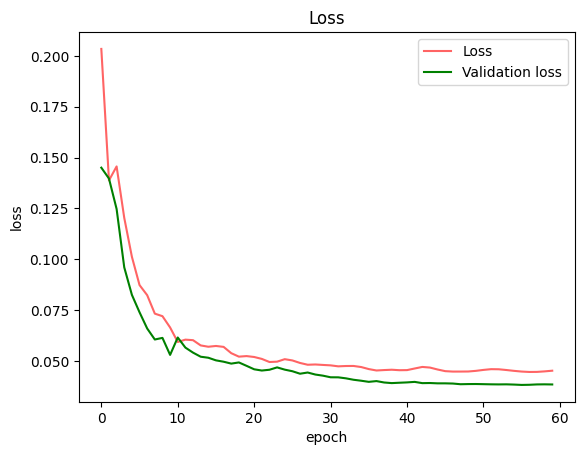

step 1, accuracy_train:0.375, loss: 0.2142833594091566
step 2, accuracy_train:0.578125, loss: 0.14999064345782165
step 3, accuracy_train:0.76875, loss: 0.13602988116251086
step 4, accuracy_train:0.775, loss: 0.1119697051047729
step 5, accuracy_train:0.840625, loss: 0.09507296694003338
step 6, accuracy_train:0.896875, loss: 0.08922798821920623
step 7, accuracy_train:0.896875, loss: 0.07950032224243793
step 8, accuracy_train:0.88125, loss: 0.07519432234083744
step 9, accuracy_train:0.9, loss: 0.07139647576793787
step 10, accuracy_train:0.91875, loss: 0.0680980008478853
step 11, accuracy_train:0.9125, loss: 0.0673029888114125
step 12, accuracy_train:0.9125, loss: 0.06335218886005234
step 13, accuracy_train:0.91875, loss: 0.060398716995191636
step 14, accuracy_train:0.925, loss: 0.05918837340435577
step 15, accuracy_train:0.91875, loss: 0.056839931617499395
step 16, accuracy_train:0.928125, loss: 0.05525149498023735
step 17, accuracy_train:0.928125, loss: 0.05310544056636296
step 18, accur

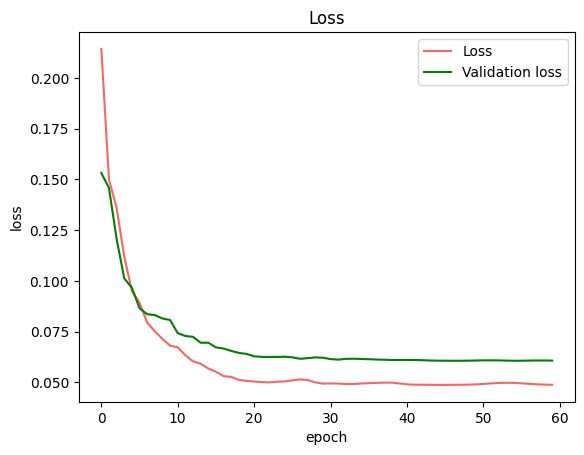

step 1, accuracy_train:0.4, loss: 0.20999559765605308
step 2, accuracy_train:0.68125, loss: 0.16020504865963814
step 3, accuracy_train:0.728125, loss: 0.16038817784416345
step 4, accuracy_train:0.890625, loss: 0.11490505261132165
step 5, accuracy_train:0.859375, loss: 0.08485128828981367
step 6, accuracy_train:0.88125, loss: 0.07413780700720932
step 7, accuracy_train:0.8875, loss: 0.06909386339492661
step 8, accuracy_train:0.90625, loss: 0.060979162134784784
step 9, accuracy_train:0.903125, loss: 0.06073288068173593
step 10, accuracy_train:0.9125, loss: 0.05464907981679776
step 11, accuracy_train:0.915625, loss: 0.05361626120313047
step 12, accuracy_train:0.925, loss: 0.05250184957641983
step 13, accuracy_train:0.921875, loss: 0.05195069564755277
step 14, accuracy_train:0.928125, loss: 0.05035204823384411
step 15, accuracy_train:0.925, loss: 0.04906824530418472
step 16, accuracy_train:0.915625, loss: 0.04925460138805464
step 17, accuracy_train:0.9125, loss: 0.049662821918792975
step 18

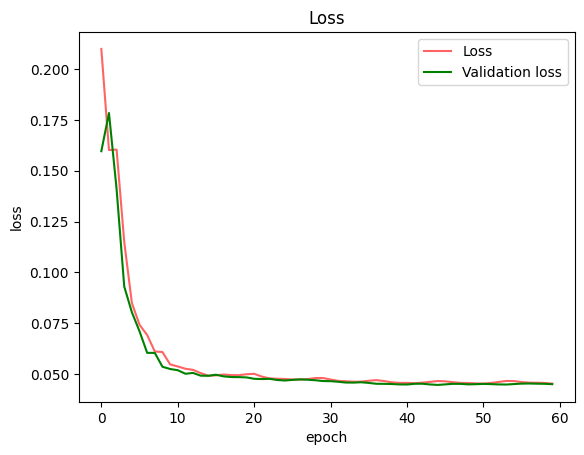

step 1, accuracy_train:0.425, loss: 0.21494817248372447
step 2, accuracy_train:0.665625, loss: 0.1413768903368483
step 3, accuracy_train:0.7625, loss: 0.1423195168714977
step 4, accuracy_train:0.76875, loss: 0.11426436686672545
step 5, accuracy_train:0.8125, loss: 0.09042759204977616
step 6, accuracy_train:0.859375, loss: 0.08197280130046097
step 7, accuracy_train:0.865625, loss: 0.07466001672255101
step 8, accuracy_train:0.859375, loss: 0.07455579301894487
step 9, accuracy_train:0.909375, loss: 0.07467988093743219
step 10, accuracy_train:0.903125, loss: 0.06704485508404869
step 11, accuracy_train:0.93125, loss: 0.06281871309066087
step 12, accuracy_train:0.9, loss: 0.06371502087487194
step 13, accuracy_train:0.928125, loss: 0.05697459218515974
step 14, accuracy_train:0.925, loss: 0.05704090167220331
step 15, accuracy_train:0.928125, loss: 0.05523763704689279
step 16, accuracy_train:0.921875, loss: 0.05507068181220912
step 17, accuracy_train:0.915625, loss: 0.05551483503489939
step 18,

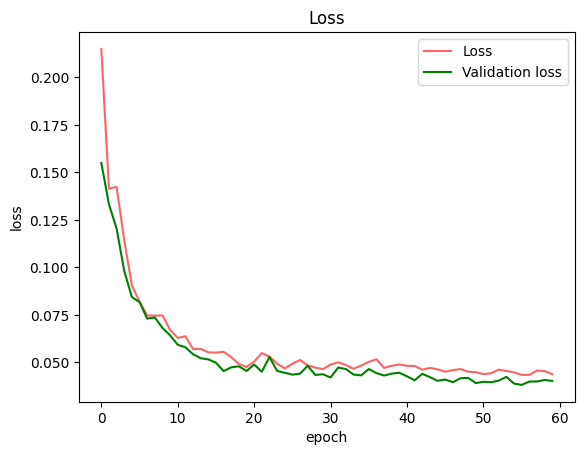

step 1, accuracy_train:0.425, loss: 0.21389286475296435
step 2, accuracy_train:0.71875, loss: 0.14367323592022346
step 3, accuracy_train:0.78125, loss: 0.14424297582171697
step 4, accuracy_train:0.784375, loss: 0.11898864114385456
step 5, accuracy_train:0.809375, loss: 0.09035557071939036
step 6, accuracy_train:0.84375, loss: 0.09298734905719791
step 7, accuracy_train:0.871875, loss: 0.0782110278647743
step 8, accuracy_train:0.825, loss: 0.0778667746365921
step 9, accuracy_train:0.846875, loss: 0.07675246177509076
step 10, accuracy_train:0.89375, loss: 0.06738202145549975
step 11, accuracy_train:0.884375, loss: 0.06906921664195347
step 12, accuracy_train:0.890625, loss: 0.06646650153437389
step 13, accuracy_train:0.878125, loss: 0.06521986986044004
step 14, accuracy_train:0.878125, loss: 0.06325670352682149
step 15, accuracy_train:0.865625, loss: 0.0631449074802044
step 16, accuracy_train:0.878125, loss: 0.05941933441900021
step 17, accuracy_train:0.88125, loss: 0.05801433902629689
ste

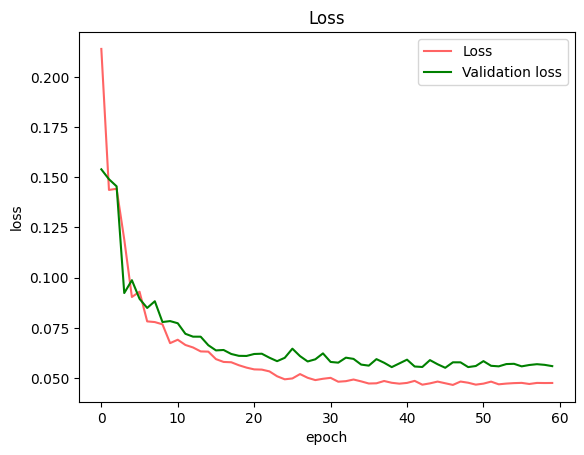

cv_time ：258.760025 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 100, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.309375, loss: 0.25763481853926956
step 2, accuracy_train:0.540625, loss: 0.16948859443907954
step 3, accuracy_train:0.3375, loss: 0.1615590304849322
step 4, accuracy_train:0.525, loss: 0.14247796307968322
step 5, accuracy_train:0.74375, loss: 0.13897861590320315
step 6, accuracy_train:0.771875, loss: 0.12743440013613544
step 7, accuracy_train:0.784375, loss: 0.11607472422531413
step 8, accuracy_train:0.81875, loss: 0.10775419933585902
step 9, accuracy_train:0.871875, loss: 0.0957797714036285
step 10, accuracy_train:0.878125, loss: 0.08537734851303709
step 11, accuracy_train:0.890625, loss: 0.07412315475978008
step 12, accuracy_train:0.890625, loss: 0.06472320868372018
step 13, accuracy_train:0.896875, loss: 0.06311184325117991
step 14, accuracy_train:0.89375, loss: 0.06052355758003389
step 15, accuracy_train:0.890625, loss: 0.05490636752027386
step 16, accuracy_train:0.90

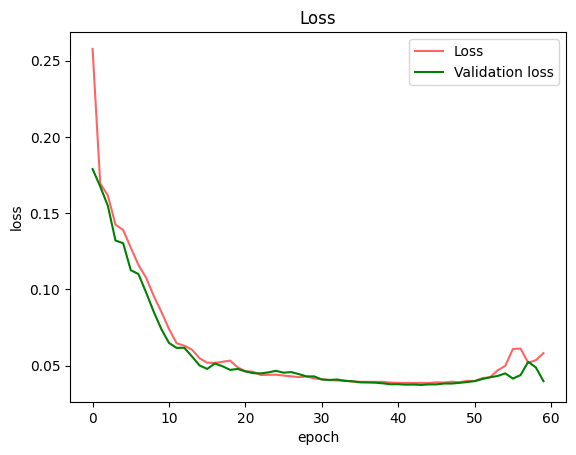

step 1, accuracy_train:0.3, loss: 0.2536738223172177
step 2, accuracy_train:0.56875, loss: 0.16813472006707642
step 3, accuracy_train:0.51875, loss: 0.14420924701659132
step 4, accuracy_train:0.628125, loss: 0.127177175501953
step 5, accuracy_train:0.728125, loss: 0.11727057306490005
step 6, accuracy_train:0.765625, loss: 0.11994904763354246
step 7, accuracy_train:0.8125, loss: 0.12156506396575852
step 8, accuracy_train:0.7875, loss: 0.1197897572037295
step 9, accuracy_train:0.80625, loss: 0.1075334410916314
step 10, accuracy_train:0.878125, loss: 0.09133708631754599
step 11, accuracy_train:0.865625, loss: 0.07732740567129587
step 12, accuracy_train:0.884375, loss: 0.06651454414090356
step 13, accuracy_train:0.86875, loss: 0.059589850243887424
step 14, accuracy_train:0.875, loss: 0.05737774945560603
step 15, accuracy_train:0.9, loss: 0.05570188978281772
step 16, accuracy_train:0.915625, loss: 0.05375272241606107
step 17, accuracy_train:0.915625, loss: 0.05288799128187019
step 18, accur

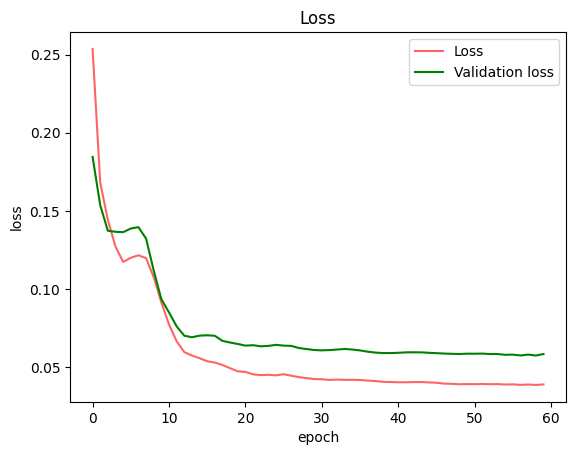

step 1, accuracy_train:0.3, loss: 0.25007201255124634
step 2, accuracy_train:0.5125, loss: 0.16949289768065956
step 3, accuracy_train:0.559375, loss: 0.14486867953282445
step 4, accuracy_train:0.725, loss: 0.11923076555181927
step 5, accuracy_train:0.73125, loss: 0.12805305778432077
step 6, accuracy_train:0.825, loss: 0.11989513784864639
step 7, accuracy_train:0.771875, loss: 0.10795102225190377
step 8, accuracy_train:0.8375, loss: 0.10016020372574272
step 9, accuracy_train:0.875, loss: 0.0827280482387405
step 10, accuracy_train:0.875, loss: 0.07978970146064462
step 11, accuracy_train:0.88125, loss: 0.07253881006649673
step 12, accuracy_train:0.896875, loss: 0.0753987430386014
step 13, accuracy_train:0.890625, loss: 0.07200967706548066
step 14, accuracy_train:0.871875, loss: 0.07358940336192826
step 15, accuracy_train:0.88125, loss: 0.0782000467362377
step 16, accuracy_train:0.890625, loss: 0.07524100791761987
step 17, accuracy_train:0.903125, loss: 0.07648502848858263
step 18, accurac

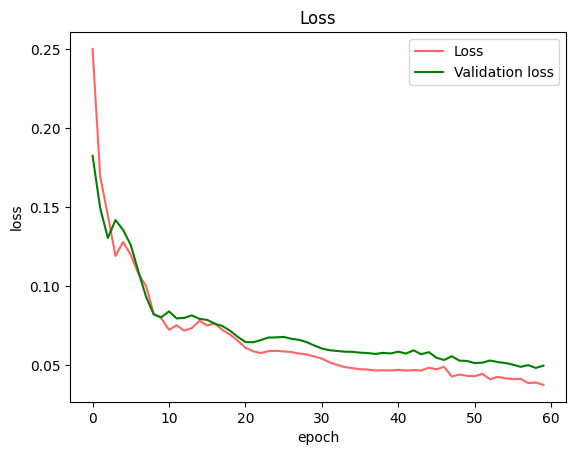

step 1, accuracy_train:0.29375, loss: 0.25238038951687286
step 2, accuracy_train:0.48125, loss: 0.17671831777303232
step 3, accuracy_train:0.3875, loss: 0.14627342845260863
step 4, accuracy_train:0.540625, loss: 0.1411999133774689
step 5, accuracy_train:0.65, loss: 0.1310924944926504
step 6, accuracy_train:0.753125, loss: 0.12578256730934345
step 7, accuracy_train:0.7875, loss: 0.11897072035785894
step 8, accuracy_train:0.875, loss: 0.10869556947495455
step 9, accuracy_train:0.840625, loss: 0.09243455693810479
step 10, accuracy_train:0.840625, loss: 0.08943927998545272
step 11, accuracy_train:0.8625, loss: 0.08505570017555564
step 12, accuracy_train:0.871875, loss: 0.08138936682383266
step 13, accuracy_train:0.8625, loss: 0.07603663509736192
step 14, accuracy_train:0.884375, loss: 0.07353757071956346
step 15, accuracy_train:0.890625, loss: 0.07065528454858949
step 16, accuracy_train:0.890625, loss: 0.0686406368519799
step 17, accuracy_train:0.9125, loss: 0.06732710467244946
step 18, ac

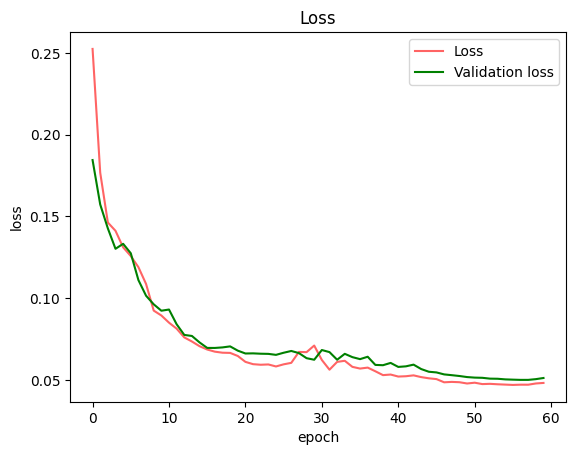

step 1, accuracy_train:0.3, loss: 0.24838036579630815
step 2, accuracy_train:0.553125, loss: 0.1712932840236836
step 3, accuracy_train:0.509375, loss: 0.14723654690229543
step 4, accuracy_train:0.59375, loss: 0.1503193742822027
step 5, accuracy_train:0.640625, loss: 0.14910504992473925
step 6, accuracy_train:0.76875, loss: 0.14331830848604718
step 7, accuracy_train:0.80625, loss: 0.1208238324680404
step 8, accuracy_train:0.83125, loss: 0.10713897847023643
step 9, accuracy_train:0.825, loss: 0.09357964686905601
step 10, accuracy_train:0.846875, loss: 0.08838246344902317
step 11, accuracy_train:0.853125, loss: 0.08300231458054305
step 12, accuracy_train:0.834375, loss: 0.07937714952885025
step 13, accuracy_train:0.871875, loss: 0.07655416419943345
step 14, accuracy_train:0.846875, loss: 0.07179930489460848
step 15, accuracy_train:0.896875, loss: 0.06608338638534353
step 16, accuracy_train:0.9125, loss: 0.05886728597748389
step 17, accuracy_train:0.9125, loss: 0.05459927882256925
step 18,

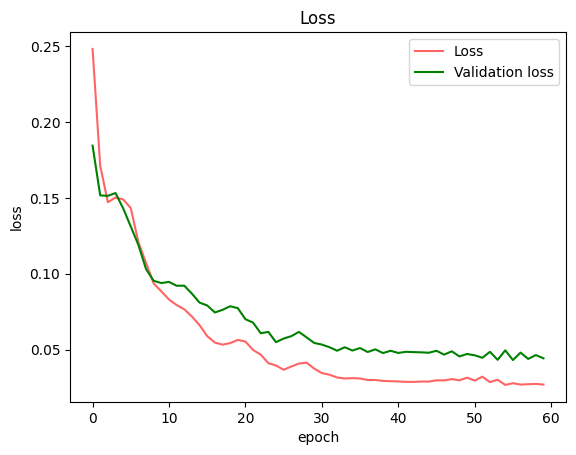

cv_time ：256.255821 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 300, 50, (0.05, 0.03, 0.01))


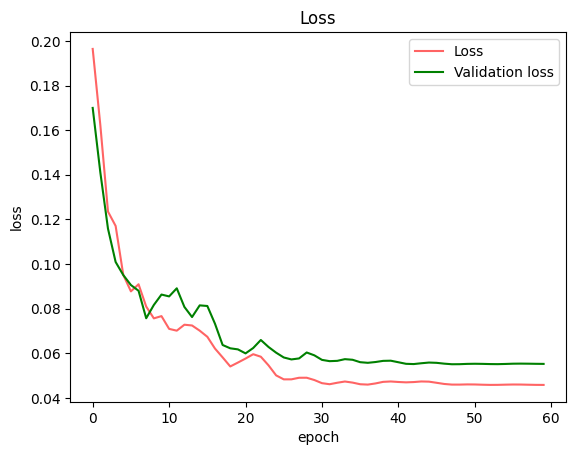

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.4625, loss: 0.24956162823528683
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 2, accuracy_train:0.59375, loss: 0.1739185817823665
step 3, accuracy_train:0.775, loss: 0.16164395257881184
step 4, accuracy_train:0.78125, loss: 0.12271244907966024
step 5, accuracy_train:0.825, loss: 0.11213622542947257
step 6, accuracy_train:0.8375, loss: 0.10464224719444956
step 7, accuracy_train:0.85, loss: 0.1133616759559013
step 8, accuracy_train:0.871875, loss: 0.09501117416902677
step 9, accuracy_train:0.884375, loss: 0.08388733261922615
step 10, accuracy_train:0.88125, loss: 0.08625138738140513
step 11, accuracy_train:0.884375, loss: 0.08291385099833863
step 12, accuracy_train:0.896875, loss: 0.07614087953692539
step 13, accuracy_train:0.903125, loss: 0.07

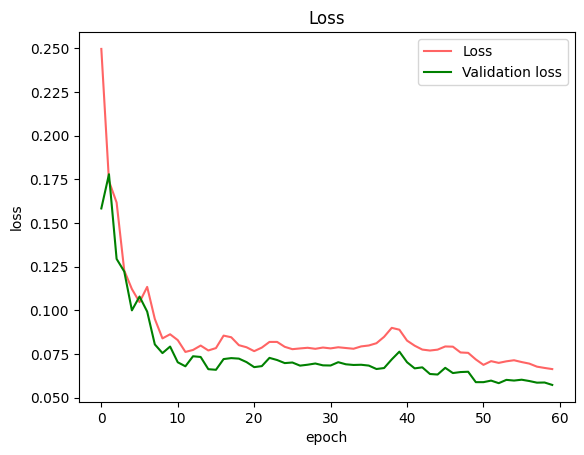

step 1, accuracy_train:0.35625, loss: 0.25109678086261106
step 2, accuracy_train:0.590625, loss: 0.19371646280012395
step 3, accuracy_train:0.59375, loss: 0.1767009910636743
step 4, accuracy_train:0.603125, loss: 0.13669015706605311
step 5, accuracy_train:0.715625, loss: 0.11875499670331482
step 6, accuracy_train:0.709375, loss: 0.12006649260157613
step 7, accuracy_train:0.771875, loss: 0.11490868170114256
step 8, accuracy_train:0.75, loss: 0.1100810760999333
step 9, accuracy_train:0.759375, loss: 0.11124409381147206
step 10, accuracy_train:0.80625, loss: 0.10202723830869648
step 11, accuracy_train:0.83125, loss: 0.097702375636278
step 12, accuracy_train:0.834375, loss: 0.08861413203511592
step 13, accuracy_train:0.815625, loss: 0.08556622954384399
step 14, accuracy_train:0.84375, loss: 0.08792841278428776
step 15, accuracy_train:0.85625, loss: 0.08785226388992952
step 16, accuracy_train:0.85, loss: 0.08701689762104753
step 17, accuracy_train:0.84375, loss: 0.08768566302216746
step 18,

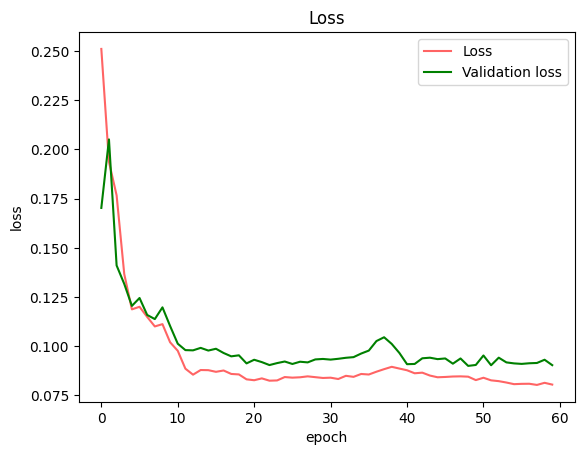

step 1, accuracy_train:0.421875, loss: 0.24709618879675385
step 2, accuracy_train:0.615625, loss: 0.19161049206382108
step 3, accuracy_train:0.6375, loss: 0.17645519248808775
step 4, accuracy_train:0.659375, loss: 0.13460133407511798
step 5, accuracy_train:0.71875, loss: 0.12336791220970623
step 6, accuracy_train:0.746875, loss: 0.11287530488464019
step 7, accuracy_train:0.76875, loss: 0.11275724355909308
step 8, accuracy_train:0.809375, loss: 0.10330052383735046
step 9, accuracy_train:0.79375, loss: 0.10054060684530315
step 10, accuracy_train:0.825, loss: 0.09884783583817894
step 11, accuracy_train:0.834375, loss: 0.09781490605062257
step 12, accuracy_train:0.828125, loss: 0.09698208167237961
step 13, accuracy_train:0.83125, loss: 0.09806278949506544
step 14, accuracy_train:0.81875, loss: 0.0948192026082631
step 15, accuracy_train:0.840625, loss: 0.0936304839351721
step 16, accuracy_train:0.8375, loss: 0.09302505732752495
step 17, accuracy_train:0.846875, loss: 0.09257029353121732
ste

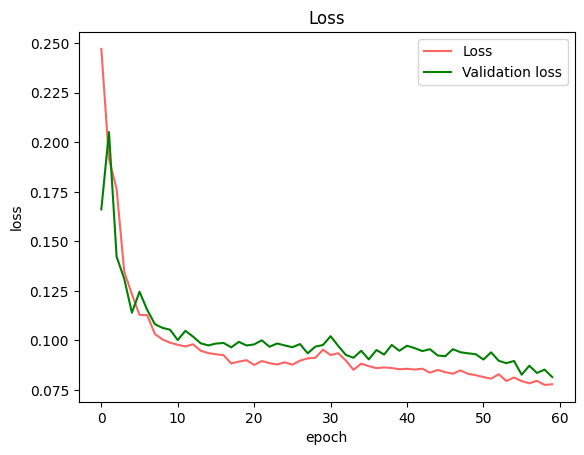

step 1, accuracy_train:0.428125, loss: 0.24843008297121744
step 2, accuracy_train:0.60625, loss: 0.18111400666855304
step 3, accuracy_train:0.728125, loss: 0.16040074528156412
step 4, accuracy_train:0.834375, loss: 0.12018106987241141
step 5, accuracy_train:0.765625, loss: 0.11843166278111911
step 6, accuracy_train:0.790625, loss: 0.11611343457692276
step 7, accuracy_train:0.815625, loss: 0.10764597256342708
step 8, accuracy_train:0.83125, loss: 0.09769001158745975
step 9, accuracy_train:0.853125, loss: 0.09319275423081258
step 10, accuracy_train:0.86875, loss: 0.09201772704925335
step 11, accuracy_train:0.896875, loss: 0.08495251900937528
step 12, accuracy_train:0.875, loss: 0.08010506745856155
step 13, accuracy_train:0.9, loss: 0.07714424607822652
step 14, accuracy_train:0.878125, loss: 0.07636392213544835
step 15, accuracy_train:0.8875, loss: 0.07298492733632239
step 16, accuracy_train:0.89375, loss: 0.07045749120586023
step 17, accuracy_train:0.884375, loss: 0.06899628914202299
ste

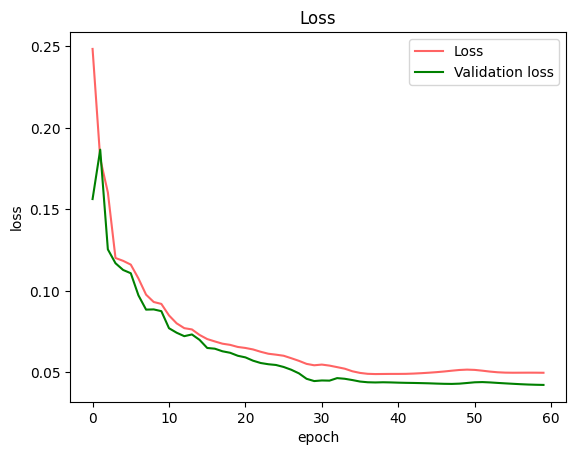

step 1, accuracy_train:0.41875, loss: 0.24960237662892062
step 2, accuracy_train:0.65625, loss: 0.18668109676798975
step 3, accuracy_train:0.703125, loss: 0.16404214903552294
step 4, accuracy_train:0.7375, loss: 0.12734807618386979
step 5, accuracy_train:0.76875, loss: 0.10971123626417745
step 6, accuracy_train:0.84375, loss: 0.11155097586815058
step 7, accuracy_train:0.8125, loss: 0.11808002011268176
step 8, accuracy_train:0.81875, loss: 0.11052221732252655
step 9, accuracy_train:0.815625, loss: 0.10732819728564431
step 10, accuracy_train:0.834375, loss: 0.10700233773836589
step 11, accuracy_train:0.846875, loss: 0.0986676408285816
step 12, accuracy_train:0.846875, loss: 0.0964178790356295
step 13, accuracy_train:0.86875, loss: 0.09339065518218607
step 14, accuracy_train:0.846875, loss: 0.09624663447527364
step 15, accuracy_train:0.85625, loss: 0.09088200136444825
step 16, accuracy_train:0.846875, loss: 0.09064456584909915
step 17, accuracy_train:0.865625, loss: 0.08919120027903167
st

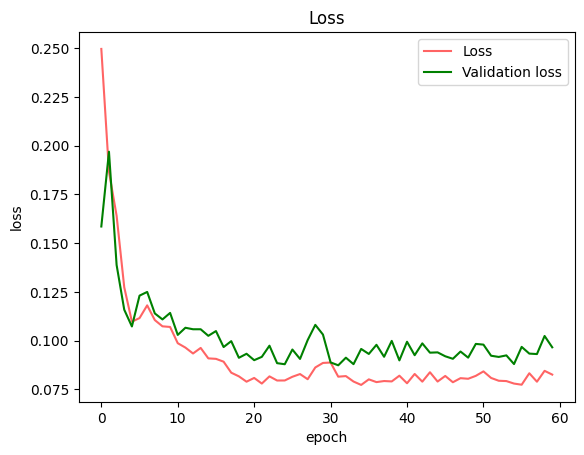

cv_time ：368.748347 s
((0.15, 0.05, 0.01), 60, 50, 50, (0.05, 0.03, 0.01))
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.428125, loss: 0.30621835168477207
step 2, accuracy_train:0.39375, loss: 0.169825831648365
step 3, accuracy_train:0.628125, loss: 0.17369332638378387
step 4, accuracy_train:0.765625, loss: 0.18085149367973022
step 5, accuracy_train:0.71875, loss: 0.15269567193503275
step 6, accuracy_train:0.778125, loss: 0.12693389433239355
step 7, accuracy_train:0.7625, loss: 0.11834641436946254
step 8, accuracy_train:0.775, loss: 0.11303899172009492
step 9, accuracy_train:0.809375, loss: 0.1057486877075108
step 10, accuracy_train:0.83125, loss: 0.10183060615245873
step 11, accuracy_train:0.846875, loss: 0.1048827222696618
step 12, accuracy_train:0.828125, loss: 0.10751309657941753
step 13, accuracy_train:0.828125, loss: 0.10429059555580963
step 14, accuracy_train:0.83125, loss: 0.10028940508631307
step 15, accuracy_t

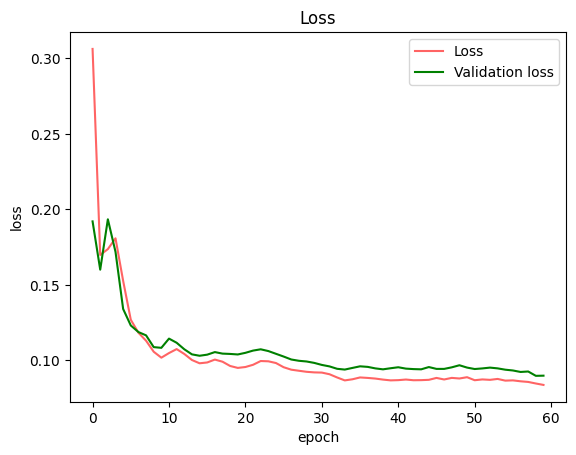

step 1, accuracy_train:0.371875, loss: 0.3072414970659191
step 2, accuracy_train:0.55625, loss: 0.1558626603851102
step 3, accuracy_train:0.6875, loss: 0.153950018634636
step 4, accuracy_train:0.734375, loss: 0.15790205079598774
step 5, accuracy_train:0.70625, loss: 0.13629142960458668
step 6, accuracy_train:0.790625, loss: 0.11692170589675328
step 7, accuracy_train:0.790625, loss: 0.10816198723692264
step 8, accuracy_train:0.778125, loss: 0.10216039192790322
step 9, accuracy_train:0.825, loss: 0.09781759794548239
step 10, accuracy_train:0.88125, loss: 0.09772045838791238
step 11, accuracy_train:0.88125, loss: 0.09605314048936688
step 12, accuracy_train:0.8875, loss: 0.08536411910193792
step 13, accuracy_train:0.875, loss: 0.07960560909024933
step 14, accuracy_train:0.871875, loss: 0.07883756817735463
step 15, accuracy_train:0.875, loss: 0.07880379794714981
step 16, accuracy_train:0.86875, loss: 0.07540669023554053
step 17, accuracy_train:0.8875, loss: 0.07374342090883607
step 18, accu

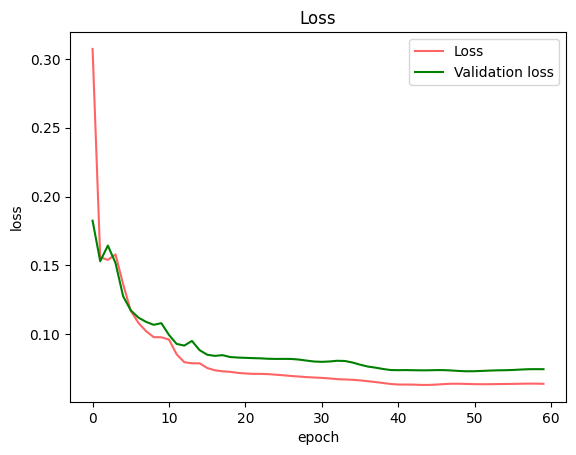

step 1, accuracy_train:0.36875, loss: 0.30689605533588293
step 2, accuracy_train:0.528125, loss: 0.15496955708398868
step 3, accuracy_train:0.665625, loss: 0.1545065437350072
step 4, accuracy_train:0.7125, loss: 0.15165520092346443
step 5, accuracy_train:0.8375, loss: 0.12600129538627394
step 6, accuracy_train:0.81875, loss: 0.11389031239125826
step 7, accuracy_train:0.86875, loss: 0.10317930444465184
step 8, accuracy_train:0.8625, loss: 0.09794327723336249
step 9, accuracy_train:0.88125, loss: 0.09792487243212408
step 10, accuracy_train:0.89375, loss: 0.09061277501464693
step 11, accuracy_train:0.89375, loss: 0.08419692382072831
step 12, accuracy_train:0.90625, loss: 0.07762830501440277
step 13, accuracy_train:0.9125, loss: 0.0725130718209574
step 14, accuracy_train:0.91875, loss: 0.0708056944155048
step 15, accuracy_train:0.890625, loss: 0.06924667483067519
step 16, accuracy_train:0.9, loss: 0.06963517647188024
step 17, accuracy_train:0.9, loss: 0.0690273878248858
step 18, accuracy_t

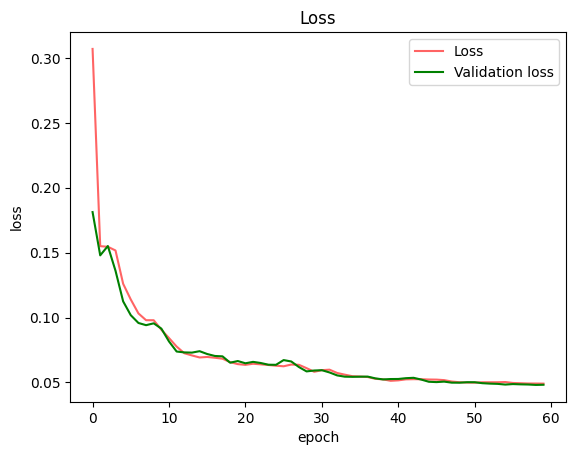

step 1, accuracy_train:0.378125, loss: 0.3060579406816031
step 2, accuracy_train:0.5125, loss: 0.1585797659550966
step 3, accuracy_train:0.64375, loss: 0.16345776450349375
step 4, accuracy_train:0.734375, loss: 0.16159639042029408
step 5, accuracy_train:0.809375, loss: 0.13073493103906464
step 6, accuracy_train:0.80625, loss: 0.11336666512155508
step 7, accuracy_train:0.828125, loss: 0.11519828446984415
step 8, accuracy_train:0.834375, loss: 0.11260592387170265
step 9, accuracy_train:0.9, loss: 0.10133017125507371
step 10, accuracy_train:0.890625, loss: 0.09965150004206234
step 11, accuracy_train:0.865625, loss: 0.09857937611790732
step 12, accuracy_train:0.859375, loss: 0.09678284520140375
step 13, accuracy_train:0.878125, loss: 0.09349756388312169
step 14, accuracy_train:0.884375, loss: 0.0922586718851686
step 15, accuracy_train:0.871875, loss: 0.09277860514589166
step 16, accuracy_train:0.88125, loss: 0.08483941615033883
step 17, accuracy_train:0.884375, loss: 0.0818978176448018
ste

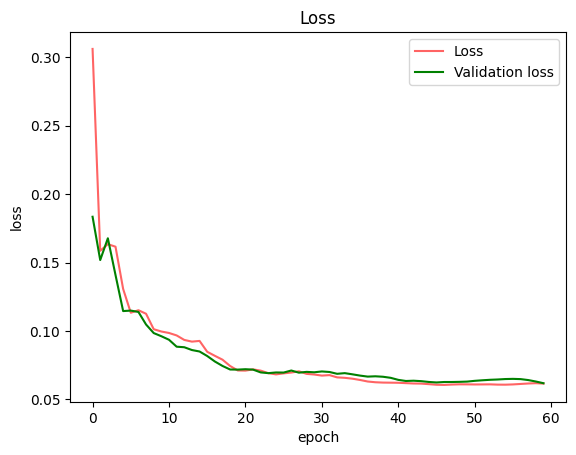

step 1, accuracy_train:0.371875, loss: 0.30487996718206467
step 2, accuracy_train:0.509375, loss: 0.16517538023020234
step 3, accuracy_train:0.596875, loss: 0.16320966338702686
step 4, accuracy_train:0.715625, loss: 0.16661377971988076
step 5, accuracy_train:0.753125, loss: 0.141202683063883
step 6, accuracy_train:0.753125, loss: 0.11646012368165537
step 7, accuracy_train:0.85625, loss: 0.09437682005436597
step 8, accuracy_train:0.8875, loss: 0.08321923693033935
step 9, accuracy_train:0.85, loss: 0.0792028981520165
step 10, accuracy_train:0.9125, loss: 0.07949805171298849
step 11, accuracy_train:0.9, loss: 0.0687288674364008
step 12, accuracy_train:0.909375, loss: 0.06865749312647937
step 13, accuracy_train:0.90625, loss: 0.06714149302970512
step 14, accuracy_train:0.90625, loss: 0.06158023092417921
step 15, accuracy_train:0.903125, loss: 0.05930999026260785
step 16, accuracy_train:0.91875, loss: 0.05855801443714752
step 17, accuracy_train:0.909375, loss: 0.05982664238650042
step 18, a

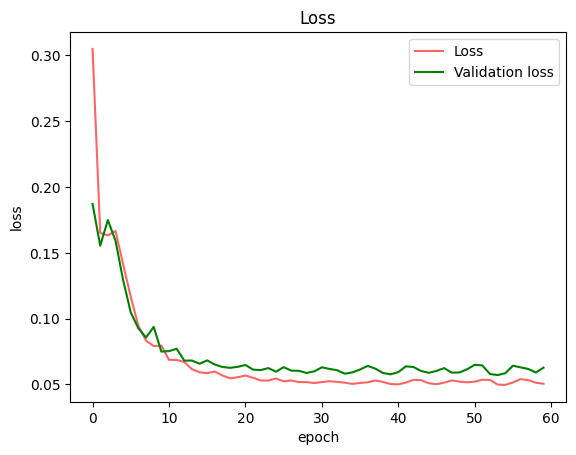

cv_time ：347.658843 s
((0.15, 0.05, 0.01), 60, 100, 50, (0.05, 0.03, 0.01))
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.3625, loss: 0.37908357590675457
step 2, accuracy_train:0.325, loss: 0.2501048009384954
step 3, accuracy_train:0.34375, loss: 0.17830803107203333
step 4, accuracy_train:0.546875, loss: 0.15649051669603925
step 5, accuracy_train:0.640625, loss: 0.14882929836788422
step 6, accuracy_train:0.675, loss: 0.1512901735977562
step 7, accuracy_train:0.69375, loss: 0.14872955154660966
step 8, accuracy_train:0.7875, loss: 0.13576443924126927
step 9, accuracy_train:0.784375, loss: 0.12294403151005107
step 10, accuracy_train:0.809375, loss: 0.11492636317466953
step 11, accuracy_train:0.790625, loss: 0.1063743790985203
step 12, accuracy_train:0.80625, loss: 0.10754832021143598
step 13, accuracy_train:0.828125, loss: 0.10471290344414358
step 14, accuracy_train:0.809375, loss: 0.10507978411184368
step 15, accuracy_tra

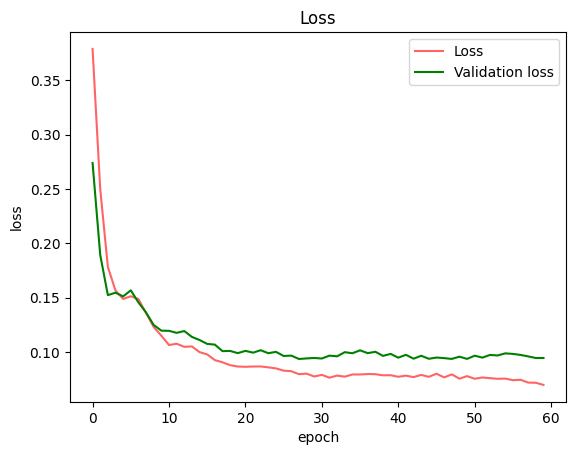

step 1, accuracy_train:0.3625, loss: 0.3794726146265658
step 2, accuracy_train:0.325, loss: 0.2452030089064416
step 3, accuracy_train:0.534375, loss: 0.18167574972387446
step 4, accuracy_train:0.45625, loss: 0.15936959143587093
step 5, accuracy_train:0.55, loss: 0.16225525528805573
step 6, accuracy_train:0.60625, loss: 0.16688229644720853
step 7, accuracy_train:0.646875, loss: 0.1629108550754937
step 8, accuracy_train:0.715625, loss: 0.14473589748674567
step 9, accuracy_train:0.74375, loss: 0.12830702173095573
step 10, accuracy_train:0.70625, loss: 0.11614341088958044
step 11, accuracy_train:0.746875, loss: 0.11021014732880655
step 12, accuracy_train:0.790625, loss: 0.10181716410403172
step 13, accuracy_train:0.759375, loss: 0.0992155064562576
step 14, accuracy_train:0.71875, loss: 0.09349446890396569
step 15, accuracy_train:0.734375, loss: 0.08741362662161281
step 16, accuracy_train:0.7375, loss: 0.08277302229811431
step 17, accuracy_train:0.765625, loss: 0.08366026841049182
step 18, 

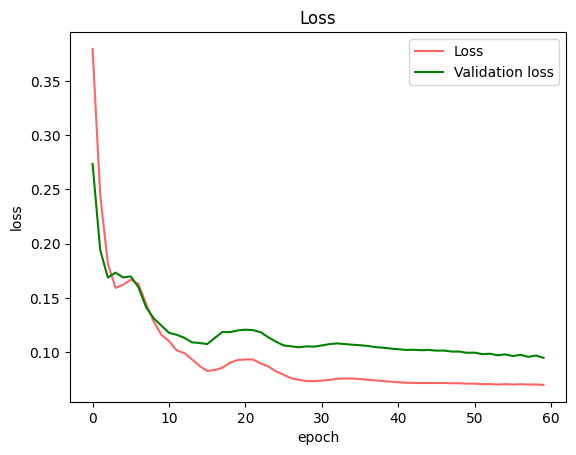

step 1, accuracy_train:0.35625, loss: 0.38419036810952334
step 2, accuracy_train:0.265625, loss: 0.2518229413589461
step 3, accuracy_train:0.521875, loss: 0.17971947816142608
step 4, accuracy_train:0.65, loss: 0.1588177144567447
step 5, accuracy_train:0.615625, loss: 0.15797156306648336
step 6, accuracy_train:0.590625, loss: 0.1636985321070855
step 7, accuracy_train:0.64375, loss: 0.16388733594862884
step 8, accuracy_train:0.821875, loss: 0.14676502386992368
step 9, accuracy_train:0.771875, loss: 0.12912134572792128
step 10, accuracy_train:0.834375, loss: 0.1224591834176368
step 11, accuracy_train:0.815625, loss: 0.1175102606742058
step 12, accuracy_train:0.778125, loss: 0.11223884692932137
step 13, accuracy_train:0.725, loss: 0.1057523232972524
step 14, accuracy_train:0.6625, loss: 0.09689327597828709
step 15, accuracy_train:0.65625, loss: 0.08981754385968502
step 16, accuracy_train:0.659375, loss: 0.08615766190910701
step 17, accuracy_train:0.709375, loss: 0.0888770187096843
step 18,

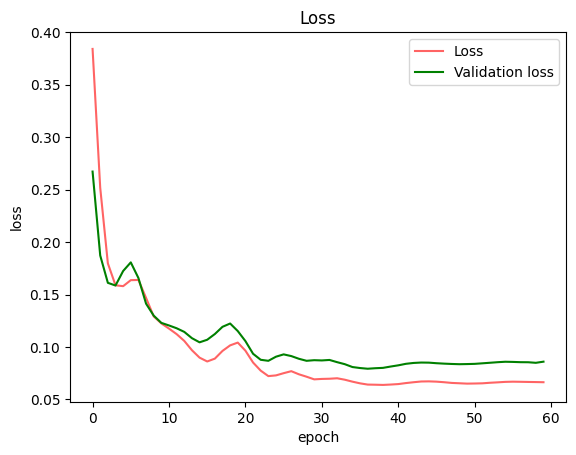

step 1, accuracy_train:0.365625, loss: 0.3791675781795105
step 2, accuracy_train:0.321875, loss: 0.2495746236941841
step 3, accuracy_train:0.371875, loss: 0.1778277630621694
step 4, accuracy_train:0.528125, loss: 0.14877286754784202
step 5, accuracy_train:0.571875, loss: 0.14736680629793317
step 6, accuracy_train:0.678125, loss: 0.146449178102164
step 7, accuracy_train:0.70625, loss: 0.14576966413643283
step 8, accuracy_train:0.715625, loss: 0.13322804078563855
step 9, accuracy_train:0.74375, loss: 0.11827033544823183
step 10, accuracy_train:0.74375, loss: 0.10439069463506294
step 11, accuracy_train:0.759375, loss: 0.09467872625724162
step 12, accuracy_train:0.740625, loss: 0.09449538267831685
step 13, accuracy_train:0.71875, loss: 0.09710005212780969
step 14, accuracy_train:0.70625, loss: 0.09875774931836584
step 15, accuracy_train:0.734375, loss: 0.09539511826201308
step 16, accuracy_train:0.75625, loss: 0.08534235395890848
step 17, accuracy_train:0.7375, loss: 0.07763309371532423
st

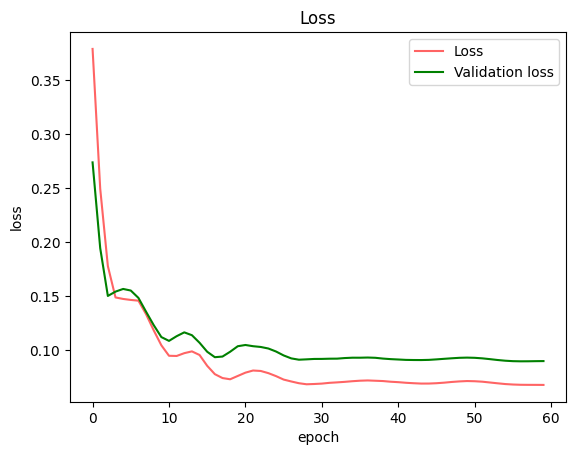

step 1, accuracy_train:0.334375, loss: 0.38301756031565476
step 2, accuracy_train:0.384375, loss: 0.2389924563902518
step 3, accuracy_train:0.5, loss: 0.1657729961438548
step 4, accuracy_train:0.525, loss: 0.14729643021245262
step 5, accuracy_train:0.5875, loss: 0.15337061171359473
step 6, accuracy_train:0.703125, loss: 0.16245799770250202
step 7, accuracy_train:0.796875, loss: 0.1626610985170801
step 8, accuracy_train:0.790625, loss: 0.1527084475409452
step 9, accuracy_train:0.8125, loss: 0.13410557649623953
step 10, accuracy_train:0.840625, loss: 0.11628159019935841
step 11, accuracy_train:0.8375, loss: 0.10048149592385525
step 12, accuracy_train:0.81875, loss: 0.09453326908661153
step 13, accuracy_train:0.884375, loss: 0.09139025442814805
step 14, accuracy_train:0.875, loss: 0.08343948910848452
step 15, accuracy_train:0.8875, loss: 0.07591616062453672
step 16, accuracy_train:0.89375, loss: 0.07806391460982787
step 17, accuracy_train:0.896875, loss: 0.07628336620829707
step 18, accur

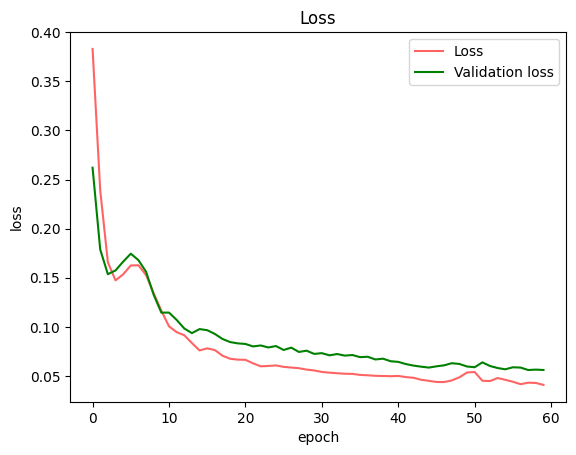

cv_time ：352.655507 s
((0.15, 0.05, 0.01), 60, 300, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.4625, loss: 0.24956162823528683
step 2, accuracy_train:0.59375, loss: 0.1739185817823665
step 3, accuracy_train:0.775, loss: 0.16164395257881184
step 4, accuracy_train:0.78125, loss: 0.12271244907966024
step 5, accuracy_train:0.825, loss: 0.11213622542947257
step 6, accuracy_train:0.8375, loss: 0.10464224719444956
step 7, accuracy_train:0.85, loss: 0.1133616759559013
step 8, accuracy_train:0.871875, loss: 0.09501117416902677
step 9, accuracy_train:0.884375, loss: 0.08388733261922615
step 10, accuracy_train:0.88125, loss: 0.08625138738140513
step 11, accuracy_train:0.884375, loss: 0.08291385099833863
step 12, accuracy_train:0.896875, loss: 0.07614087953692539
step 13, accuracy_train:0.903125, loss: 0.07727606067609138
step 14, accuracy_train:0.9, loss: 0.07979028845854824
step 15, accuracy_train:0.903125, loss: 0.07698414986902834
step 16, accuracy_train:0.896875, loss: 0.078342317572583

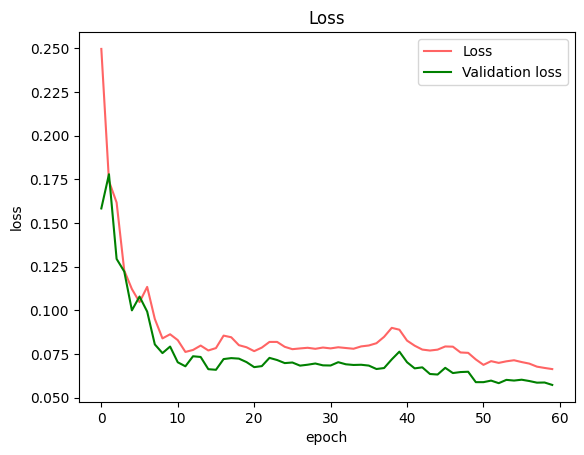

step 1, accuracy_train:0.35625, loss: 0.25109678086261106
step 2, accuracy_train:0.590625, loss: 0.19371646280012395
step 3, accuracy_train:0.59375, loss: 0.1767009910636743
step 4, accuracy_train:0.603125, loss: 0.13669015706605311
step 5, accuracy_train:0.715625, loss: 0.11875499670331482
step 6, accuracy_train:0.709375, loss: 0.12006649260157613
step 7, accuracy_train:0.771875, loss: 0.11490868170114256
step 8, accuracy_train:0.75, loss: 0.1100810760999333
step 9, accuracy_train:0.759375, loss: 0.11124409381147206
step 10, accuracy_train:0.80625, loss: 0.10202723830869648
step 11, accuracy_train:0.83125, loss: 0.097702375636278
step 12, accuracy_train:0.834375, loss: 0.08861413203511592
step 13, accuracy_train:0.815625, loss: 0.08556622954384399
step 14, accuracy_train:0.84375, loss: 0.08792841278428776
step 15, accuracy_train:0.85625, loss: 0.08785226388992952
step 16, accuracy_train:0.85, loss: 0.08701689762104753
step 17, accuracy_train:0.84375, loss: 0.08768566302216746
step 18,

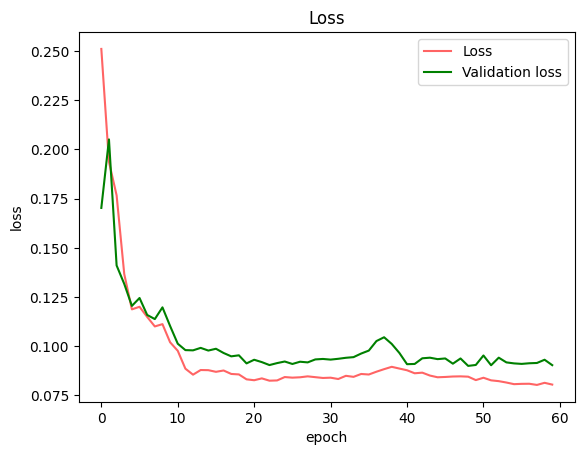

step 1, accuracy_train:0.421875, loss: 0.24709618879675385
step 2, accuracy_train:0.615625, loss: 0.19161049206382108
step 3, accuracy_train:0.6375, loss: 0.17645519248808775
step 4, accuracy_train:0.659375, loss: 0.13460133407511798
step 5, accuracy_train:0.71875, loss: 0.12336791220970623
step 6, accuracy_train:0.746875, loss: 0.11287530488464019
step 7, accuracy_train:0.76875, loss: 0.11275724355909308
step 8, accuracy_train:0.809375, loss: 0.10330052383735046
step 9, accuracy_train:0.79375, loss: 0.10054060684530315
step 10, accuracy_train:0.825, loss: 0.09884783583817894
step 11, accuracy_train:0.834375, loss: 0.09781490605062257
step 12, accuracy_train:0.828125, loss: 0.09698208167237961
step 13, accuracy_train:0.83125, loss: 0.09806278949506544
step 14, accuracy_train:0.81875, loss: 0.0948192026082631
step 15, accuracy_train:0.840625, loss: 0.0936304839351721
step 16, accuracy_train:0.8375, loss: 0.09302505732752495
step 17, accuracy_train:0.846875, loss: 0.09257029353121732
ste

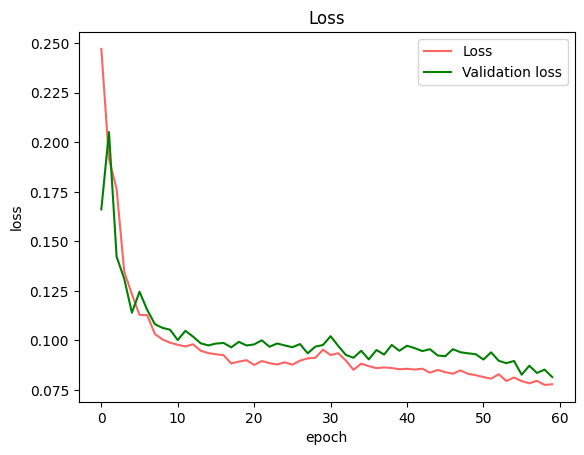

step 1, accuracy_train:0.428125, loss: 0.24843008297121744
step 2, accuracy_train:0.60625, loss: 0.18111400666855304
step 3, accuracy_train:0.728125, loss: 0.16040074528156412
step 4, accuracy_train:0.834375, loss: 0.12018106987241141
step 5, accuracy_train:0.765625, loss: 0.11843166278111911
step 6, accuracy_train:0.790625, loss: 0.11611343457692276
step 7, accuracy_train:0.815625, loss: 0.10764597256342708
step 8, accuracy_train:0.83125, loss: 0.09769001158745975
step 9, accuracy_train:0.853125, loss: 0.09319275423081258
step 10, accuracy_train:0.86875, loss: 0.09201772704925335
step 11, accuracy_train:0.896875, loss: 0.08495251900937528
step 12, accuracy_train:0.875, loss: 0.08010506745856155
step 13, accuracy_train:0.9, loss: 0.07714424607822652
step 14, accuracy_train:0.878125, loss: 0.07636392213544835
step 15, accuracy_train:0.8875, loss: 0.07298492733632239
step 16, accuracy_train:0.89375, loss: 0.07045749120586023
step 17, accuracy_train:0.884375, loss: 0.06899628914202299
ste

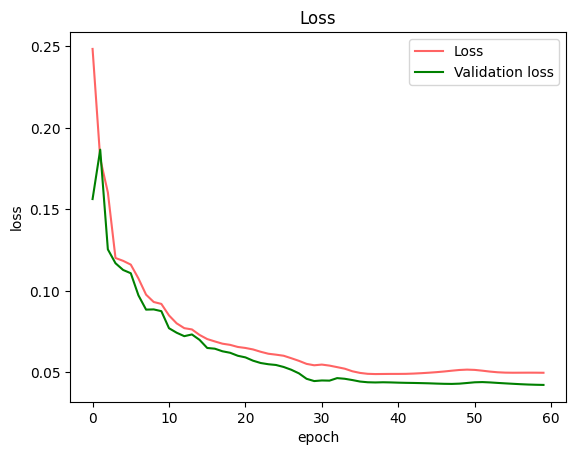

step 1, accuracy_train:0.41875, loss: 0.24960237662892062
step 2, accuracy_train:0.65625, loss: 0.18668109676798975
step 3, accuracy_train:0.703125, loss: 0.16404214903552294
step 4, accuracy_train:0.7375, loss: 0.12734807618386979
step 5, accuracy_train:0.76875, loss: 0.10971123626417745
step 6, accuracy_train:0.84375, loss: 0.11155097586815058
step 7, accuracy_train:0.8125, loss: 0.11808002011268176
step 8, accuracy_train:0.81875, loss: 0.11052221732252655
step 9, accuracy_train:0.815625, loss: 0.10732819728564431
step 10, accuracy_train:0.834375, loss: 0.10700233773836589
step 11, accuracy_train:0.846875, loss: 0.0986676408285816
step 12, accuracy_train:0.846875, loss: 0.0964178790356295
step 13, accuracy_train:0.86875, loss: 0.09339065518218607
step 14, accuracy_train:0.846875, loss: 0.09624663447527364
step 15, accuracy_train:0.85625, loss: 0.09088200136444825
step 16, accuracy_train:0.846875, loss: 0.09064456584909915
step 17, accuracy_train:0.865625, loss: 0.08919120027903167
st

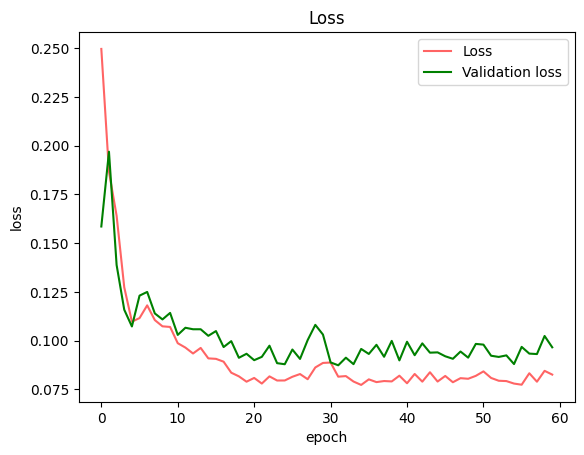

cv_time ：343.770542 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 50, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.428125, loss: 0.30621835168477207
step 2, accuracy_train:0.39375, loss: 0.169825831648365
step 3, accuracy_train:0.628125, loss: 0.17369332638378387
step 4, accuracy_train:0.765625, loss: 0.18085149367973022
step 5, accuracy_train:0.71875, loss: 0.15269567193503275
step 6, accuracy_train:0.778125, loss: 0.12693389433239355
step 7, accuracy_train:0.7625, loss: 0.11834641436946254
step 8, accuracy_train:0.775, loss: 0.11303899172009492
step 9, accuracy_train:0.809375, loss: 0.1057486877075108
step 10, accuracy_train:0.83125, loss: 0.10183060615245873
step 11, accuracy_train:0.846875, loss: 0.1048827222696618
step 12, accuracy_train:0.828125, loss: 0.10751309657941753
step 13, accuracy_train:0.828125, loss: 0.10429059555580963
step 14, accuracy_train:0.83125, loss: 0.10028940508631307
step 15, accuracy_train:0.821875, loss: 0.09811429299644915
step 16, accuracy_train:0.825, l

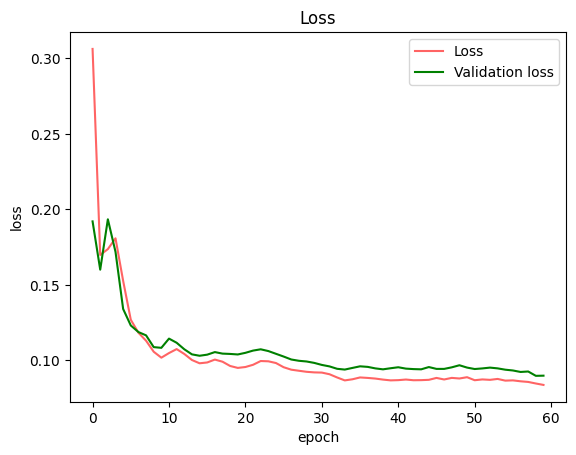

step 1, accuracy_train:0.371875, loss: 0.3072414970659191
step 2, accuracy_train:0.55625, loss: 0.1558626603851102
step 3, accuracy_train:0.6875, loss: 0.153950018634636
step 4, accuracy_train:0.734375, loss: 0.15790205079598774
step 5, accuracy_train:0.70625, loss: 0.13629142960458668
step 6, accuracy_train:0.790625, loss: 0.11692170589675328
step 7, accuracy_train:0.790625, loss: 0.10816198723692264
step 8, accuracy_train:0.778125, loss: 0.10216039192790322
step 9, accuracy_train:0.825, loss: 0.09781759794548239
step 10, accuracy_train:0.88125, loss: 0.09772045838791238
step 11, accuracy_train:0.88125, loss: 0.09605314048936688
step 12, accuracy_train:0.8875, loss: 0.08536411910193792
step 13, accuracy_train:0.875, loss: 0.07960560909024933
step 14, accuracy_train:0.871875, loss: 0.07883756817735463
step 15, accuracy_train:0.875, loss: 0.07880379794714981
step 16, accuracy_train:0.86875, loss: 0.07540669023554053
step 17, accuracy_train:0.8875, loss: 0.07374342090883607
step 18, accu

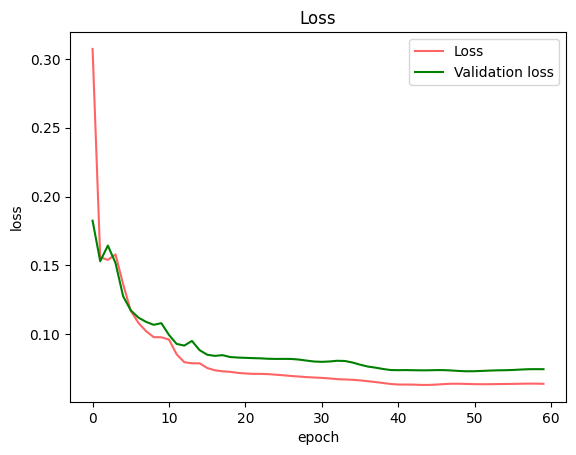

step 1, accuracy_train:0.36875, loss: 0.30689605533588293
step 2, accuracy_train:0.528125, loss: 0.15496955708398868
step 3, accuracy_train:0.665625, loss: 0.1545065437350072
step 4, accuracy_train:0.7125, loss: 0.15165520092346443
step 5, accuracy_train:0.8375, loss: 0.12600129538627394
step 6, accuracy_train:0.81875, loss: 0.11389031239125826
step 7, accuracy_train:0.86875, loss: 0.10317930444465184
step 8, accuracy_train:0.8625, loss: 0.09794327723336249
step 9, accuracy_train:0.88125, loss: 0.09792487243212408
step 10, accuracy_train:0.89375, loss: 0.09061277501464693
step 11, accuracy_train:0.89375, loss: 0.08419692382072831
step 12, accuracy_train:0.90625, loss: 0.07762830501440277
step 13, accuracy_train:0.9125, loss: 0.0725130718209574
step 14, accuracy_train:0.91875, loss: 0.0708056944155048
step 15, accuracy_train:0.890625, loss: 0.06924667483067519
step 16, accuracy_train:0.9, loss: 0.06963517647188024
step 17, accuracy_train:0.9, loss: 0.0690273878248858
step 18, accuracy_t

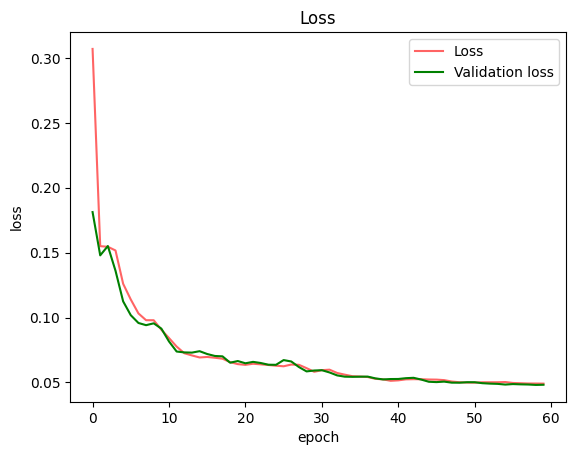

step 1, accuracy_train:0.378125, loss: 0.3060579406816031
step 2, accuracy_train:0.5125, loss: 0.1585797659550966
step 3, accuracy_train:0.64375, loss: 0.16345776450349375
step 4, accuracy_train:0.734375, loss: 0.16159639042029408
step 5, accuracy_train:0.809375, loss: 0.13073493103906464
step 6, accuracy_train:0.80625, loss: 0.11336666512155508
step 7, accuracy_train:0.828125, loss: 0.11519828446984415
step 8, accuracy_train:0.834375, loss: 0.11260592387170265
step 9, accuracy_train:0.9, loss: 0.10133017125507371
step 10, accuracy_train:0.890625, loss: 0.09965150004206234
step 11, accuracy_train:0.865625, loss: 0.09857937611790732
step 12, accuracy_train:0.859375, loss: 0.09678284520140375
step 13, accuracy_train:0.878125, loss: 0.09349756388312169
step 14, accuracy_train:0.884375, loss: 0.0922586718851686
step 15, accuracy_train:0.871875, loss: 0.09277860514589166
step 16, accuracy_train:0.88125, loss: 0.08483941615033883
step 17, accuracy_train:0.884375, loss: 0.0818978176448018
ste

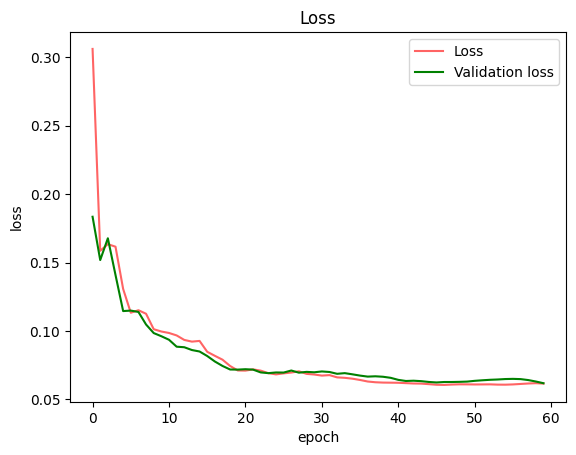

step 1, accuracy_train:0.371875, loss: 0.30487996718206467
step 2, accuracy_train:0.509375, loss: 0.16517538023020234
step 3, accuracy_train:0.596875, loss: 0.16320966338702686
step 4, accuracy_train:0.715625, loss: 0.16661377971988076
step 5, accuracy_train:0.753125, loss: 0.141202683063883
step 6, accuracy_train:0.753125, loss: 0.11646012368165537
step 7, accuracy_train:0.85625, loss: 0.09437682005436597
step 8, accuracy_train:0.8875, loss: 0.08321923693033935
step 9, accuracy_train:0.85, loss: 0.0792028981520165
step 10, accuracy_train:0.9125, loss: 0.07949805171298849
step 11, accuracy_train:0.9, loss: 0.0687288674364008
step 12, accuracy_train:0.909375, loss: 0.06865749312647937
step 13, accuracy_train:0.90625, loss: 0.06714149302970512
step 14, accuracy_train:0.90625, loss: 0.06158023092417921
step 15, accuracy_train:0.903125, loss: 0.05930999026260785
step 16, accuracy_train:0.91875, loss: 0.05855801443714752
step 17, accuracy_train:0.909375, loss: 0.05982664238650042
step 18, a

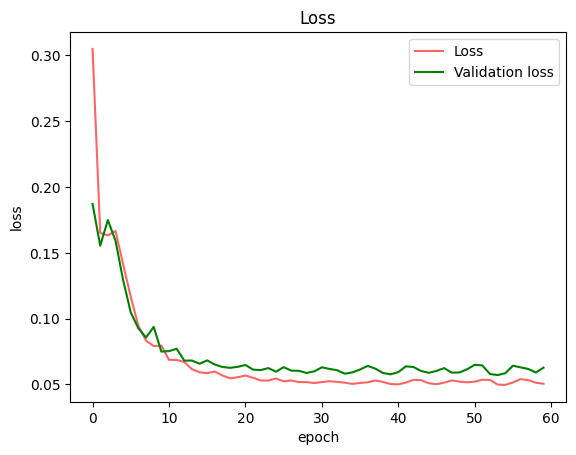

cv_time ：350.073126 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 100, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.3625, loss: 0.37908357590675457
step 2, accuracy_train:0.325, loss: 0.2501048009384954
step 3, accuracy_train:0.34375, loss: 0.17830803107203333
step 4, accuracy_train:0.546875, loss: 0.15649051669603925
step 5, accuracy_train:0.640625, loss: 0.14882929836788422
step 6, accuracy_train:0.675, loss: 0.1512901735977562
step 7, accuracy_train:0.69375, loss: 0.14872955154660966
step 8, accuracy_train:0.7875, loss: 0.13576443924126927
step 9, accuracy_train:0.784375, loss: 0.12294403151005107
step 10, accuracy_train:0.809375, loss: 0.11492636317466953
step 11, accuracy_train:0.790625, loss: 0.1063743790985203
step 12, accuracy_train:0.80625, loss: 0.10754832021143598
step 13, accuracy_train:0.828125, loss: 0.10471290344414358
step 14, accuracy_train:0.809375, loss: 0.10507978411184368
step 15, accuracy_train:0.803125, loss: 0.09979788786090975
step 16, accuracy_train:0.803125, 

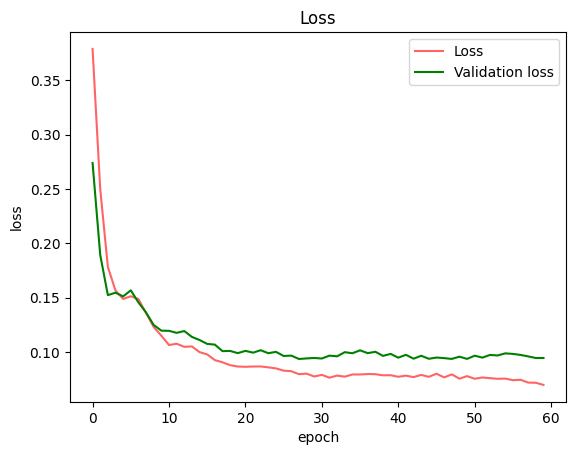

step 1, accuracy_train:0.3625, loss: 0.3794726146265658
step 2, accuracy_train:0.325, loss: 0.2452030089064416
step 3, accuracy_train:0.534375, loss: 0.18167574972387446
step 4, accuracy_train:0.45625, loss: 0.15936959143587093
step 5, accuracy_train:0.55, loss: 0.16225525528805573
step 6, accuracy_train:0.60625, loss: 0.16688229644720853
step 7, accuracy_train:0.646875, loss: 0.1629108550754937
step 8, accuracy_train:0.715625, loss: 0.14473589748674567
step 9, accuracy_train:0.74375, loss: 0.12830702173095573
step 10, accuracy_train:0.70625, loss: 0.11614341088958044
step 11, accuracy_train:0.746875, loss: 0.11021014732880655
step 12, accuracy_train:0.790625, loss: 0.10181716410403172
step 13, accuracy_train:0.759375, loss: 0.0992155064562576
step 14, accuracy_train:0.71875, loss: 0.09349446890396569
step 15, accuracy_train:0.734375, loss: 0.08741362662161281
step 16, accuracy_train:0.7375, loss: 0.08277302229811431
step 17, accuracy_train:0.765625, loss: 0.08366026841049182
step 18, 

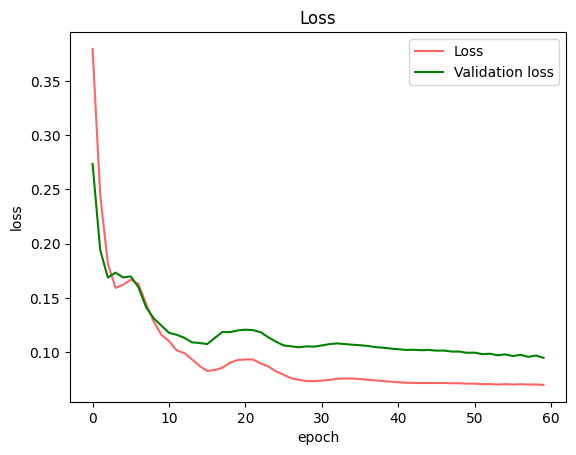

step 1, accuracy_train:0.35625, loss: 0.38419036810952334
step 2, accuracy_train:0.265625, loss: 0.2518229413589461
step 3, accuracy_train:0.521875, loss: 0.17971947816142608
step 4, accuracy_train:0.65, loss: 0.1588177144567447
step 5, accuracy_train:0.615625, loss: 0.15797156306648336
step 6, accuracy_train:0.590625, loss: 0.1636985321070855
step 7, accuracy_train:0.64375, loss: 0.16388733594862884
step 8, accuracy_train:0.821875, loss: 0.14676502386992368
step 9, accuracy_train:0.771875, loss: 0.12912134572792128
step 10, accuracy_train:0.834375, loss: 0.1224591834176368
step 11, accuracy_train:0.815625, loss: 0.1175102606742058
step 12, accuracy_train:0.778125, loss: 0.11223884692932137
step 13, accuracy_train:0.725, loss: 0.1057523232972524
step 14, accuracy_train:0.6625, loss: 0.09689327597828709
step 15, accuracy_train:0.65625, loss: 0.08981754385968502
step 16, accuracy_train:0.659375, loss: 0.08615766190910701
step 17, accuracy_train:0.709375, loss: 0.0888770187096843
step 18,

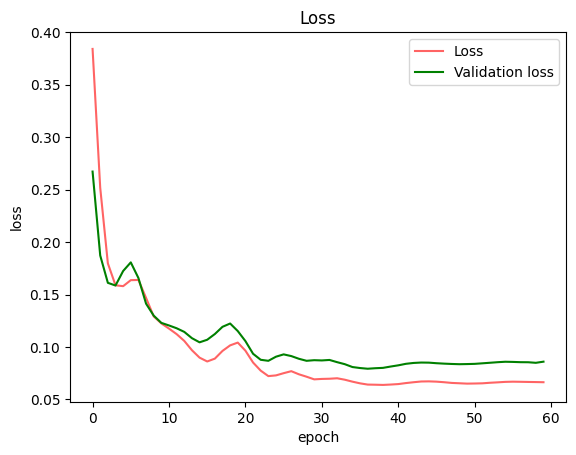

step 1, accuracy_train:0.365625, loss: 0.3791675781795105
step 2, accuracy_train:0.321875, loss: 0.2495746236941841
step 3, accuracy_train:0.371875, loss: 0.1778277630621694
step 4, accuracy_train:0.528125, loss: 0.14877286754784202
step 5, accuracy_train:0.571875, loss: 0.14736680629793317
step 6, accuracy_train:0.678125, loss: 0.146449178102164
step 7, accuracy_train:0.70625, loss: 0.14576966413643283
step 8, accuracy_train:0.715625, loss: 0.13322804078563855
step 9, accuracy_train:0.74375, loss: 0.11827033544823183
step 10, accuracy_train:0.74375, loss: 0.10439069463506294
step 11, accuracy_train:0.759375, loss: 0.09467872625724162
step 12, accuracy_train:0.740625, loss: 0.09449538267831685
step 13, accuracy_train:0.71875, loss: 0.09710005212780969
step 14, accuracy_train:0.70625, loss: 0.09875774931836584
step 15, accuracy_train:0.734375, loss: 0.09539511826201308
step 16, accuracy_train:0.75625, loss: 0.08534235395890848
step 17, accuracy_train:0.7375, loss: 0.07763309371532423
st

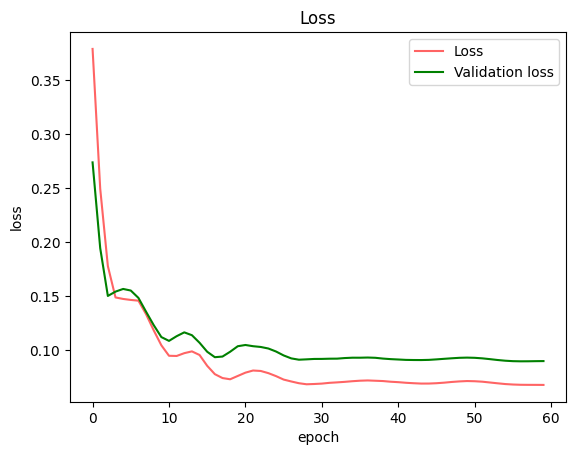

step 1, accuracy_train:0.334375, loss: 0.38301756031565476
step 2, accuracy_train:0.384375, loss: 0.2389924563902518
step 3, accuracy_train:0.5, loss: 0.1657729961438548
step 4, accuracy_train:0.525, loss: 0.14729643021245262
step 5, accuracy_train:0.5875, loss: 0.15337061171359473
step 6, accuracy_train:0.703125, loss: 0.16245799770250202
step 7, accuracy_train:0.796875, loss: 0.1626610985170801
step 8, accuracy_train:0.790625, loss: 0.1527084475409452
step 9, accuracy_train:0.8125, loss: 0.13410557649623953
step 10, accuracy_train:0.840625, loss: 0.11628159019935841
step 11, accuracy_train:0.8375, loss: 0.10048149592385525
step 12, accuracy_train:0.81875, loss: 0.09453326908661153
step 13, accuracy_train:0.884375, loss: 0.09139025442814805
step 14, accuracy_train:0.875, loss: 0.08343948910848452
step 15, accuracy_train:0.8875, loss: 0.07591616062453672
step 16, accuracy_train:0.89375, loss: 0.07806391460982787
step 17, accuracy_train:0.896875, loss: 0.07628336620829707
step 18, accur

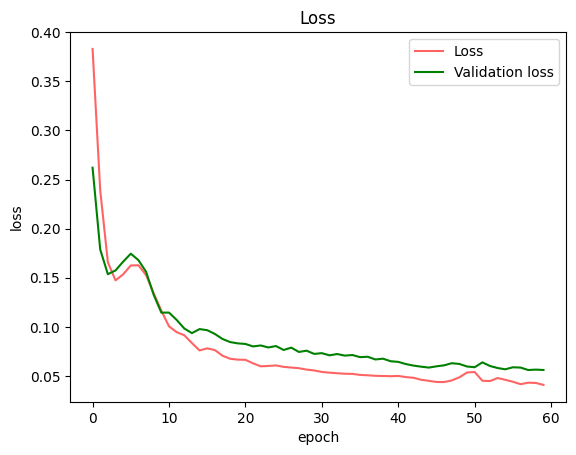

cv_time ：352.713385 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 300, 50, (0.05, 0.03, 0.01))


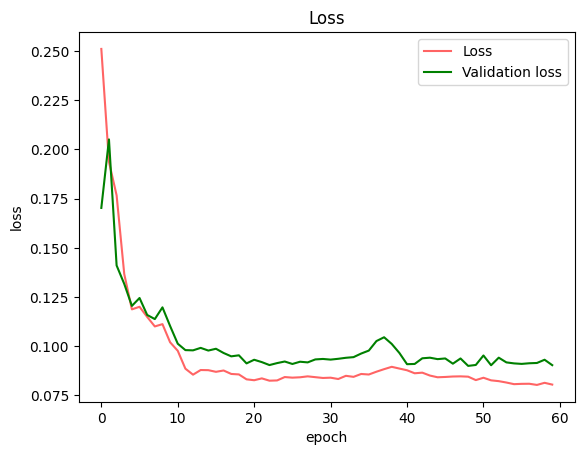

In [16]:
# Grid search of hyper-parameters
best_h_pm, h_pm_rsts =[], []
cv_start = time.process_time()
configs['noise'] = training_noise
for setting in settings:
    enc_dim,num_qubits,num_layers,num_reupload,num_rot = setting
    X_train, y_train, X_test, y_test = initialize_data(problem,num_training,num_test,seed_num,enc_dim,**configs)
    
    h_pm_rst=[]
    loss_history_cvs=[]
    configs['qc'] = qcircuit(*setting, **configs)
    
    for h_pm in h_pms:
        learning_rate,max_epoch,batch_size,dynamic_size,threshold = h_pm
        configs['_h_pm'] = tuple(h_pm)
        
        seed_rsts, seed_params = [], []
        loss_history, valid_loss_history = [], []
        accuracy_history = []
        h_pm_rst.append(n_cv(num_cvs, X_train, y_train,setting, **configs))
        print(h_pm)

        
    h_pm_i = np.argmax(h_pm_rst,axis=0)[0]
    best_h_pm.append(h_pm_i)
    h_pm_rsts.append(h_pm_rst)
    l_h_best, val_l_h_best = loss_history_cvs[h_pm_i]
    plot_loss_history(l_h_best, val_l_h_best, setting=setting, fig_name=f'{setting}_loss_best_h_pms')
t_cvs = time.process_time()-cv_start

In [17]:
def run(seed_num, x_tr, y_tr, *args, x_te=None, y_te=None, ratio_tr=0.875, **kwargs):
    #if:   x_te=None & y_te=None -> choosing random seed with validation accuracy
    #else: train and test
    global loss_history, valid_loss_history, lr    
    # print('run args', args)
    # configs['qc'] = qcircuit(*args, **configs)
    
    if x_te is None and y_te is None:
        from sklearn.utils import shuffle
        from sklearn.model_selection import train_test_split
        xs_tr, xs_val, ys_tr, ys_val = train_test_split(
            x_tr,y_tr,train_size=ratio_tr,random_state=seed_num,stratify=y_tr)
        # xs = shuffle(x_tr, random_state=seed_num, n_samples=None)
        # ys = shuffle(y_tr, random_state=seed_num, n_samples=None)
        # num_seed_train = int(num_training*ratio_tr)
        # num_seed_valid = num_training-num_seed_train
        # xs_tr = xs[:num_seed_train] 
        # ys_tr = ys[:num_seed_train]
        # xs_val = xs[num_seed_train:] 
        # ys_val = ys[num_seed_train:] 
    else:
        xs_tr, ys_tr, xs_val, ys_val = x_tr, y_tr, x_te, y_te

    params = initialize_params(enc_dim, num_qubits, num_layers, num_reupload, num_rot, num_class, seed_num)
    optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=lr)
    opt_state = optimizer.init(params)
    if x_te is None and y_te is None: # optimized by validation data but not peeking in true test data
        params, lr, opt_state, num_epoch = fit(params, optimizer, opt_state, xs_tr, ys_tr,x_valid=xs_val,y_valid=ys_val, *args, **kwargs)  
    else: 
        params, lr, opt_state, num_epoch = fit(params, optimizer, opt_state, xs_tr, ys_tr, *args, **configs)
    accuracy_train, loss, accuracy_valid, loss_test = scores(params, xs_tr, ys_tr, x_te=xs_val, y_te=ys_val, *args, **kwargs)
    plot_loss_history(loss_history, valid_loss_history, setting=args, fig_name=None)
    
    if x_te is None and y_te is None:
        print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Validation Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_valid))
    else:
        print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_valid))
    print(f"(n_dim, n_q, n_f, n_r, n_rot) = {enc_dim, num_qubits, num_layers, num_reupload, num_rot}")
    
    return params, [seed_num, accuracy_train, accuracy_valid, loss, num_epoch]

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.20857142857142857, loss: 0.2627562128634373
step 2, accuracy_train:0.2857142857142857, loss: 0.2506048751119568
step 3, accuracy_train:0.5085714285714286, loss: 0.21254848561363632
step 4, accuracy_train:0.6, loss: 0.1591669827270023
step 5, accuracy_train:0.49142857142857144, loss: 0.1702406924326638
step 6, accuracy_train:0.5285714285714286, loss: 0.14782442423997244
step 7, accuracy_train:0.5542857142857143, loss: 0.15283851666000453
step 8, accuracy_train:0.5942857142857143, loss: 0.12599929728018905
step 9, accuracy_train:0.5942857142857143, loss: 0.13987315944737883
step 10, accuracy_train:0.5971428571428572, loss: 0.1411152286091898
step 11, accuracy_train:0.6514285714285715, loss: 0.14774486355706173
step 12, accuracy_train:0.6971428571428572, loss: 0.12873251100687333
step 13, ac

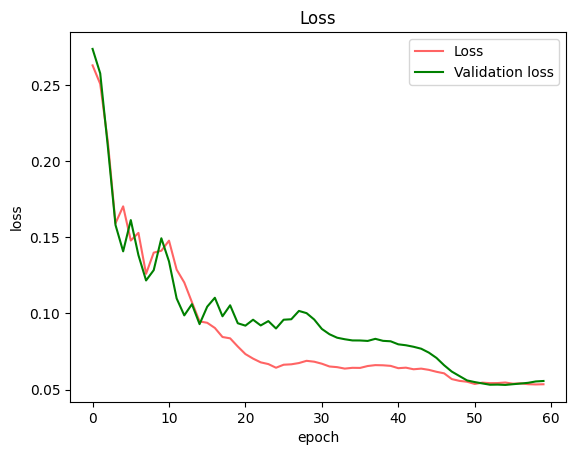

Epoch:  0 | Cost: 0.055449 | Train accuracy: 0.902857 | Validation Accuracy: 0.880000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.14, loss: 0.39009869438509126
step 2, accuracy_train:0.19714285714285715, loss: 0.31803617438721526
step 3, accuracy_train:0.25142857142857145, loss: 0.23651209127201842
step 4, accuracy_train:0.43142857142857144, loss: 0.2184046360757147
step 5, accuracy_train:0.41714285714285715, loss: 0.2177324846437808
step 6, accuracy_train:0.5114285714285715, loss: 0.182117370457076
step 7, accuracy_train:0.5171428571428571, loss: 0.17576967062754364
step 8, accuracy_train:0.5342857142857143, loss: 0.1810055075209049
step 9, accuracy_train:0.5085714285714286, loss: 0.19056934412606824
step 10, accuracy_train:0.5228571428571429, loss: 0.17960504321711562
step 11, accuracy_train:0.5685714285714286, loss: 0.15735685793880688
step 12, accuracy_train:0.6028571428571429, loss: 0.14735542221921236
step 13, accuracy_train:0.6142857142857143, loss: 

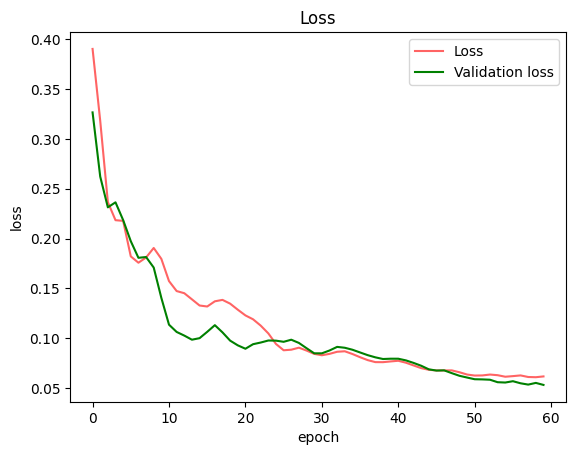

Epoch:  0 | Cost: 0.071251 | Train accuracy: 0.860000 | Validation Accuracy: 0.920000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.18571428571428572, loss: 0.295224564921122
step 2, accuracy_train:0.47714285714285715, loss: 0.1756339763176759
step 3, accuracy_train:0.5228571428571429, loss: 0.15210592034993353
step 4, accuracy_train:0.7114285714285714, loss: 0.1277299237020231
step 5, accuracy_train:0.8, loss: 0.10384339331255393
step 6, accuracy_train:0.7342857142857143, loss: 0.13804243224146542
step 7, accuracy_train:0.8457142857142858, loss: 0.11519315909954247
step 8, accuracy_train:0.8114285714285714, loss: 0.09441164874005109
step 9, accuracy_train:0.7857142857142857, loss: 0.09923965922081432
step 10, accuracy_train:0.7885714285714286, loss: 0.09252812019360851
step 11, accuracy_train:0.7857142857142857, loss: 0.08897205942487521
step 12, accuracy_train:0.7914285714285715, loss: 0.08956117725946547
step 13, accuracy_train:0.8, loss: 0.086316377169961

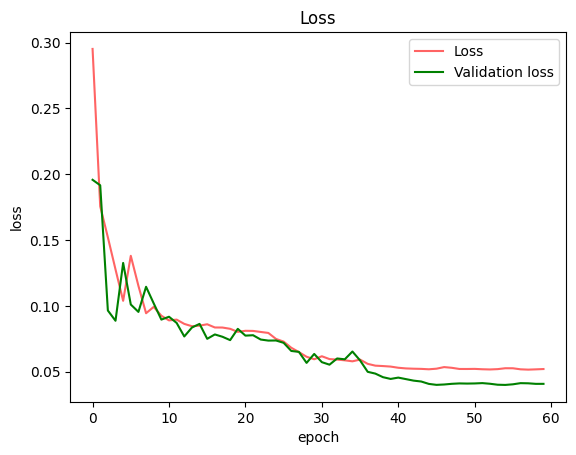

Epoch:  0 | Cost: 0.055438 | Train accuracy: 0.882857 | Validation Accuracy: 0.920000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.21714285714285714, loss: 0.3580132392609516
step 2, accuracy_train:0.5057142857142857, loss: 0.1834838712633591
step 3, accuracy_train:0.37142857142857144, loss: 0.20507970688698726
step 4, accuracy_train:0.5457142857142857, loss: 0.19841772641731492
step 5, accuracy_train:0.6, loss: 0.18359778031870216
step 6, accuracy_train:0.48, loss: 0.22241965742599845
step 7, accuracy_train:0.5742857142857143, loss: 0.199192972356712
step 8, accuracy_train:0.5714285714285714, loss: 0.17509925174722185
step 9, accuracy_train:0.5714285714285714, loss: 0.16345547966249646
step 10, accuracy_train:0.47714285714285715, loss: 0.16163993520226494
step 11, accuracy_train:0.6028571428571429, loss: 0.16141399256060404
step 12, accuracy_train:0.6114285714285714, loss: 0.1634769954672336
step 13, accuracy_train:0.62, loss: 0.15113138819397065
step 14, a

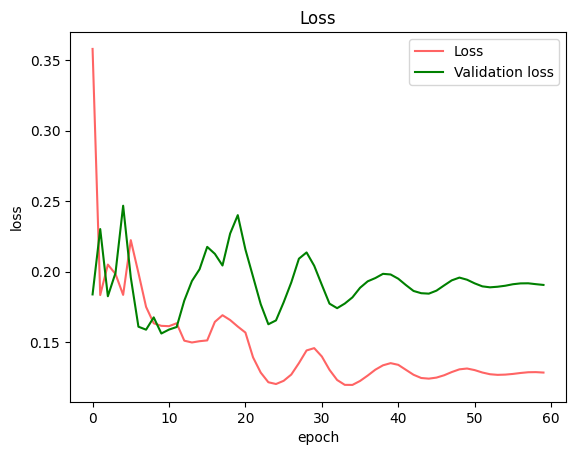

Epoch:  0 | Cost: 0.160792 | Train accuracy: 0.614286 | Validation Accuracy: 0.700000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.41714285714285715, loss: 0.26986483535310596
step 2, accuracy_train:0.4657142857142857, loss: 0.20819973610927528
step 3, accuracy_train:0.4142857142857143, loss: 0.22709968294981092
step 4, accuracy_train:0.5971428571428572, loss: 0.17985290892830863
step 5, accuracy_train:0.5057142857142857, loss: 0.2336674681226646
step 6, accuracy_train:0.64, loss: 0.1883786930730368
step 7, accuracy_train:0.6714285714285714, loss: 0.1518105719570318
step 8, accuracy_train:0.7171428571428572, loss: 0.1029759144195319
step 9, accuracy_train:0.7771428571428571, loss: 0.10057764160804408
step 10, accuracy_train:0.82, loss: 0.08275842265647085
step 11, accuracy_train:0.7228571428571429, loss: 0.095040791194175
step 12, accuracy_train:0.8257142857142857, loss: 0.08673537057424285
step 13, accuracy_train:0.8057142857142857, loss: 0.0734730167047965

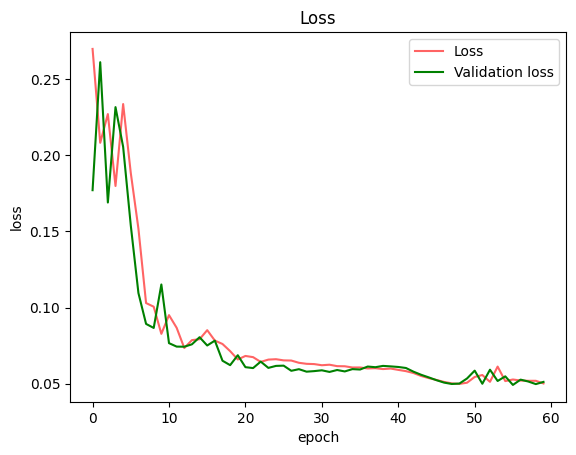

Epoch:  0 | Cost: 0.057060 | Train accuracy: 0.888571 | Validation Accuracy: 0.920000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.5228571428571429, loss: 0.37581461232384183
step 2, accuracy_train:0.6685714285714286, loss: 0.20940418551710216
step 3, accuracy_train:0.6171428571428571, loss: 0.13610343925180293
step 4, accuracy_train:0.7114285714285714, loss: 0.12288743958836032
step 5, accuracy_train:0.6914285714285714, loss: 0.14035144585272707
step 6, accuracy_train:0.7285714285714285, loss: 0.1116755711932623
step 7, accuracy_train:0.7742857142857142, loss: 0.10544043873018621
step 8, accuracy_train:0.74, loss: 0.10732470968208493
step 9, accuracy_train:0.74, loss: 0.10338320962234623
step 10, accuracy_train:0.7657142857142857, loss: 0.1155838222338392
step 11, accuracy_train:0.7914285714285715, loss: 0.1061818835910543
step 12, accuracy_train:0.7685714285714286, loss: 0.10352031072106543
step 13, accuracy_train:0.7942857142857143, loss: 0.09494738245255

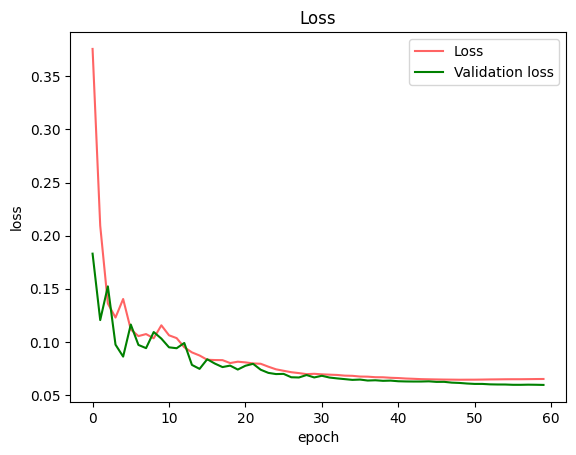

Epoch:  0 | Cost: 0.066763 | Train accuracy: 0.894286 | Validation Accuracy: 0.880000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.26857142857142857, loss: 0.35782836507550286
step 2, accuracy_train:0.5114285714285715, loss: 0.2993367824649655
step 3, accuracy_train:0.30857142857142855, loss: 0.27096011235130607
step 4, accuracy_train:0.5685714285714286, loss: 0.2002082765187282
step 5, accuracy_train:0.6085714285714285, loss: 0.14282144751580195
step 6, accuracy_train:0.6571428571428571, loss: 0.14987792763889451
step 7, accuracy_train:0.5285714285714286, loss: 0.2000564626407496
step 8, accuracy_train:0.5457142857142857, loss: 0.2071274693989909
step 9, accuracy_train:0.64, loss: 0.17224238019460436
step 10, accuracy_train:0.74, loss: 0.1318001537231833
step 11, accuracy_train:0.7571428571428571, loss: 0.1130380160869656
step 12, accuracy_train:0.7914285714285715, loss: 0.10874366049410919
step 13, accuracy_train:0.7742857142857142, loss: 0.134223104603238

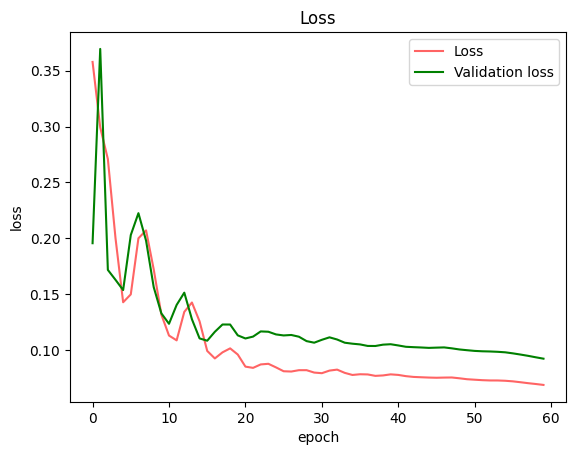

Epoch:  0 | Cost: 0.065716 | Train accuracy: 0.882857 | Validation Accuracy: 0.740000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.4342857142857143, loss: 0.2815215791970542
step 2, accuracy_train:0.5171428571428571, loss: 0.21007418652330312
step 3, accuracy_train:0.39714285714285713, loss: 0.23143317549694253
step 4, accuracy_train:0.7285714285714285, loss: 0.20344399252198753
step 5, accuracy_train:0.5142857142857142, loss: 0.21587418925881935
step 6, accuracy_train:0.6828571428571428, loss: 0.14826073617218088
step 7, accuracy_train:0.64, loss: 0.12842700535713442
step 8, accuracy_train:0.7628571428571429, loss: 0.10416109659563122
step 9, accuracy_train:0.7485714285714286, loss: 0.1252899466002897
step 10, accuracy_train:0.8114285714285714, loss: 0.12701638305750285
step 11, accuracy_train:0.8285714285714286, loss: 0.09719817468890946
step 12, accuracy_train:0.8285714285714286, loss: 0.08898277992204062
step 13, accuracy_train:0.8257142857142857, loss: 

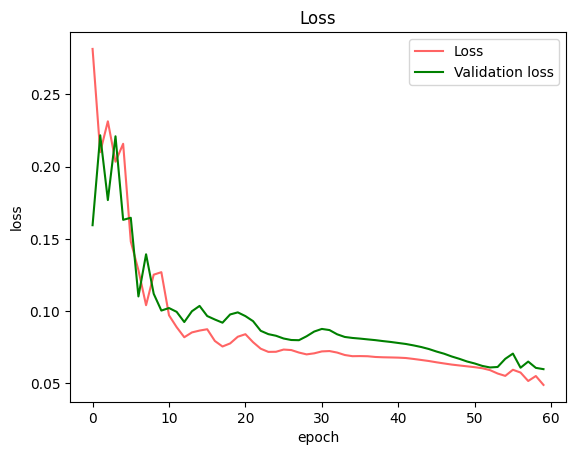

Epoch:  0 | Cost: 0.058640 | Train accuracy: 0.865714 | Validation Accuracy: 0.900000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.49142857142857144, loss: 0.5056179303049585
step 2, accuracy_train:0.5342857142857143, loss: 0.2645092861186259
step 3, accuracy_train:0.6628571428571428, loss: 0.14013119228262766
step 4, accuracy_train:0.7371428571428571, loss: 0.14498074171165415
step 5, accuracy_train:0.7942857142857143, loss: 0.12936831356263018
step 6, accuracy_train:0.76, loss: 0.1372965827529179
step 7, accuracy_train:0.88, loss: 0.10445172401789748
step 8, accuracy_train:0.7914285714285715, loss: 0.10060714687201838
step 9, accuracy_train:0.8342857142857143, loss: 0.08861677477858514
step 10, accuracy_train:0.8257142857142857, loss: 0.07536514525794336
step 11, accuracy_train:0.8028571428571428, loss: 0.08566756550290033
step 12, accuracy_train:0.8457142857142858, loss: 0.08989869069066521
step 13, accuracy_train:0.8542857142857143, loss: 0.0850931892245

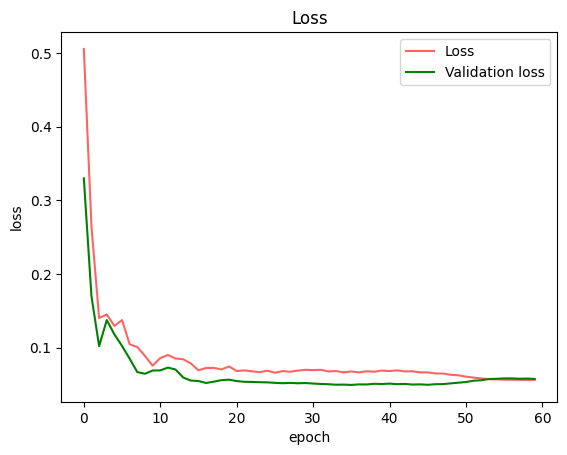

Epoch:  0 | Cost: 0.068247 | Train accuracy: 0.868571 | Validation Accuracy: 0.900000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.38, loss: 0.23646859301999204
step 2, accuracy_train:0.6571428571428571, loss: 0.1810893592103741
step 3, accuracy_train:0.5628571428571428, loss: 0.15721758651080292
step 4, accuracy_train:0.62, loss: 0.17379557321120426
step 5, accuracy_train:0.6371428571428571, loss: 0.20253780528827353
step 6, accuracy_train:0.6314285714285715, loss: 0.18105818397693293
step 7, accuracy_train:0.7, loss: 0.1433798803011434
step 8, accuracy_train:0.6828571428571428, loss: 0.13360357405431766
step 9, accuracy_train:0.6742857142857143, loss: 0.1288736643086955
step 10, accuracy_train:0.6714285714285714, loss: 0.12593494975645053
step 11, accuracy_train:0.6885714285714286, loss: 0.12606938481329938
step 12, accuracy_train:0.68, loss: 0.1309714580478839
step 13, accuracy_train:0.6685714285714286, loss: 0.13537298110356583
step 14, accuracy_train:0.

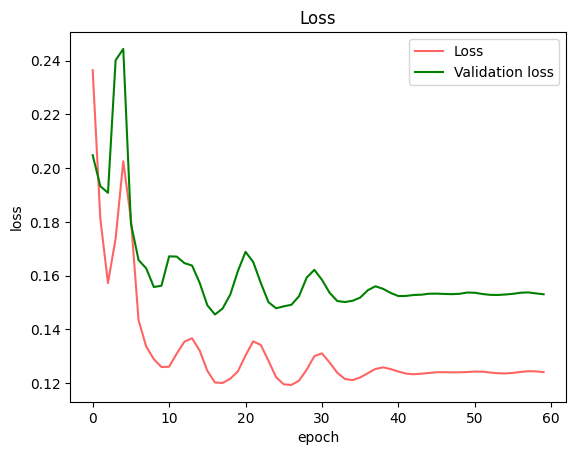

Epoch:  0 | Cost: 0.126565 | Train accuracy: 0.677143 | Validation Accuracy: 0.600000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
t_n_seeds: 60.9013173000003


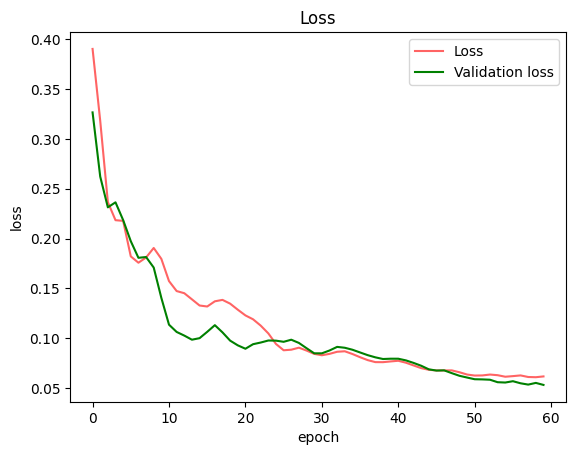

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.1375, loss: 0.39105157541701885
step 2, accuracy_train:0.305, loss: 0.3000455717886781
step 3, accuracy_train:0.33, loss: 0.26860575179983487
step 4, accuracy_train:0.385, loss: 0.2889331183238444
step 5, accuracy_train:0.4275, loss: 0.3028342425167393
step 6, accuracy_train:0.4625, loss: 0.25904021840224123
step 7, accuracy_train:0.39, loss: 0.20360527580216103
step 8, accuracy_train:0.52, loss: 0.1833035983241995
step 9, accuracy_train:0.575, loss: 0.18601868104373775
step 10, accuracy_train:0.54, loss: 0.1855842957051749
step 11, accuracy_train:0.5525, loss: 0.1764007217163743
step 12, accuracy_train:0.545, loss: 0.16907794299018963
step 13, accuracy_train:0.5325, loss: 0.16285558199275743
step 14, accuracy_train:0.5375, loss: 0.15991049668210783
step 15, accuracy_train:0.5925, loss: 0.15403468370791923
step 16, accuracy_train:0.605, loss: 0.15053415479811127
step 17, acc

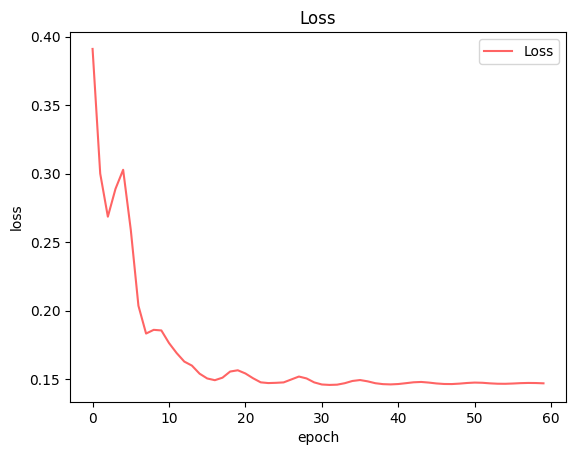

Epoch:  0 | Cost: 0.147112 | Train accuracy: 0.635000 | Test Accuracy: 0.390000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)


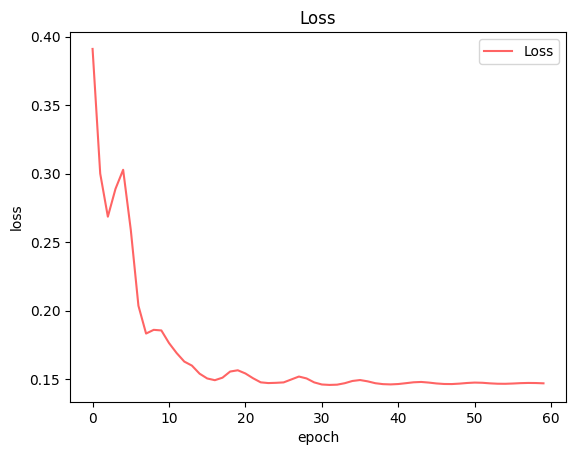

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.38285714285714284, loss: 0.2521469063423377
step 2, accuracy_train:0.3742857142857143, loss: 0.21160405209811406
step 3, accuracy_train:0.5285714285714286, loss: 0.19913279077715074
step 4, accuracy_train:0.46, loss: 0.2269702086316252
step 5, accuracy_train:0.5885714285714285, loss: 0.185109628333943
step 6, accuracy_train:0.7028571428571428, loss: 0.14185736359730147
step 7, accuracy_train:0.6714285714285714, loss: 0.12444539440965419
step 8, accuracy_train:0.7285714285714285, loss: 0.12417785569119531
step 9, accuracy_train:0.72, loss: 0.121961335550068
step 10, accuracy_train:0.7171428571428572, loss: 0.11528174848091335
step 11, accuracy_train:0.7828571428571428, loss: 0.10867441532227301
step 12, accuracy_train:0.8171428571428572, loss: 0.10858683305517891
step 13, accuracy_train:0.

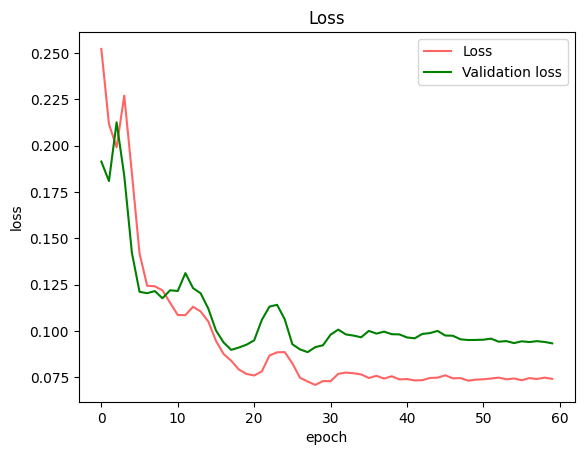

Epoch:  0 | Cost: 0.071860 | Train accuracy: 0.862857 | Validation Accuracy: 0.780000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 2, 1, 1, 3)
step 1, accuracy_train:0.3, loss: 0.18927133248307562
step 2, accuracy_train:0.6257142857142857, loss: 0.13472448288672428
step 3, accuracy_train:0.8, loss: 0.10448398259581534
step 4, accuracy_train:0.8085714285714286, loss: 0.10692746330746702
step 5, accuracy_train:0.82, loss: 0.09735949477938496
step 6, accuracy_train:0.8628571428571429, loss: 0.07766960499624914
step 7, accuracy_train:0.8857142857142857, loss: 0.07003222389616849
step 8, accuracy_train:0.8571428571428571, loss: 0.07169282095080269
step 9, accuracy_train:0.8457142857142858, loss: 0.07468194900948487
step 10, accuracy_train:0.88, loss: 0.07216887334455048
step 11, accuracy_train:0.86, loss: 0.06413845049877748
step 12, accuracy_train:0.8771428571428571, loss: 0.06036748427506744
step 13, accuracy_train:0.8828571428571429, loss: 0.05843277026458686
step 14, accuracy_train:0.90285714285

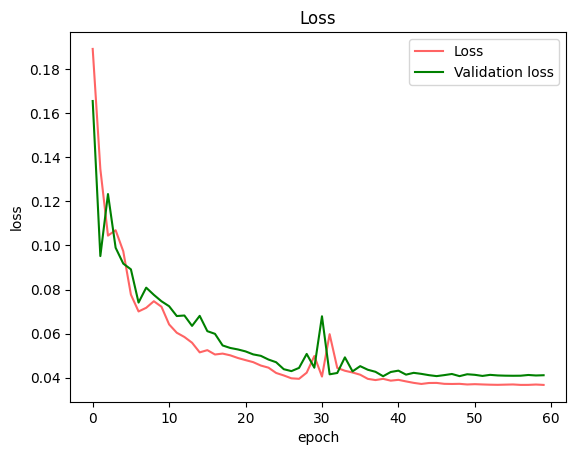

Epoch:  0 | Cost: 0.043872 | Train accuracy: 0.917143 | Validation Accuracy: 0.980000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 2, 1, 1, 3)
step 1, accuracy_train:0.48, loss: 0.22814773280629919
step 2, accuracy_train:0.6371428571428571, loss: 0.16115754485614192
step 3, accuracy_train:0.5742857142857143, loss: 0.14396648995485126
step 4, accuracy_train:0.6885714285714286, loss: 0.12182628677505289
step 5, accuracy_train:0.7685714285714286, loss: 0.11200561454700345
step 6, accuracy_train:0.78, loss: 0.10609532109041
step 7, accuracy_train:0.7485714285714286, loss: 0.10511632034263578
step 8, accuracy_train:0.7742857142857142, loss: 0.10898141692615726
step 9, accuracy_train:0.7828571428571428, loss: 0.10136531339818963
step 10, accuracy_train:0.8085714285714286, loss: 0.09509677178479164
step 11, accuracy_train:0.8457142857142858, loss: 0.09091596677635552
step 12, accuracy_train:0.8457142857142858, loss: 0.08906779222063121
step 13, accuracy_train:0.8371428571428572, loss: 0.08882675883751

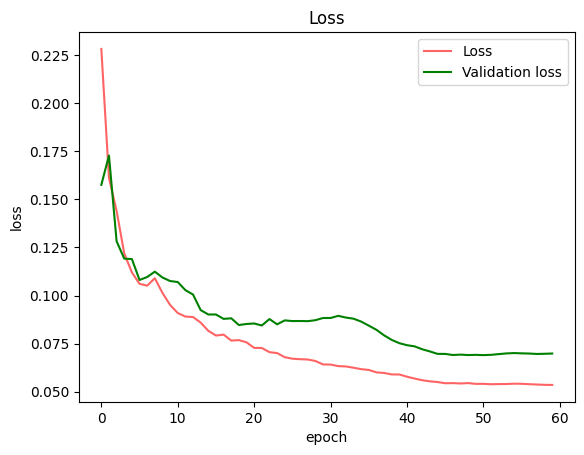

Epoch:  0 | Cost: 0.057819 | Train accuracy: 0.905714 | Validation Accuracy: 0.880000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 2, 1, 1, 3)
step 1, accuracy_train:0.32, loss: 0.4662830968763336
step 2, accuracy_train:0.45714285714285713, loss: 0.24787025817300617
step 3, accuracy_train:0.6, loss: 0.15158684782970477
step 4, accuracy_train:0.7171428571428572, loss: 0.1284356947660043
step 5, accuracy_train:0.8542857142857143, loss: 0.1445288460090228
step 6, accuracy_train:0.8514285714285714, loss: 0.14580975965887066
step 7, accuracy_train:0.8714285714285714, loss: 0.13944610225026968
step 8, accuracy_train:0.84, loss: 0.11859854894272165
step 9, accuracy_train:0.8742857142857143, loss: 0.08883024686450339
step 10, accuracy_train:0.9028571428571428, loss: 0.06543913091514833
step 11, accuracy_train:0.9142857142857143, loss: 0.05537745971409115
step 12, accuracy_train:0.9028571428571428, loss: 0.056876476746935245
step 13, accuracy_train:0.9085714285714286, loss: 0.058929370868889705
step 14,

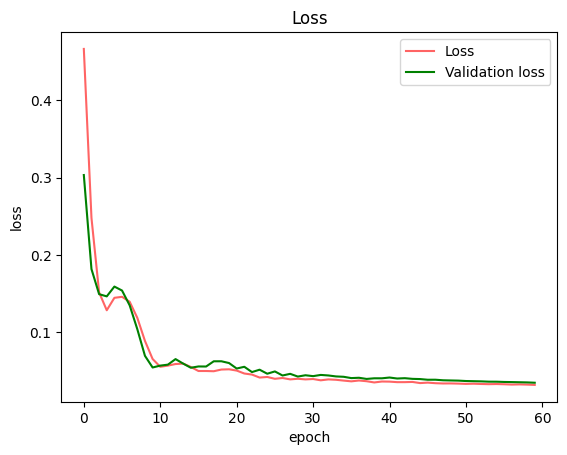

Epoch:  0 | Cost: 0.031746 | Train accuracy: 0.940000 | Validation Accuracy: 0.900000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 2, 1, 1, 3)


In [ ]:
t_seed_start = time.process_time()
configs['noise'] = training_noise
best_params = []
results = []
for i,setting in enumerate(settings):
    enc_dim,num_qubits,num_layers,num_reupload,num_rot = setting
    learning_rate,max_epoch,batch_size,dynamic_size,threshold = h_pms[best_h_pm[i]]
    t_seed_start = time.process_time()
    # Generate training and test data
    X_train, y_train, X_test, y_test = initialize_data(problem,num_training,num_test,seed_num,enc_dim,**configs)
    configs['qc'] = qcircuit(*setting, **configs)
    
    seed_rsts, seed_params = [], []
    loss_history_seeds= []
    #run 10 seeds
    for seed_num in seeds:
        #########
        loss_history = []
        valid_loss_history = []
        accuracy_history = []  
        configs['iter_lr'] = iter(learning_rate)
        configs['iter_thres'] = iter(list(threshold))
        configs['lr'] = next(configs['iter_lr'])
        configs['thres_n'] = next(configs['iter_thres'])

        seed_rst = run(seed_num, X_train, y_train, *setting, **configs)
        #########
        seed_params.append(seed_rst[0])
        seed_rsts.append(seed_rst[1])
        loss_history_seeds.append([loss_history,valid_loss_history])
    t_n_seeds = time.process_time()-t_seed_start
    print('t_n_seeds:', t_n_seeds)
    best_index = np.argmax(seed_rsts,axis=0)[2]  #best index based on validation accuracy->(seed_num,accuracy_train, accuracy_valid,...) 
    #best_rst = seed_rsts[best_index]
    seed_num = seeds[best_index]
    l_h_best, val_l_h_best = loss_history_seeds[best_index]
    plot_loss_history(l_h_best, val_l_h_best, setting=setting,
                      fig_name = f'{setting}_loss_best_seed')
    #########
    configs['noise'] = test_noise
    loss_history = []
    valid_loss_history = []
    accuracy_history = []
    configs['iter_lr'] = iter(learning_rate)
    configs['iter_thres'] = iter(list(threshold))
    configs['lr'] = next(configs['iter_lr'])
    configs['thres_n'] = next(configs['iter_thres'])
    params,best_rst = run(seed_num, X_train, y_train, x_te = X_test, y_te = y_test, ratio_tr=1, *setting, **configs)
    plot_loss_history(loss_history, setting=setting)
    #########
    best_params.append(params)
    results.append([enc_dim,num_qubits,num_layers,num_reupload,num_rot,*best_rst, t_n_seeds])
t_seeds = time.process_time()-t_seed_start

In [ ]:
def name_experiment(num_settings,start_value):
    exp_name = '('
    exp = ['enc','q','f','r','rot']
    # if len(exp)!=len(num_settings): print(experiment styles not matched!)
    for i, j in enumerate(num_settings):
        exp_name = exp_name+f'{start_value[i]}' if j==1 else exp_name+f'{exp[i]}'
        exp_name = exp_name+')' if i==len(exp)-1 else exp_name+','
    return exp_name
exp_name = name_experiment(num_settings,start_values)
exp_name

In [ ]:
import pandas as pd
data = {'enc_dim' : [],
        'num_qubits' : [],
        'num_layers' : [],
        'num_reupload' : [],
        'num_rot ': [],
        'seed_num' : [],
        'Train_acc' : [],
        'Test_acc' : [],
        'loss' : [],
        'num_epoch':[],
        f'time_{num_seeds}_seeds' : []}
for result in results:
    for i,(d,r) in enumerate(zip(data,result)):
        print(d,r)
        if i<5: data[d].append(int(r));
        else:   data[d].append(float(r))

# 将数据转换为DataFrame
df = pd.DataFrame(data)
df.style.hide()
# 显示DataFrame
#print(df.to_string(index=False))
# 若要在Jupyter Notebook中显示漂亮的表格，可以使用以下方法
display(df)
# 如果需要将DataFrame保存为HTML文件，可以使用以下方法
# df.to_html('table.html')

# Export to Excel
excel_file_path = f'Data_{exp_name}.xlsx'
sheet_name = 'Sheet1'

df.to_excel(excel_file_path, index=False, sheet_name=sheet_name)

In [ ]:
rec_settings = {'problem':problem,
                'shape':shape, 
                'rot':rot,
                'num_training':len(X_train),
                'num_test':len(X_test),
                'preprocess':configs['preprocess'],
                'max_converge_number':max_n_converge,
                'threshold_of_converge':thres_converge,
                'data_seed_num': data_seed_num,
                'param_seed_nums': seeds,
                f't_{num_cvs}_cv': f'{t_cvs} s',
                f't_{num_seeds}_seeds': f'{t_seeds} s',
                '[enc_dim,num_qubits,num_layers,num_reupload,num_rot]':settings,
                '[learning_rate,max_epoch,batch_size,dynamic_size,threshold]':[h_pms[i] for i in best_h_pm ]
               }
#dict_settings = {k:v for i,(k,v) in enumerate(data.items()) if i<6 }

In [ ]:
F = open("{}_settings.txt".format(ver), "w")
for i,j in rec_settings.items():
    F.write(i+": {}\n".format(j))
    
for i,setting in enumerate(settings):
    F.write(f"params of setting {setting}：\n")
    for key, value in best_params[i].items():
        F.write(f"    {key}: {value} \n")
F.close()

In [ ]:
print(t_cvs)
t_seeds

In [ ]:
for run_exp, x_label in zip([i != 1 for i in num_settings],data):
    if run_exp:
        fig, ax = plt.subplots(1, 1)
        ax.set_ylim([0.5, 1])
        plt.plot(data[x_label],data['Train_acc'],color=(255/255,100/255,100/255),label='Train_acc')
        plt.plot(data[x_label],data['Test_acc'],color='g',label='Test_acc')
        for i,j,k in zip(data[x_label],data['Train_acc'],data['Test_acc']):
            ax.annotate(f'{j}', xy=(i,j), xytext=(0,-10), textcoords='offset points' ,ha='center')
            ax.annotate(f'{k}', xy=(i,k), xytext=(0,-10), textcoords='offset points' ,ha='center')
        plt.title("Accuracy") # title
        plt.ylabel("accuracy") # y label
        plt.xlabel(x_label) # x label
        plt.legend()
        plt.show()
        fig.savefig(f'Accuracy-{x_label}.png', transparent=True)

In [ ]:
def backtrack(n, k, start, path, result):
    if len(path) == k:
        result.append(path[:])
        return
    
    for i in range(start, n + 1):
        path.append(i)
        backtrack(n, k, i, path, result)  # Use i instead of i+1 to allow duplicates
        path.pop()

def generate_combinations(n, k):
    result = []
    backtrack(n, k, 1, [], result)
    return result

# Example usage:
n = 5  # Range from 1 to 5
k = 4  # Length of the array
combinations = generate_combinations(n, k)
print((combinations))


In [ ]:
for i in best_h_pm:
    print(h_pms[i])
best_h_pm

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

X_train, y_train, X_test, y_test = initialize_data(problem,num_training,num_test,seed_num,enc_dim,**configs)
max_search_n=20
n_nodes = []
t1_c = time.process_time()

r_enc, r_q ,r_f, r_r, r_rot = num_settings 
r_f=2
for f in range(r_f):
    scores=[]
    for n in range(max_search_n):
        size = [n+1]*(f+1)
        clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=size, 
                            random_state=data_seed_num,max_iter=6000, warm_start=False)
        score = np.min(cross_val_score(clf, X_train, y_train, cv=10))  
        if score >= data['Test_acc'][f] or n == (max_search_n-1): 
            n_nodes.append(n+1)
            break

sizes = [[n_nodes[f]]*(f+1) for f in range(r_f)]
accuracy_tr, accuracy=[],[]

for size in sizes:
    seed_tr_rsts, seed_rsts = [], []
    for seed in seeds:
        clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=size, 
                                random_state=seed,max_iter=6000, warm_start=False)
        clf.fit(X_train, y_train)
        y_pred_tr = clf.predict(X_train)
        y_pred = clf.predict(X_test)
        # report = classification_report(y_test, y_pred)
        seed_tr_rsts.append(accuracy_score(y_train, y_pred_tr))
        seed_rsts.append(accuracy_score(y_test, y_pred))
    accuracy_tr.append(np.average(seed_tr_rsts))
    accuracy.append(np.average(seed_rsts))
t_c_tot = time.process_time()-t1_c
print(f'Time for classical NN: {t_c_tot} s')
print(accuracy_tr)
print(accuracy)
print(data['Test_acc'])
n_nodes

In [ ]:
def param_n_model(settings, model='NN'):
    if model=='NN':
        n_nodes = settings
        n_params = []
        r_f = len(n_nodes)
        for f in range(r_f):
            n_p=0
            for i in range(f+1):
                n_p=n_p+(len(X_train[0])+1)*n_nodes[f] if i==0  else n_p
                n_p=n_p+(n_nodes[i]+1)*num_class if i==(r_f-1) else n_p
                n_p=n_p+(n_nodes[f]+1)*n_nodes[f] if i!=0 or i!=(r_f-1) else n_p
            n_params.append(n_p)
    if model=='QNN':
        n_params=[]
        for setting in settings:
            enc_dim,num_qubits,num_layers,num_reupload,num_rot = setting
            n_params.append((enc_dim +num_rot*3)*num_qubits*num_reupload*num_layers+ num_class* num_qubits)

    return n_params
num_params_NN = param_n_model(n_nodes,model='NN')
num_params_QNN = param_n_model(settings,model='QNN') 

print('Number of params in NN model:', num_params_NN)
print('Number of params in QNN model:', num_params_QNN)

In [ ]:
import pandas as pd
c_values=np.array([n_nodes,accuracy_tr,accuracy,data['Test_acc'],
                   num_params_NN,num_params_QNN,[t_c_tot]*len(settings)])
c_values=np.append(settings,c_values.T, axis=1)
c_data = {'enc_dim' : [],
        'num_qubits' : [],
        'num_layers' : [],
        'num_reupload' : [],
        'num_rot ': [],
        'num_c_nodes ': [],
        'C_train_acc' : [],
        'C_test_acc' : [],
        'Q_test_acc' : [],
        'num_params_NN' : [],
        'num_params_QNN' : [],
        f'time_{num_seeds}_seeds' : []}
for result in c_values:
    for i,(d,r) in enumerate(zip(c_data,result)):
        if i<6: c_data[d].append(int(r));
        else:   c_data[d].append(float(r))
df = pd.DataFrame(c_data)
df.style.hide()
display(df)
# Export to Excel
excel_file_path = f'classical_data_comparism.xlsx'
sheet_name = 'Sheet1'
df.to_excel(excel_file_path, index=False, sheet_name=sheet_name)

In [ ]:
for fx

In [ ]:
# from qiskit.providers.fake_provider import FakeBelem
# backend = FakeBelem()
# # backend.qubit_properties()
# from datetime import datetime

# t = datetime(day=15, month=4, year=2020, hour=10)
# backend.properties(datetime=t)

In [ ]:
X_test.shape

In [ ]:
F = open("{}_settings.txt".format(ver), "a")
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    ), file = F)#)#

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test[:,:], initial_predictions, fig, axes[0])
plot_data(X_test[:,:], predicted_test, fig, axes[1])
plot_data(X_test[:,:], y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Training Accuracy = {} \n Test Accuracy = {}".format(accuracy_train,accuracy_test))
axes[2].set_title("True test data \n # of points = {}".format(num_test))
plt.tight_layout()
plt.show()
fig.savefig('{}_train.png'.format(ver), transparent=True)

In [ ]:
#initialize_data(problem,num_Test,seed_num=seed_num)

In [ ]:
num_Test = 568
configs['noise'] = test_noise
X_Test, y_Test = initialize_data(problem,num_Test,seed_num=seed_num,**configs)#data_gen(problem,num_Test,seed_num=np.random.randint(num_Test))#circle(num_test)#
predicted_Test, loss, _  = test(params, X_Test, y_Test,*setting,**configs)
accuracy_Test = accuracy_score(y_Test, predicted_Test)  


print("Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_Test), file = F)



fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_train[:,:,], y_train, fig, axes[0])
plot_data(X_Test[:,:], predicted_Test, fig, axes[1])
plot_data(X_Test[:,:], y_Test, fig, axes[2])
axes[0].set_title("Training data")
axes[1].set_title("Predictions after training \n Accuracy = {}".format(accuracy_Test))
axes[2].set_title("True test data \n # of points = {}".format(num_Test))
plt.tight_layout()
plt.show()
fig.savefig('{}_test.png'.format(ver), transparent=True)
print("process_time ：%f s" % (time.process_time()- end))

In [ ]:
for fx

In [ ]:
%whos 

In [ ]:
# from qiskit_ibm_provider import least_busy
# backend = least_busy(provider.backends(min_num_qubits=5,simulator=False,operational=True))
# backend = backend.name
# print(backend)

In [ ]:
#noisy device
str_error = None
noise=True
noise_num_Test = 100
sleep_time = 2
num_retries = 10
noise_batch_size = 9 if real_device else noise_num_Test
#ver = ver+'_'+backend if noise else ver

noise_start = time.time()
noise_XTest, noise_y_Test = data_gen(problem,noise_num_Test,seed_num=noise_num_Test)#circle(num_test)#
noise_X_Test = np.hstack((np.zeros((noise_num_Test,1)), noise_XTest))
noise_predicted_Test = jnp.array([])
noise_minibatches = iterate_minibatches(noise_X_Test, noise_y_Test, batch_size=noise_batch_size)
backend = 'ibm_algiers'
print(backend,noise_start)

In [ ]:
while True:
    try: 
        if not str_error:
            Xbatch, ybatch = next(noise_minibatches)
        for x in range(0, num_retries):  
            try:
                str_error = 'Calculating...'
                configs['noise'] = test_noise
                predicted, loss, _  = test(params, Xbatch, ybatch,*setting,**configs)
                noise_predicted_Test = jnp.append(noise_predicted_Test, predicted)
                print(predicted)
                str_error = None
            except Exception as e:
                str_error = str(e)
                print('err:',str_error)
            if str_error:               # if None->break, if 'some_string'(error happens)->sleep and retry
                time.sleep(sleep_time)  # wait before trying to fetch the data again
                sleep_time *= 1.5  
                if x==(num_retries-1):
                    print('operation fail')
                else:
                    print(f'retry {x} times')
            else:
                break
    except StopIteration:
        break
noise_end = time.time()

In [ ]:
noise_accuracy_Test = accuracy_score(noise_y_Test, noise_predicted_Test)  
print("noise:",noise,", real_device:",real_device,', backend:',backend,', num_noise_Test:',noise_num_Test,file = F)#)#
print("Cost: {:3f} | Noisy Test Accuracy : {:3f}".format(loss, noise_accuracy_Test), file = F)#)#
print("process_time ：%f s" % (noise_end- noise_start), file = F)#)#
print(datetime.datetime.now(), file = F)#)#
# print('noise_model:', None if real_device else noise_model, file = F)
F.close()#
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_train, y_train, fig, axes[0])
plot_data(noise_X_Test[:,1:], noise_predicted_Test, fig, axes[1])
plot_data(noise_X_Test[:,1:], noise_y_Test, fig, axes[2])
axes[0].set_title("Training data")
axes[1].set_title("Predictions after training \n Accuracy with noise = {}".format(noise_accuracy_Test))
axes[2].set_title("True test data \n # of points = {}".format(noise_num_Test))
plt.tight_layout()
plt.show()
fig.savefig('{}_noise_test.png'.format(ver), transparent=True)

In [ ]:
qml.about()

In [ ]:
a = [(i,j) for i,j in zip(globals().keys(),globals().values())]
import sys
for i,j in a:
    print(i,sys.getsizeof(j))

In [ ]:
ibm_brisbane

In [ ]:
dev = qml.device('qiskit.ibmq', wires=2, backend=backend, provider=provider)

In [ ]:
# minimum qiskit-runtime connect-testing code

sleep_time = 5
num_retries = 5
str_error = None
initial_layout = [1,2]# None#
backend = 'ibmq_mumbai' #'ibmq_qasm_simulator' # or 
program_id = 'qiskit.ibmq.sampler' #'qiskit.ibmq.circuit_runner' # 
provider = IBMProvider(instance='ibm-q-hub-ntu/ntu-internal/default')
dev = qml.device(program_id, wires=2, backend=backend
                 , provider=provider,initial_layout=initial_layout,start_session=True)

@qml.qnode(dev)
def circuit(x, y):
    qml.RY(y, wires=[0])
    qml.RX(x, wires=[0])
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.Hermitian([[1,0],[0,0]],wires=0)),qml.expval(qml.PauliY(wires=1))

data = iter([[[0.1,0.2,0.3],[0.2,0.3,0.4]],[[0.4,0.5,0.6],[0.5,0.6,0.7]]])

while True:
    try:
        if not str_error:
            databatch=next(data)
        for x in range(0, num_retries):  
            try:
                rst = circuit(*databatch)
                print('result:',rst)
                str_error = None
            except  Exception as e:
                str_error = str(e)
                print(e)
            if str_error:               # if None->break; if 'some_string'(error happens)->sleep
                time.sleep(sleep_time)  # wait before trying to fetch the data again
                sleep_time *= 3
                print(f'retry {x} times')
            else:
                break
    except StopIteration:
        break

In [ ]:
dm_labels[0]

In [ ]:
initial_layout = [1,2]#None #
backend = 'ibm_auckland'# 'ibmq_qasm_simulator' # or 
program_id = 'qiskit.ibmq.sampler' #'qiskit.ibmq.circuit_runner' # 
provider = IBMProvider(instance='ibm-q-hub-ntu/ntu-internal/default')
dev = qml.device(program_id, wires=2, backend=backend
                 , provider=provider,initial_layout=initial_layout)

@qml.qnode(dev)
def circuit(x, y):
    qml.RY(y, wires=[0])
    qml.RX(x, wires=[0])
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.PauliZ(wires=0)),qml.expval(qml.PauliY(wires=1))

data = iter([[[0.1,0.2,0.3],[0.2,0.3,0.4]],[[0.4,0.5,0.6],[0.5,0.6,0.7]]])
databatch = next(data)
databatch = next(data)
circuit(*databatch)

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session

In [ ]:
##qiskit version
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options

shots = 2048
sleep_time = 5
num_retries = 5
str_error = None
initial_layout = None#[1,2]
provider = IBMProvider(instance='ibm-q-hub-ntu/ntu-internal/default')
backend = provider.get_backend('ibmq_jakarta')#'ibm_hanoi')#'ibmq_qasm_simulator')#'ibmq_quito')
runtime_service = QiskitRuntimeService(channel="ibm_quantum")
options = {"backend": backend.name}
def qcircuit(x,y):
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    circuit = QuantumCircuit(qr, cr)
    circuit.rx(x,qr[0])
    circuit.ry(y,qr[1])
    circuit.cx(qr[0], qr[1])
    circuit.measure(qr, cr)
    mapped_circuit = transpile(circuit, backend=backend)
    return mapped_circuit
data = iter([[0.1,0.2],[0.2,0.3],[0.4,0.5]])

while True:
    try:
        if not str_error:
            databatch=next(data)
        for x in range(0, num_retries):  
            try:
                program_inputs = {"circuits": qcircuit(*databatch)  , "shots": shots , 'initial_layout':initial_layout
                                  , 'optimization_level': 3,'start_session': True}
                job = runtime_service.run(program_id="circuit-runner", options=options, inputs=program_inputs)#
                counts = job.result().get_counts()
                print('result:',counts)
                str_error = None
            except  Exception as e:
                str_error = str(e)
                print(e)
            if str_error:               # if None->break; if 'some_string'(error happens)->sleep
                time.sleep(sleep_time)  # wait before trying to fetch the data again
                sleep_time *= 3
                print(f'retry {x} times')
            else:
                break
    except StopIteration:
        break

In [ ]:
circuit(*databatch)

In [ ]:
# provider = IBMProvider()
# dev = qml.device('qiskit.ibmq', wires=2, backend=backend, provider=provider)
# dev.capabilities()['backend']

In [ ]:




from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
x,y = load_breast_cancer(return_X_y=True)
x.shape